# 0. 데이터 로드

In [1]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier
from scipy.spatial import KDTree
from sklearn.preprocessing import StandardScaler

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
interest_df = pd.read_csv('/content/drive/MyDrive/AI Tech/프로젝트/Level 2. 수도권 아파트 전세가 예측 모델/data/interestRate.csv')
park_df = pd.read_csv('/content/drive/MyDrive/AI Tech/프로젝트/Level 2. 수도권 아파트 전세가 예측 모델/data/parkInfo.csv')
school_df = pd.read_csv('/content/drive/MyDrive/AI Tech/프로젝트/Level 2. 수도권 아파트 전세가 예측 모델/data/schoolinfo.csv')
subway_df = pd.read_csv('/content/drive/MyDrive/AI Tech/프로젝트/Level 2. 수도권 아파트 전세가 예측 모델/data/subwayInfo.csv')
train_df = pd.read_csv('/content/drive/MyDrive/AI Tech/프로젝트/Level 2. 수도권 아파트 전세가 예측 모델/data/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/AI Tech/프로젝트/Level 2. 수도권 아파트 전세가 예측 모델/data/test.csv')

In [5]:
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 20)

In [6]:
class Preprocessor:
    """데이터 전처리를 수행하는 클래스입니다.
    """

    def __init__(self, train_df: pd.DataFrame, test_df: pd.DataFrame, park_df: pd.DataFrame,
                 school_df: pd.DataFrame, subway_df: pd.DataFrame, interest_df: pd.DataFrame) -> None:
        """전처리하는 데에 있어서 필요한 데이터들을 받고 저장합니다.

        Parameters
        ----------
        train_df : pd.DataFrame
            학습 데이터 프레임입니다.
        test_df : pd.DataFrame
            테스트 데이터 프레임입니다.
        park_df : pd.DataFrame
            공원 데이터 프레임입니다.
        school_df : pd.DataFrame
            학교 데이터 프레임입니다.
        subway_df : pd.DataFrame
            지하철 데이터 프레임입니다.
        interest_df : pd.DataFrame
            금리 데이터 프레임입니다.
        """
        self.train_df = train_df
        self.test_df = test_df
        self.park_df = park_df
        self.school_df = school_df
        self.subway_df = subway_df
        self.interest_df = interest_df

        # train_df와 test_df를 합친 DataFrame입니다.
        # 전처리는 이 DataFrame을 기반으로 진행됩니다.
        self.all_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

        self.all_df['contract_type'] = self.all_df['contract_type'].astype('category')

        # (latitude, longitude) 튜플을 고유한 id로 변환하는 딕셔너리입니다.
        # 이는 위치 데이터를 다루는 데에 있어서 중복된 계산을 피하기 위함입니다.
        unique_locations = self.all_df[['latitude', 'longitude']].drop_duplicates().values.tolist()
        self.loc_to_id = {tuple(loc): id for id, loc in enumerate(unique_locations)}

    def remove_unnecessary_locations(self, epsilon: float):
        """예측하고자 하는 집들의 공간으로부터 epsilon 이상 떨어져있기에 예측에 있어서 불필요한 장소를 제거합니다.

        Parameters
        ----------
        epsilon : float
            제거할 장소를 결정하는 기준입니다.

            집들이 모여있는 사각형 경계로부터 epsilon 이상 떨어져있는 장소들을 제거합니다.
        """
        min_lat, max_lat = self.all_df['latitude'].min() - epsilon, self.all_df['latitude'].max() + epsilon
        min_long, max_long = self.all_df['longitude'].min() - epsilon, self.all_df['longitude'].max() + epsilon

    def get_clean_df(location_df: pd.DataFrame) -> pd.DataFrame:
        location_df = location_df[(location_df['latitude'] > min_lat) & (location_df['latitude'] < max_lat)]
        location_df = location_df[(location_df['longitude'] > min_long) & (location_df['longitude'] < max_long)]
        return location_df

        self.park_df = get_clean_df(self.park_df)
        self.school_df = get_clean_df(self.school_df)
        self.subway_df = get_clean_df(self.subway_df)

    def add_location_id(self) -> None:
        """위치에 따른 고유한 id를 추가합니다.
        """
        tuple_array = [self.all_df['latitude'].values, self.all_df['longitude'].values]
        self.all_df['location_id'] = pd.Series(
            [self.loc_to_id[(lat, long)] for lat, long in zip(*tuple_array)]
        ).astype('category')

    def add_latitude_bin(self, bin: float) -> None:
        """위도를 binning하여 category로 만든 열을 추가합니다.

        Parameters
        ----------
        bin : float
            bin의 크기입니다.
        """
        min_lat, max_lat = self.all_df['latitude'].min(), self.all_df['latitude'].max()
        self.all_df['latitude_bin'] = pd.cut(
            self.all_df['latitude'],
            bins=np.arange(min_lat, max_lat, bin)
        ).cat.codes.astype('category')

    def add_longitude_bin(self, bin: float) -> None:
        """경도를 binning하여 category로 만든 열을 추가합니다.

        Parameters
        ----------
        bin : float
            bin의 크기입니다.
        """
        min_long, max_long = self.all_df['longitude'].min(), self.all_df['longitude'].max()
        self.all_df['longitude_bin'] = pd.cut(
            self.all_df['longitude'],
            bins=np.arange(min_long, max_long, bin)
        ).cat.codes.astype('category')

    def add_min_distance_to_park(self, min_area: int = -1, max_area: int = 1e12) -> None:
        """가장 가까운 공원까지의 거리를 추가합니다.

        add_location_id를 먼저 호출해야합니다.

        Parameters
        ----------
        min_area : int, optional
            공원의 최소 면적입니다. 이보다 작은 공원은 고려하지 않습니다.
        max_area : int, optional
            공원의 최대 면적입니다. 이보다 큰 공원은 고려하지 않습니다.
        """
        park_df = self.park_df[(self.park_df['area'] >= min_area) & (self.park_df['area'] <= max_area)]
        park_tree = KDTree(park_df[['latitude', 'longitude']])

        id_to_distance = {id: park_tree.query([loc])[0][0] for loc, id in self.loc_to_id.items()}
        feature_name = 'min_distance_to_park'
        if min_area > -1:
            feature_name += f'_min_{min_area}'
        if max_area < 1e12:
            feature_name += f'_max_{max_area}'
        self.all_df[feature_name] = self.all_df['location_id'].map(id_to_distance)

    def add_min_distance_to_school(self, school_type: str = 'all') -> None:
        """가장 가까운 학교까지의 거리를 추가합니다.

        add_location_id를 먼저 호출해야합니다.

        Parameters
        ----------
        school_type : str, optional
            고려할 학교의 종류입니다. 다음 중 하나일 수 있습니다.

            'elementary': 초등학교
            'middle': 중학교
            'high': 고등학교
            'all': 모든 종류의 학교
        """
        school_df = self.school_df.copy()
        if school_type != 'all':
            school_df = school_df[school_df['schoolLevel'] == school_type]
        school_tree = KDTree(school_df[['latitude', 'longitude']])

        id_to_distance = {id: school_tree.query([loc])[0][0] for loc, id in self.loc_to_id.items()}
        feature_name = f'min_distance_to_school_{school_type}'
        self.all_df[feature_name] = self.all_df['location_id'].map(id_to_distance)

    def add_min_distance_to_subway(self) -> None:
        """가장 가까운 지하철까지의 거리를 추가합니다.

        add_location_id를 먼저 호출해야합니다.
        """
        subway_tree = KDTree(self.subway_df[['latitude', 'longitude']])

        id_to_distance = {id: subway_tree.query([loc])[0][0] for loc, id in self.loc_to_id.items()}
        self.all_df['min_distance_to_subway'] = self.all_df['location_id'].map(id_to_distance)

    def add_locations_within_radius(self, location_type: str, radius: float) -> None:
        """반경 내에 있는 특정 장소의 수를 추가합니다.

        add_location_id를 먼저 호출해야합니다.

        Parameters
        ----------
        location_type : str
            장소의 종류입니다. 'subway', 'school', 'park' 중 하나일 수 있습니다.
        radius : float
            반경입니다.
        """
        loc_df = getattr(self, f'{location_type}_df')
        loc_tree = KDTree(loc_df[['latitude', 'longitude']])
        id_to_loc_nums = {id: loc_tree.query_ball_point(loc, r=radius, return_length=True)
                          for loc, id in self.loc_to_id.items()}
        feature_name = f'num_{location_type}_within_{radius}'
        self.all_df[feature_name] = self.all_df['location_id'].map(id_to_loc_nums)

    def add_interest_rate(self) -> None:
        """금리 데이터를 추가합니다.

        contract_year_month 행이 존재해야합니다.
        """
        self.all_df = self.all_df.merge(self.interest_df,
                                        left_on='contract_year_month',
                                        right_on='year_month',
                                        how='left')

    def drop_columns(self, column_names: list[str]) -> None:
        """불필요한 열을 제거합니다.

        Parameters
        ----------
        column_names : list[str]
            제거핧 열의 이름입니다.
        """
        self.all_df = self.all_df.drop(columns=column_names)

    # 추가
    def drop_park_area0(self) -> None:
        """공원의 면적이 0인 행을 제거합니다.
        """
        self.park_df = self.park_df[self.park_df['area'] > 0]

    # 추가
    def find_optimal_clusters(self, features: np.ndarray, max_k: int, min_k: int, sample_size: float = 0.1) -> int:
        """
        엘보우 방법과 실루엣 스코어를 사용하여 최적의 클러스터 개수를 찾습니다.
        GPU 가속을 적용한 cuML KMeans를 사용합니다.

        Parameters
        ----------
        features : np.ndarray
            클러스터링에 사용할 특징 데이터 (표준화된 데이터).
        max_k : int, optional
            클러스터의 최대 개수입니다.
        min_k : int, optional
            클러스터의 최소 개수입니다.
        sample_size : float, optional
            샘플링 비율입니다. 기본값은 20%입니다.

        Returns
        -------
        int
            최적의 클러스터 개수입니다.
        """
        sample_indices = np.random.choice(features.shape[0], int(features.shape[0] * sample_size), replace=False)
        sampled_features = features[sample_indices]

        inertia = []
        silhouette_scores = []

        for k in range(min_k, max_k + 1):
            print(f"Clustering with k = {k} started at {time.strftime('%Y-%m-%d %H:%M:%S')}")
            start_time = time.time()

            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(sampled_features)
            inertia.append(kmeans.inertia_)
            score = silhouette_score(sampled_features, kmeans.labels_)
            silhouette_scores.append(score)

            end_time = time.time()
            print(f"Clustering with k = {k} finished at {time.strftime('%Y-%m-%d %H:%M:%S')} (Duration: {end_time - start_time:.2f} seconds)")

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(range(min_k, max_k + 1), inertia, 'bx-')
        plt.xlabel('Number of clusters')
        plt.ylabel('Inertia')
        plt.title('Elbow Method for Optimal k')

        plt.subplot(1, 2, 2)
        plt.plot(range(min_k, max_k + 1), silhouette_scores, 'bx-')
        plt.xlabel('Number of clusters')
        plt.ylabel('Silhouette Score')
        plt.title('Silhouette Score for Optimal k')
        plt.show()

        optimal_k = range(min_k, max_k + 1)[silhouette_scores.index(max(silhouette_scores))]
        print(f"Optimal k found: {optimal_k}")
        return optimal_k

    # 추가
    def add_rent_price_cluster(self, max_k: int = 50, min_k: int = 20, sample_size: float = 0.1) -> int:
        """
        모든 변수를 고려하여 아파트 전세가를 클러스터링한 후, 최적의 클러스터 ID를 추가합니다.

        Parameters
        ----------
        max_k : int, optional
            클러스터의 최대 개수입니다. 기본값은 25입니다.
        min_k : int, optional
            클러스터의 최소 개수입니다. 기본값은 5입니다.
        sample_size : float, optional
            샘플링 비율입니다. 기본값은 20%입니다.

        Returns
        -------
        int
            최적의 클러스터 개수입니다.
        """
        train_df = self.get_train_df().copy()
        train_df.loc[:, 'price_per_m2'] = train_df['deposit'] / train_df['area_m2']

        features = train_df[['price_per_m2']]

        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(features)

        optimal_k = self.find_optimal_clusters(scaled_features, max_k, min_k, sample_size)

        kmeans = KMeans(n_clusters=optimal_k, random_state=42)
        kmeans.fit(scaled_features)

        train_df['rent_price_cluster'] = pd.Categorical(kmeans.labels_)

        test_df = self.get_test_df().copy()
        test_df['price_per_m2'] = test_df['area_m2'] * 0
        test_features = test_df[['price_per_m2']]

        for col in test_features.select_dtypes(include=['category']).columns:
            test_features[col] = test_features[col].cat.codes

        scaled_test_features = scaler.transform(test_features).astype(np.float32)
        test_df['rent_price_cluster'] = pd.Categorical(kmeans.predict(scaled_test_features))

        self.all_df = pd.concat([train_df, test_df], axis=0)

        return optimal_k

    # 추가
    def add_location_based_cluster(self, max_k: int = 50, min_k: int = 20, sample_size: float = 0.1) -> int:
        """
        아파트의 위치(위도와 경도)를 기반으로 최적의 클러스터 ID를 추가합니다.

        Parameters
        ----------
        max_k : int, optional
            클러스터의 최대 개수입니다. 기본값은 50입니다.
        min_k : int, optional
            클러스터의 최소 개수입니다. 기본값은 20입니다.
        sample_size : float, optional
            샘플링 비율입니다. 기본값은 10%입니다.

        Returns
        -------
        int
            최적의 클러스터 개수입니다.
        """
        location_features = self.all_df[['latitude', 'longitude']]

        scaler = StandardScaler()
        scaled_location_features = scaler.fit_transform(location_features)

        optimal_k = self.find_optimal_clusters(scaled_location_features, max_k, min_k, sample_size)

        kmeans = KMeans(n_clusters=optimal_k, random_state=42)
        kmeans.fit(scaled_location_features)
        self.all_df['location_cluster'] = kmeans.labels_.astype('category')

        return optimal_k

    # 추가
    def add_min_distance_to_transfer_station(self) -> None:
        """
        각 아파트에서 가장 가까운 환승역까지의 거리를 추가합니다.
        환승역은 위도와 경도가 동일한 역들로 정의됩니다.
        """
        transfer_station_groups = self.subway_df.groupby(['latitude', 'longitude']).size().reset_index(name='transfer_lines_count')
        transfer_df = transfer_station_groups[transfer_station_groups['transfer_lines_count'] >= 2]
        transfer_tree = KDTree(transfer_df[['latitude', 'longitude']])
        id_to_distance = {id: transfer_tree.query([loc])[0][0] for loc, id in self.loc_to_id.items()}
        self.all_df['min_distance_to_transfer_station'] = self.all_df['location_id'].map(id_to_distance)

    # 추가
    def add_transfer_stations_within_radius(self, radius: float) -> None:
        """
        반경 내에 있는 환승역의 수를 추가합니다.
        환승역은 위도와 경도가 동일한 역들로 정의됩니다.

        Parameters
        ----------
        radius : float
            반경 내 환승역을 계산할 반경 (km 단위).
        """
        transfer_station_groups = self.subway_df.groupby(['latitude', 'longitude']).size().reset_index(name='transfer_lines_count')
        transfer_df = transfer_station_groups[transfer_station_groups['transfer_lines_count'] >= 2]
        transfer_tree = KDTree(transfer_df[['latitude', 'longitude']])
        id_to_transfer_count = {id: len(transfer_tree.query_ball_point(loc, r=radius)) for loc, id in self.loc_to_id.items()}
        self.all_df[f'num_transfer_stations_within_{radius}km'] = self.all_df['location_id'].map(id_to_transfer_count)

    def get_train_df(self) -> pd.DataFrame:
        """전처리된 학습 데이터 프레임을 반환합니다.

        Returns
        -------
        pd.DataFrame
            전처리된 학습 데이터 프레임입니다.
        """
        train_df = self.all_df.iloc[:len(self.train_df)]
        return train_df

    def get_test_df(self) -> pd.DataFrame:
        """전처리된 테스트 데이터 프레임을 반환합니다.

        Returns
        -------
        pd.DataFrame
            전처리된 테스트 데이터 프레임입니다.
            deposit 열은 제거되어 있습니다.
        """
        test_df = self.all_df.iloc[len(self.train_df):]
        test_df = test_df.drop(columns='deposit')
        return test_df

    # 추가
    def get_park_df(self) -> pd.DataFrame:
        """전처리된 공원 데이터 프레임을 반환합니다."""
        return self.park_df

    # 추가
    def get_school_df(self) -> pd.DataFrame:
        """전처리된 학교 데이터 프레임을 반환합니다."""
        return self.school_df

    # 추가
    def get_subway_df(self) -> pd.DataFrame:
        """전처리된 지하철 데이터 프레임을 반환합니다."""
        return self.subway_df

    # 추가
    def get_interest_df(self) -> pd.DataFrame:
        """전처리된 금리 데이터 프레임을 반환합니다."""
        return self.interest_df

In [7]:
preprocessor = Preprocessor(train_df, test_df, park_df, school_df, subway_df, interest_df)
preprocessor.remove_unnecessary_locations(0.1)
preprocessor.add_location_id()

# 금리를 추가합니다.
preprocessor.add_interest_rate()

# 학교 종류별로 최소 거리를 추가합니다.
preprocessor.add_min_distance_to_school('elementary')
preprocessor.add_min_distance_to_school('middle')
preprocessor.add_min_distance_to_school('high')
preprocessor.add_min_distance_to_school('all')

# 지하철역까지의 최소 거리를 추가합니다.
preprocessor.add_min_distance_to_subway()

# 반경 0.1 내에 있는 지하철역, 공원, 학교의 개수를 추가합니다.
preprocessor.add_locations_within_radius('subway', 0.1)
preprocessor.add_locations_within_radius('park', 0.1)
preprocessor.add_locations_within_radius('school', 0.1)

# 면적이 0인 공원을 제거합니다.
preprocessor.drop_park_area0()

# 환승역의 수와 거리를 추가합니다.
preprocessor.add_min_distance_to_transfer_station()
preprocessor.add_transfer_stations_within_radius(0.1)

In [8]:
train_df = preprocessor.get_train_df()
park_df = preprocessor.get_park_df()
school_df = preprocessor.get_school_df()
subway_df = preprocessor.get_subway_df()
interest_df = preprocessor.get_interest_df()

# 1. train 데이터

## 1-1. 결측치

In [9]:
train_df.head()

index  area_m2  contract_year_month  contract_day contract_type  floor  \
0      0  84.9981               201906            25             2      9   
1      1  84.9981               202003            26             2     20   
2      2  84.9981               202003            28             2      8   
3      3  59.3400               201907            15             2      1   
4      4  59.8100               201904            12             2      6   

   built_year   latitude   longitude  age  ...  \
0        2019  37.054314  127.045216    0  ...   
1        2019  37.054314  127.045216    1  ...   
2        2019  37.054314  127.045216    1  ...   
3        1986  36.964647  127.055847   33  ...   
4        1995  36.972390  127.084514   24  ...   

   min_distance_to_school_elementary min_distance_to_school_middle  \
0                           0.001558                      0.005221   
1                           0.001558                      0.005221   
2                           0.001558                      0.005221   
3                           0.002046                      0.007572   
4                           0.015370                      0.023590   

   min_distance_to_school_high  min_distance_to_school_all  \
0                     0.010711                    0.001558   
1                     0.010711                    0.001558   
2                     0.010711                    0.001558   
3                     0.007018                    0.002046   
4                     0.024315                    0.015370   

  min_distance_to_subway num_subway_within_0.1 num_park_within_0.1  \
0               0.007910                     6                 428   
1               0.007910                     6                 428   
2               0.007910                     6                 428   
3               0.039234                     4                 383   
4               0.018347                     4                 377   

  num_school_within_0.1 min_distance_to_transfer_station  \
0                   105                         0.216462   
1                   105                         0.216462   
2                   105                         0.216462   
3                    87                         0.306482   
4                    99                         0.304853   

   num_transfer_stations_within_0.1km  
0                                   0  
1                                   0  
2                                   0  
3                                   0  
4                                   0  

[5 rows x 24 columns]

In [10]:
print(train_df.info())
print(train_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1801228 entries, 0 to 1801227
Data columns (total 24 columns):
 #   Column                              Dtype   
---  ------                              -----   
 0   index                               int64   
 1   area_m2                             float64 
 2   contract_year_month                 int64   
 3   contract_day                        int64   
 4   contract_type                       category
 5   floor                               int64   
 6   built_year                          int64   
 7   latitude                            float64 
 8   longitude                           float64 
 9   age                                 int64   
 10  deposit                             float64 
 11  location_id                         category
 12  year_month                          float64 
 13  interest_rate                       float64 
 14  min_distance_to_school_elementary   category
 15  min_distance_to_school_middle   

In [11]:
train_df['location_id'] = train_df['index']
loc_to_id = {(lat, long): loc_id for lat, long, loc_id in zip(train_df['latitude'], train_df['longitude'], train_df['location_id'])}
tuple_array = [train_df['latitude'].values, train_df['longitude'].values]
train_df['location_id'] = pd.Series([loc_to_id.get((lat, long), None) for lat, long in zip(*tuple_array)]).astype('category')
train_df['location_id'] = train_df['location_id'].astype(int)

<ipython-input-11-1d93bd93d7e6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['location_id'] = train_df['index']
<ipython-input-11-1d93bd93d7e6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['location_id'] = pd.Series([loc_to_id.get((lat, long), None) for lat, long in zip(*tuple_array)]).astype('category')
<ipython-input-11-1d93bd93d7e6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [12]:
train_df['year'] = train_df['contract_year_month'].astype(str).str[:4].astype(int)
train_df['month'] = train_df['contract_year_month'].astype(str).str[4:6].astype(int)

<ipython-input-12-3c595cb8e523>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['year'] = train_df['contract_year_month'].astype(str).str[:4].astype(int)
<ipython-input-12-3c595cb8e523>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['month'] = train_df['contract_year_month'].astype(str).str[4:6].astype(int)


In [13]:
train_df['deposit_per_m2'] = train_df['deposit'] / train_df['area_m2']

<ipython-input-13-66f76340223e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['deposit_per_m2'] = train_df['deposit'] / train_df['area_m2']


## 1-2. 분포확인

In [14]:
for i in train_df.columns:
  print(i)
  print(len(train_df[i].unique()))
  print()

index
1801228

area_m2
22281

contract_year_month
57

contract_day
31

contract_type
3

floor
73

built_year
61

latitude
18436

longitude
18447

age
66

deposit
10445

location_id
18491

year_month
57

interest_rate
51

min_distance_to_school_elementary
18491

min_distance_to_school_middle
18491

min_distance_to_school_high
18491

min_distance_to_school_all
18491

min_distance_to_subway
18491

num_subway_within_0.1
262

num_park_within_0.1
984

num_school_within_0.1
715

min_distance_to_transfer_station
18491

num_transfer_stations_within_0.1km
56

year
5

month
12

deposit_per_m2
388693



<ipython-input-15-a41c67f78289>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(total_columns))


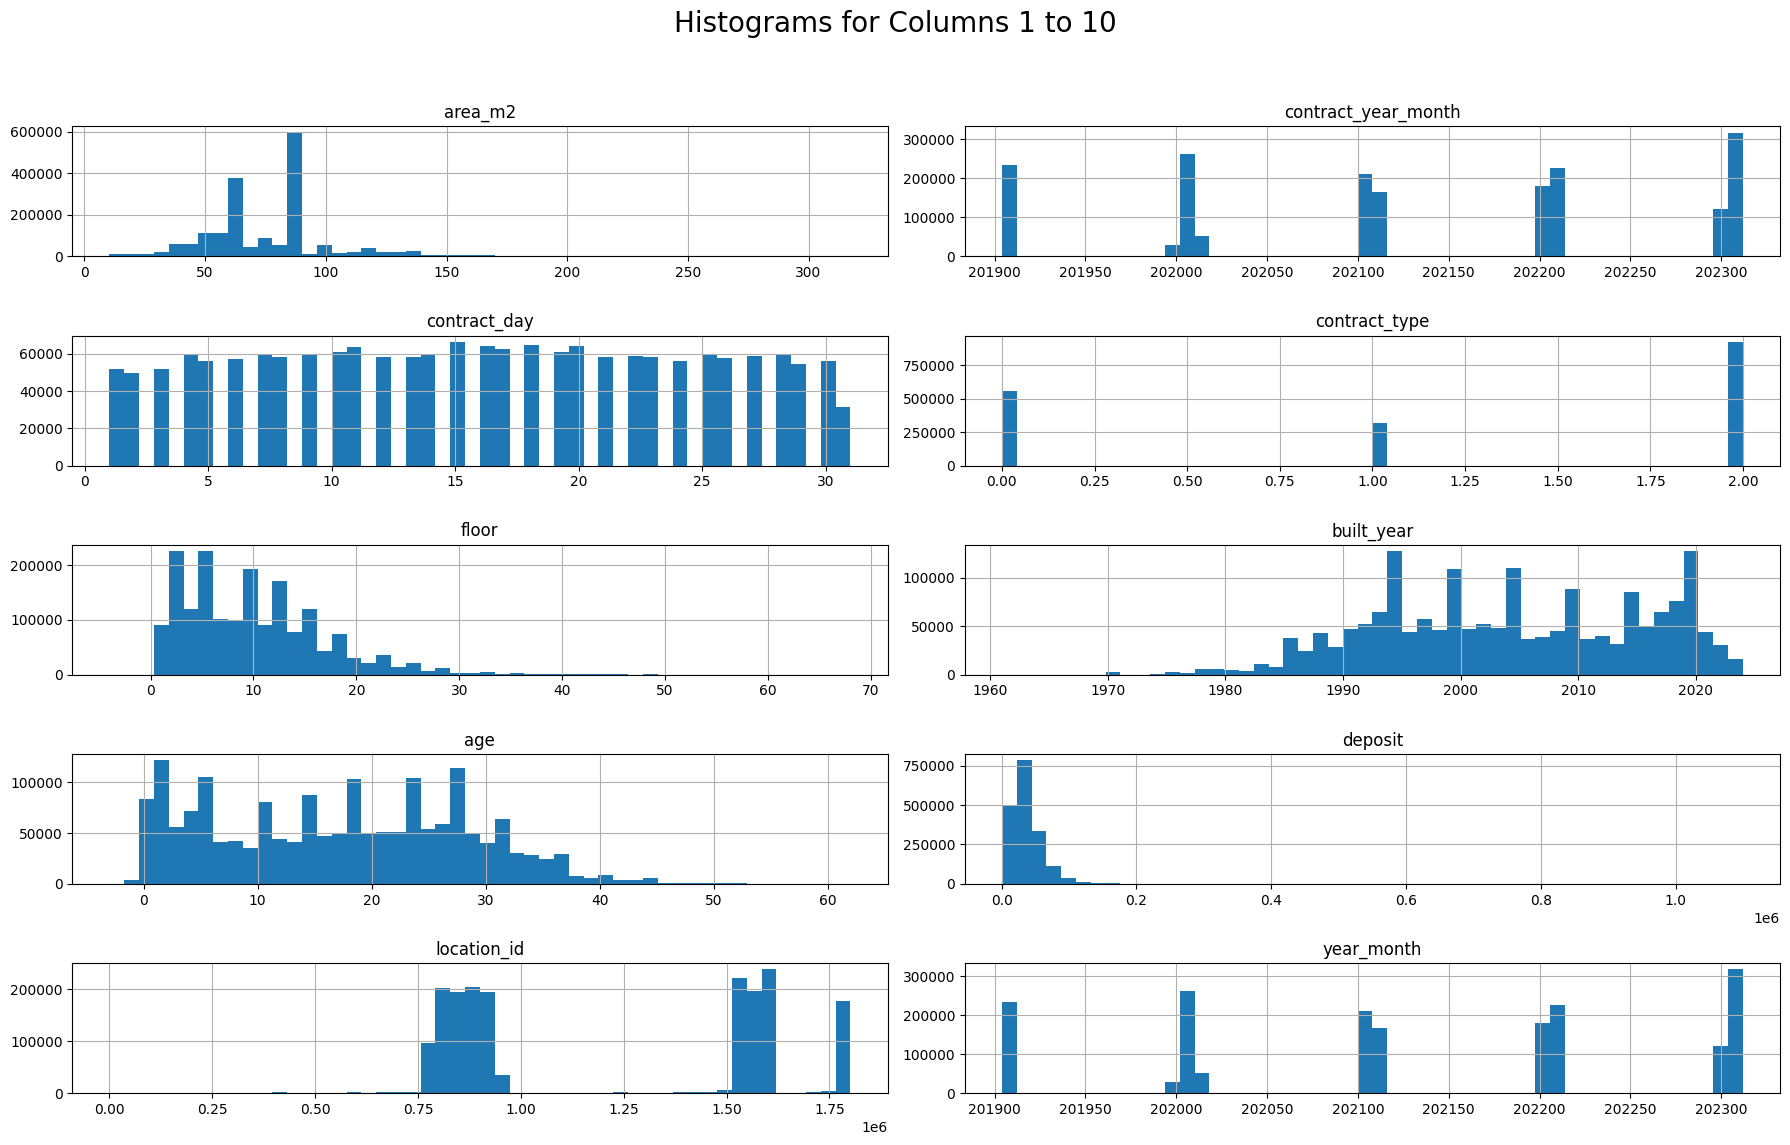

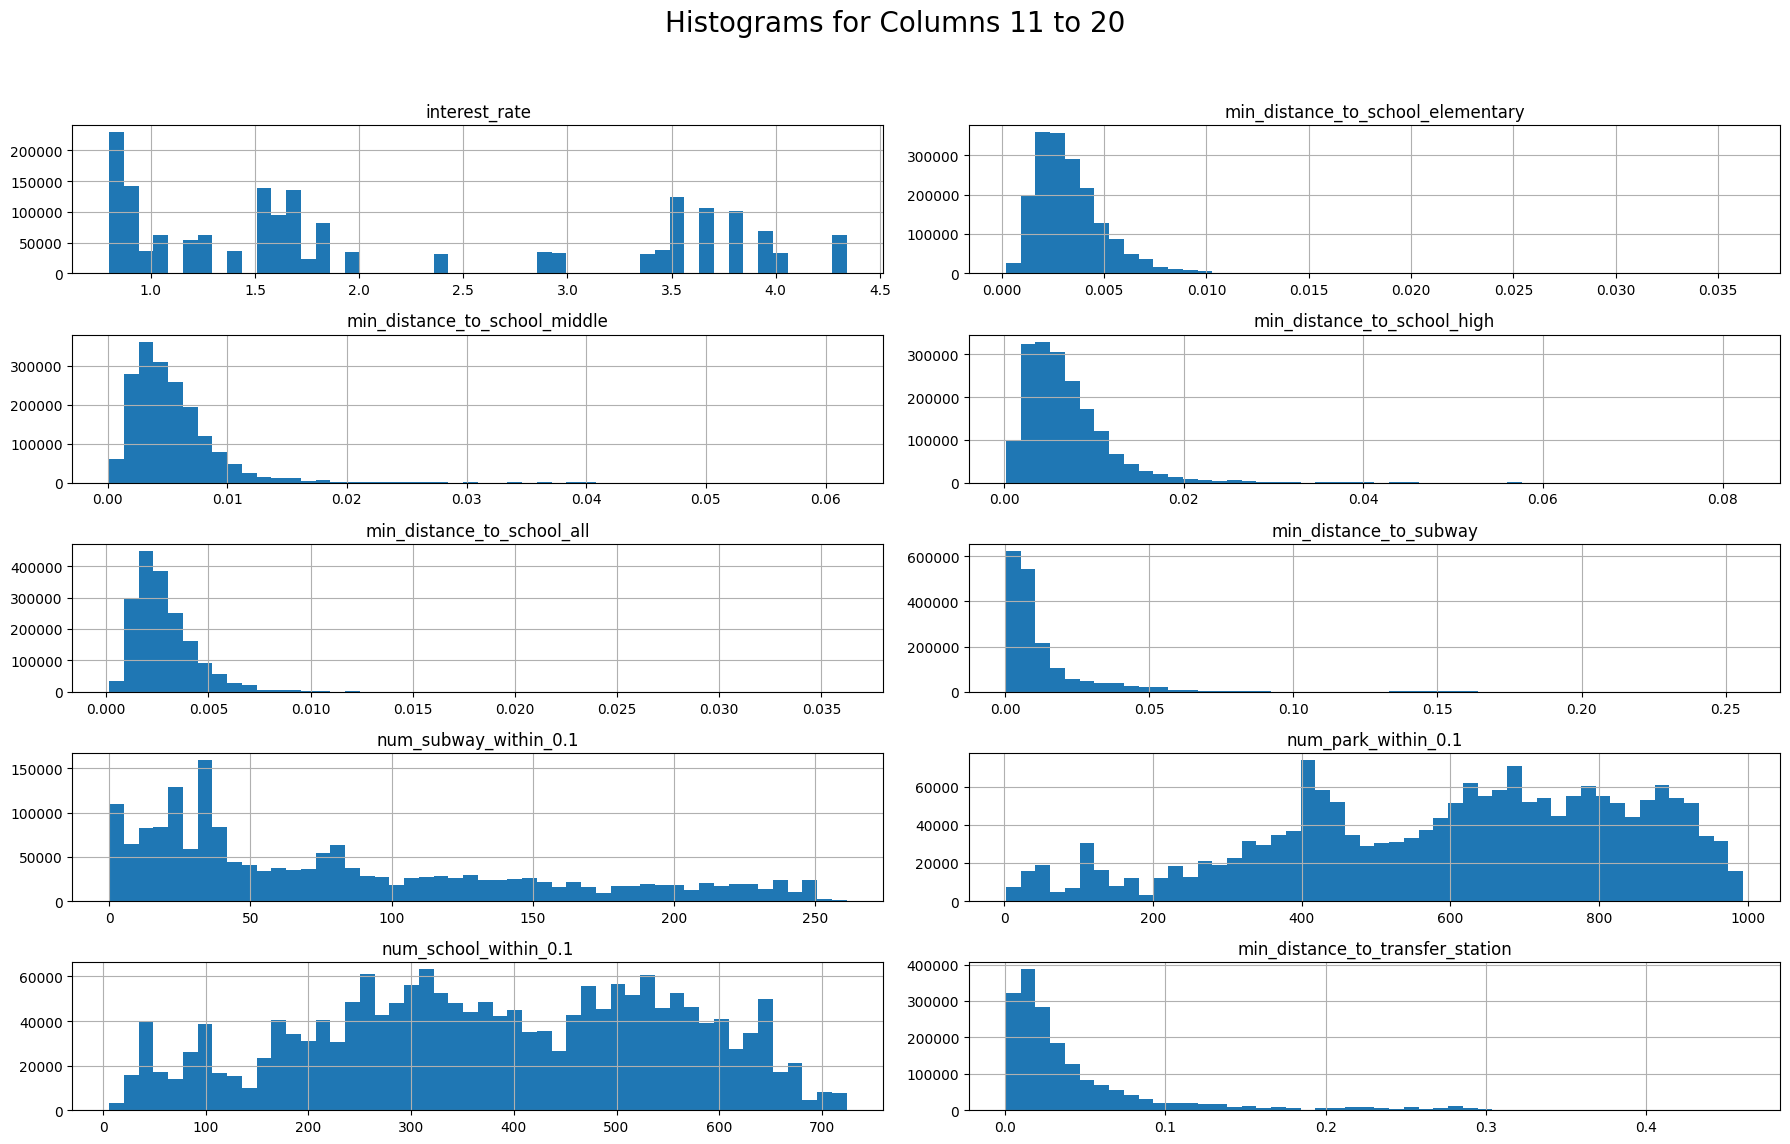

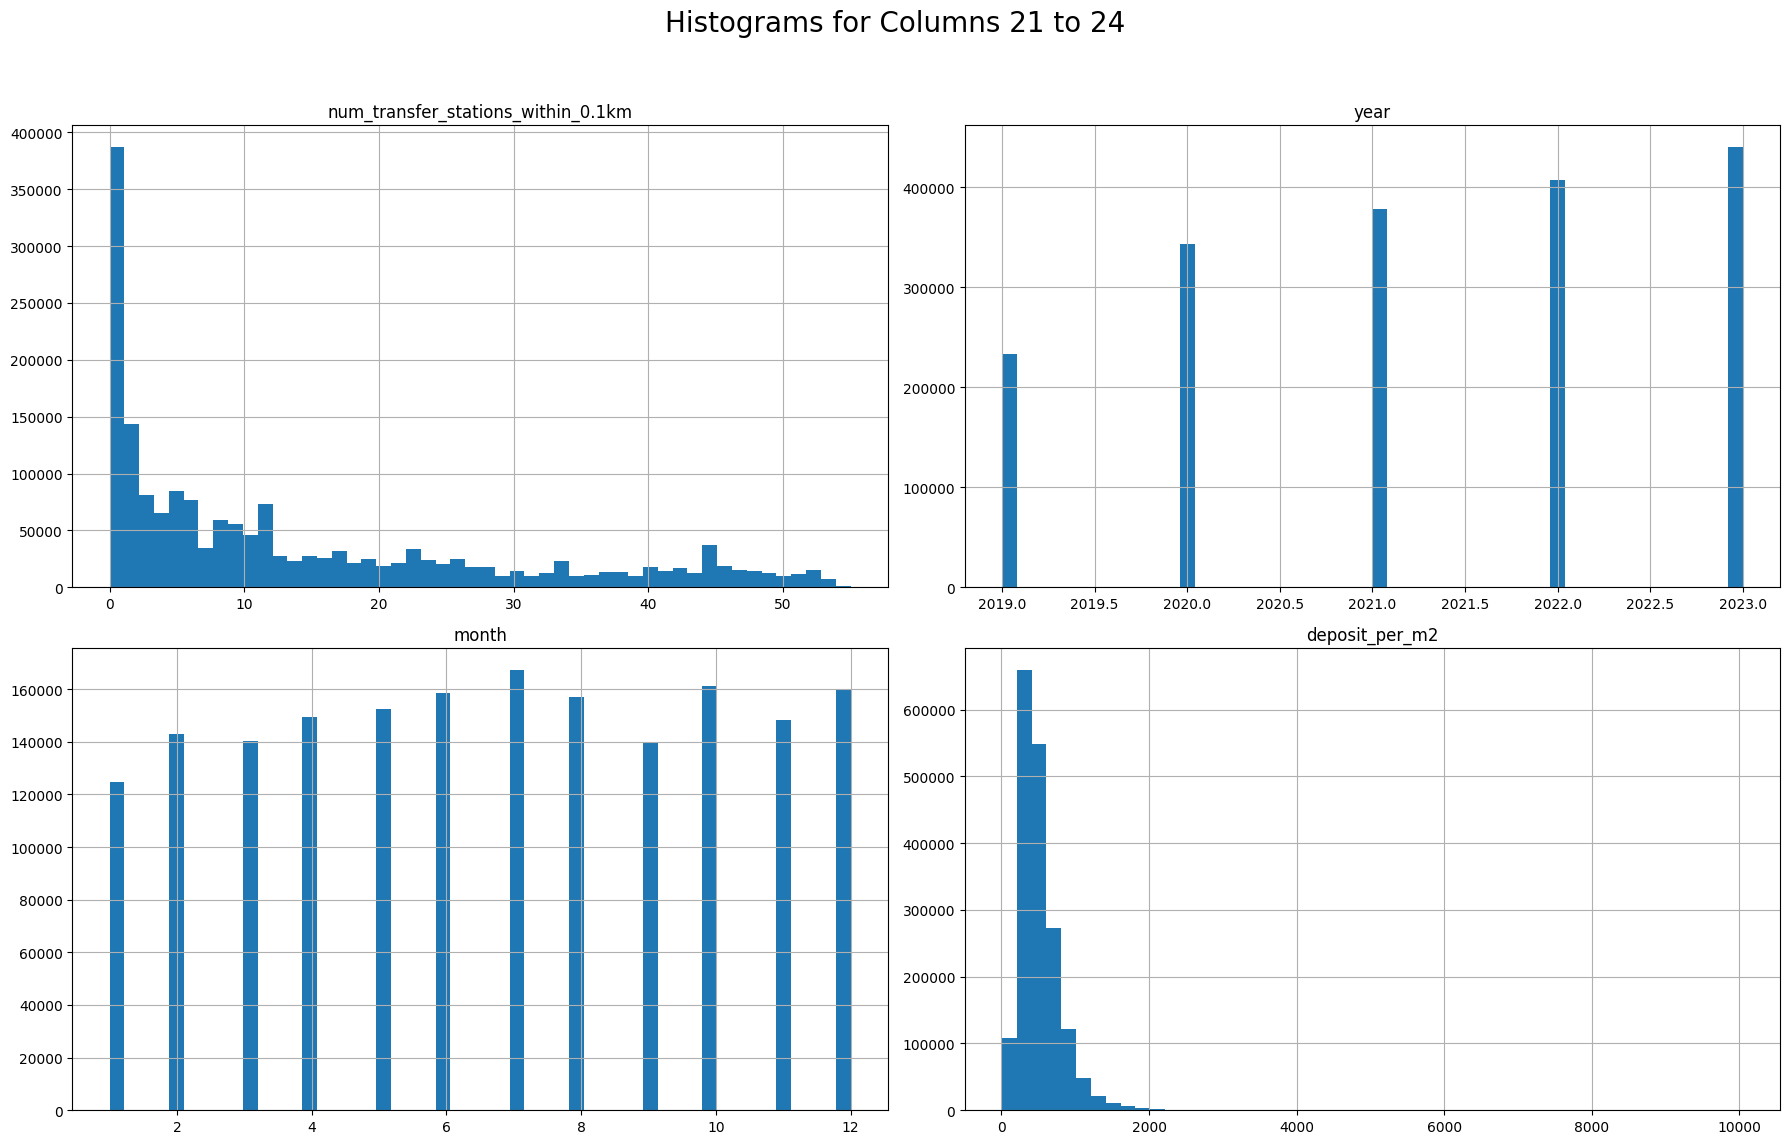

In [15]:
# 총 열 수
total_columns = train_df.columns.drop(['index', 'latitude','longitude'])

colors = plt.cm.get_cmap('tab20', len(total_columns))

# 10개씩 나누어 시각화
for i in range(0, len(total_columns), 10):
    # i부터 i+10까지의 열 선택
    sample_columns = total_columns[i:i + 10]

    # 선택한 열에 대해 히스토그램 생성
    fig, axes = plt.subplots(nrows=len(sample_columns)//2 + len(sample_columns)%2, ncols=2, figsize=(18, 12))
    fig.suptitle(f'Histograms for Columns {i+1} to {i+len(sample_columns)}', fontsize=20)

    for idx, col in enumerate(sample_columns):
        ax = axes.flatten()[idx]
        train_df[col].hist(bins=50, ax=ax)
        ax.set_title(col, fontsize=12)
        ax.tick_params(axis='x', labelsize=10)
        ax.tick_params(axis='y', labelsize=10)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

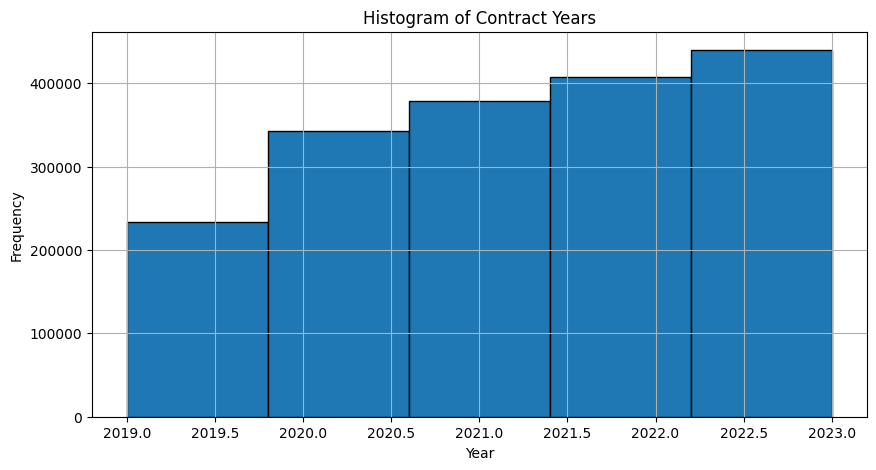

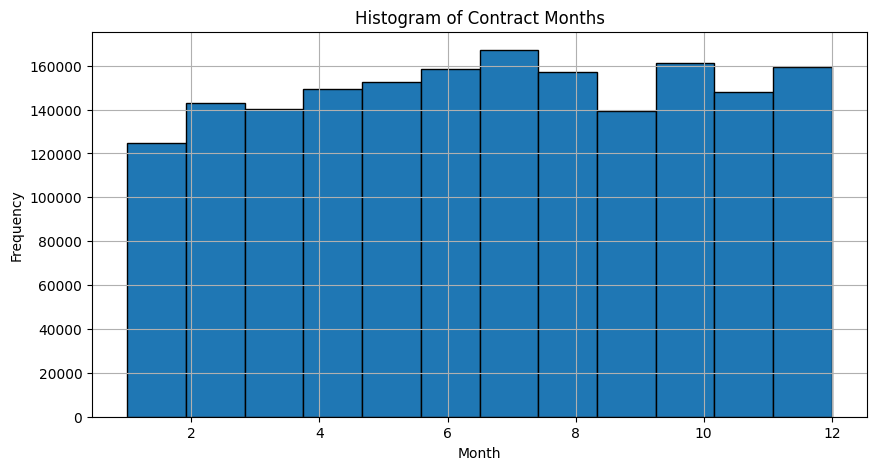

In [16]:
# 연도별 히스토그램
plt.figure(figsize=(10, 5))
plt.hist(train_df['year'], bins=len(train_df['year'].unique()), edgecolor='black')
plt.title('Histogram of Contract Years')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 월별 히스토그램
plt.figure(figsize=(10, 5))
plt.hist(train_df['month'], bins=12, edgecolor='black')
plt.title('Histogram of Contract Months')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

- 전반적으로 좌측에 분포하는 것을 알 수 있다.
- 계약 연월과 계약일은 고른 분포를 나타내고 있다.
- 계약 타입에서는 모름 > 신규 > 갱신의 순서를 보이고 있다.

## 1-3. 이상치

In [17]:
train_df['floor'].value_counts().sort_index()

floor
-4      1
-3      1
-2      8
-1     57
 0      3
       ..
 64     1
 65     2
 66     2
 67     1
 68     4
Name: count, Length: 73, dtype: int64

In [18]:
train_df['age'].value_counts().sort_index()

age
-3         4
-2        28
-1      3419
 0     83870
 1     40128
       ...  
 58        2
 59        2
 60        5
 61        5
 62        5
Name: count, Length: 66, dtype: int64

In [19]:
train_df['built_year'].value_counts().sort_index()

built_year
1961       17
1965       15
1966       11
1967       17
1968      116
        ...  
2020    51176
2021    43894
2022    31119
2023    16483
2024       97
Name: count, Length: 61, dtype: int64

In [20]:
train_df['contract_year_month'].value_counts().sort_index()

contract_year_month
201904    22136
201905    22860
201906    23533
201907    25951
201908    25862
          ...  
202308    34908
202309    33218
202310    35878
202311    32931
202312    33984
Name: count, Length: 57, dtype: int64

- 건물의 나이가 음수값을 가지는 것들이 존재한다
- 2023년까지의 데이터를 사용함에도 건설년도가 2024년인 아파트가 있다.
- 거래연도에는 이상치가 없었다.

## 1-4. 변수별 타겟값

In [21]:
train_df['location_id'].value_counts()

location_id
778941     5108
1523575    3781
1523550    3206
1523527    2832
1523541    2705
           ... 
1380092       1
1376726       1
1375449       1
1374302       1
1798554       1
Name: count, Length: 18491, dtype: int64

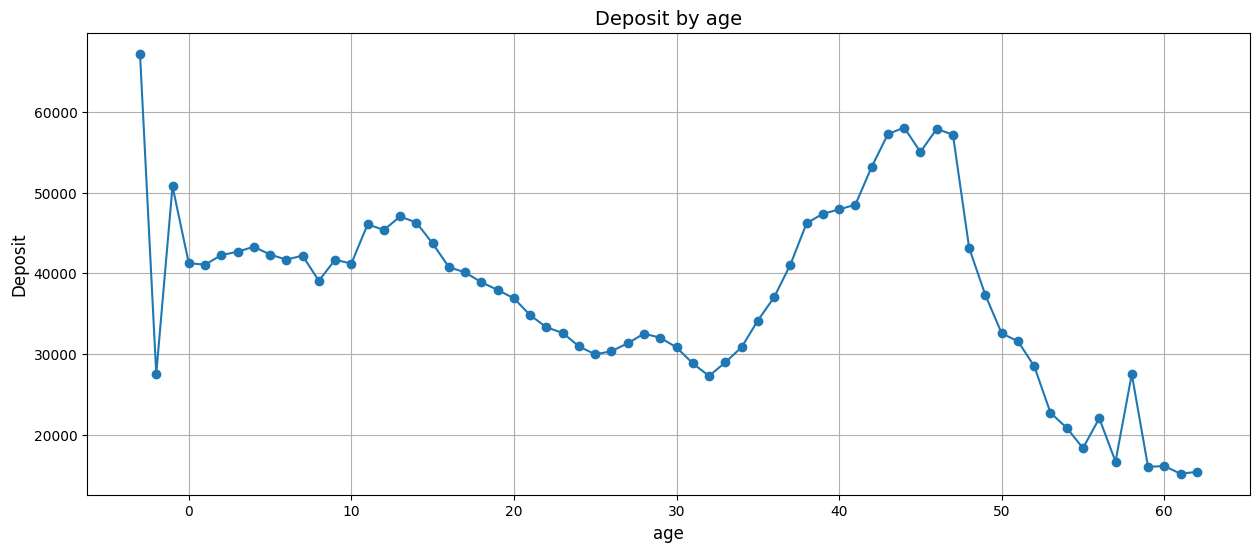

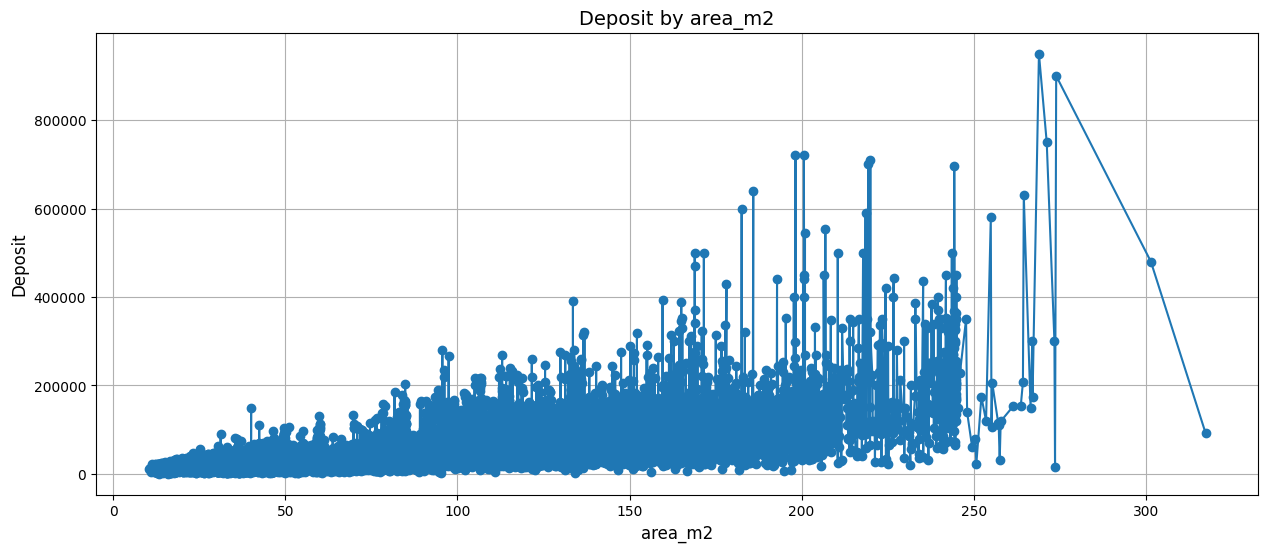

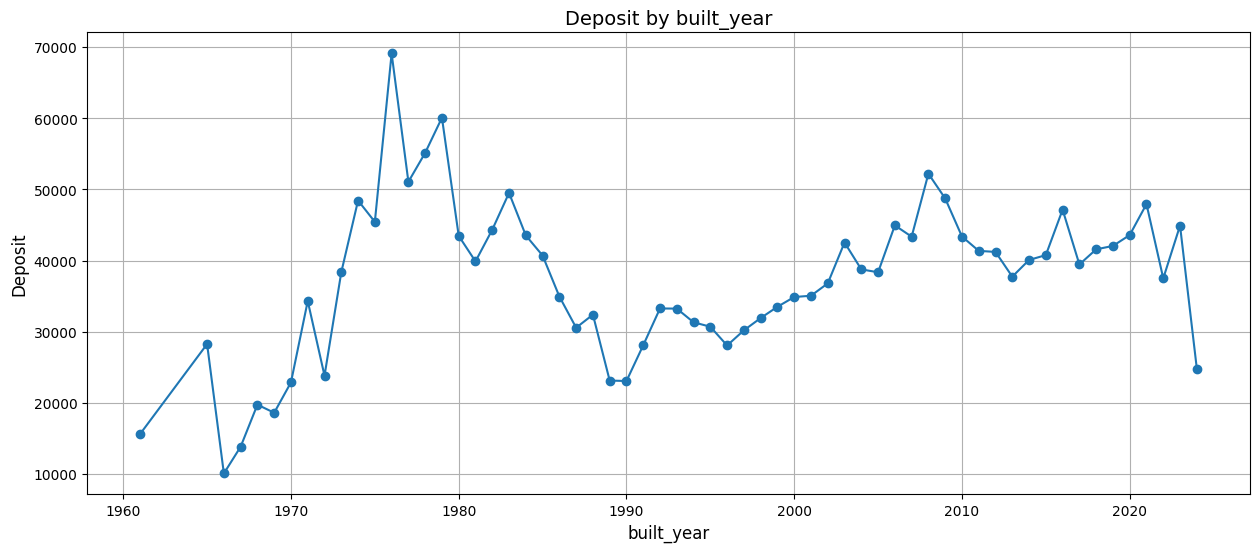

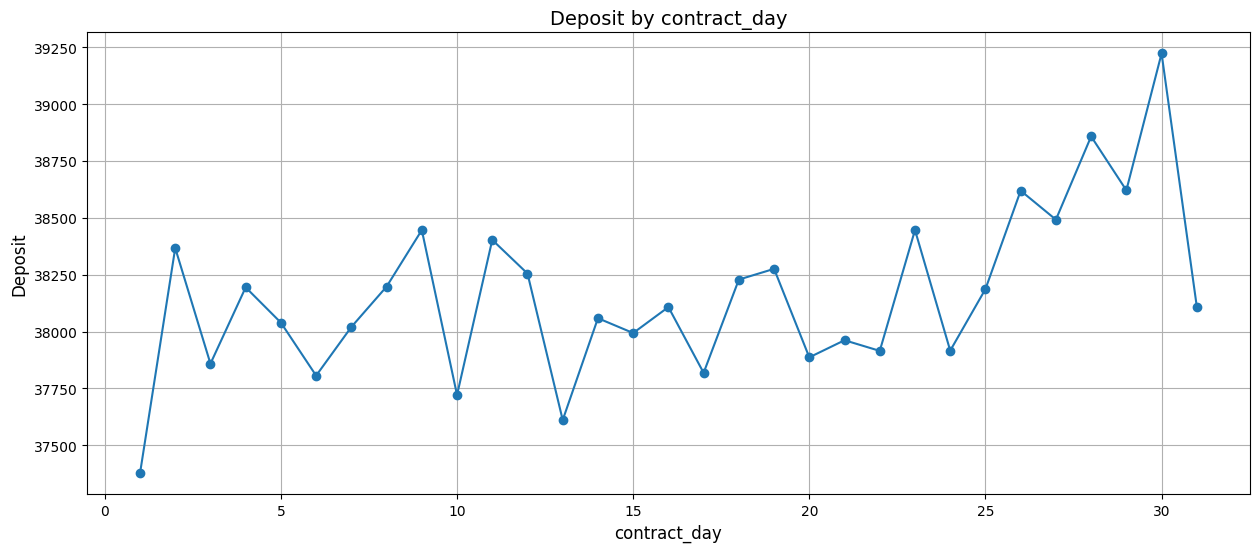

<ipython-input-22-904f0e2b5888>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(variable)['deposit'].mean().plot(marker='o')


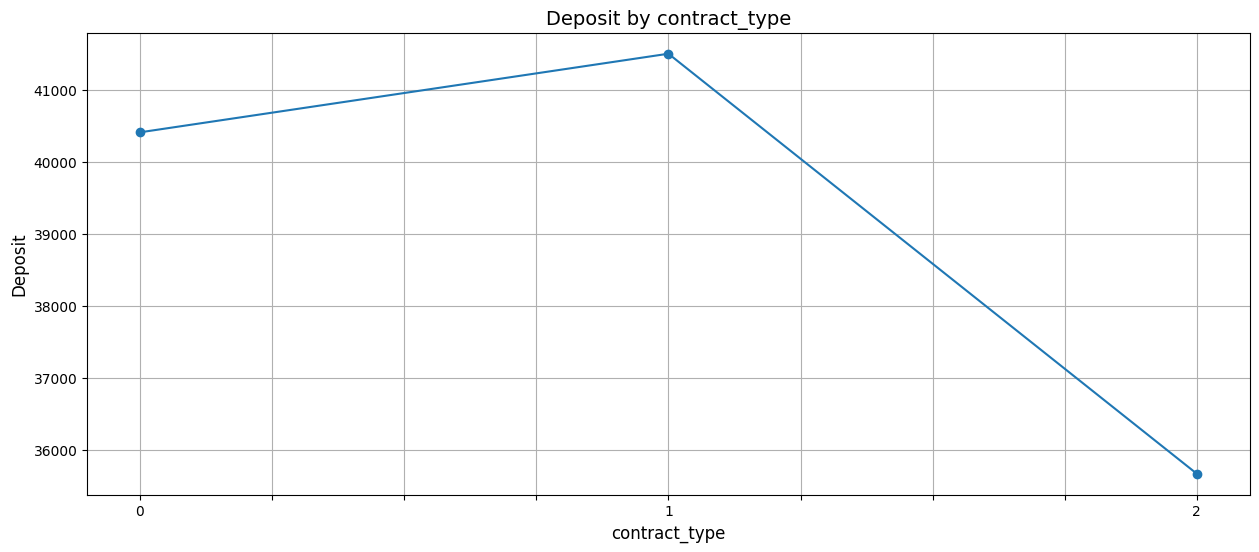

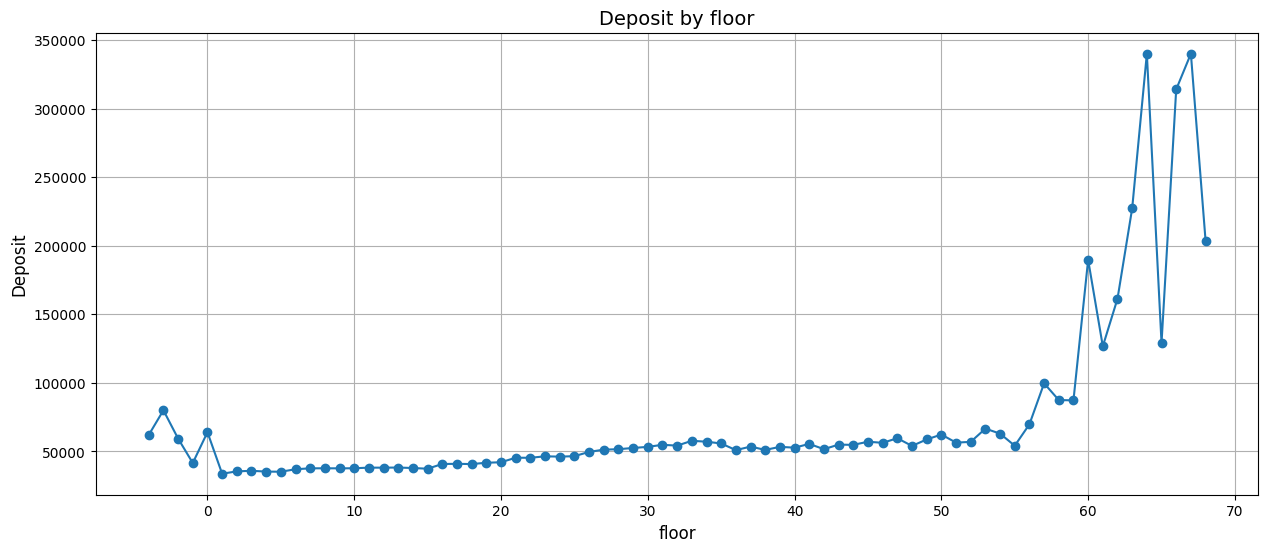

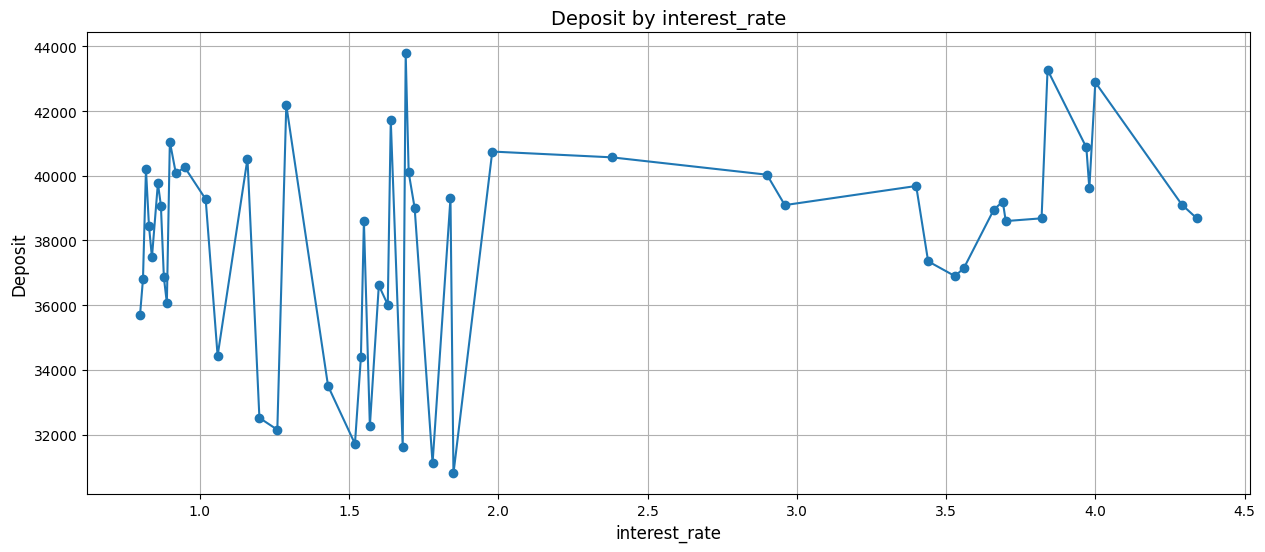

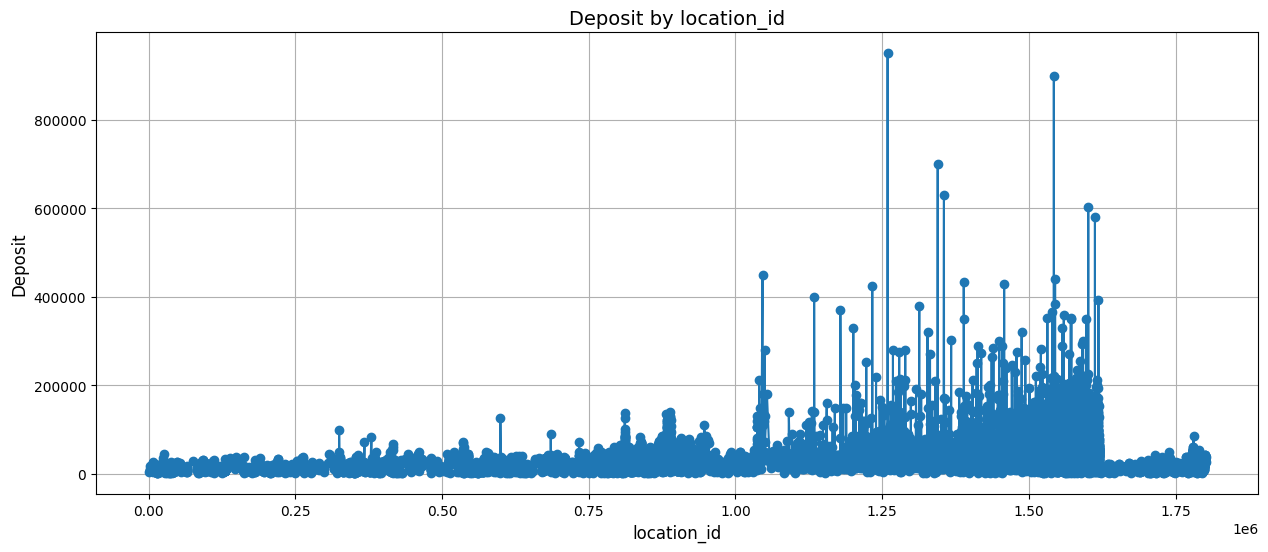

<ipython-input-22-904f0e2b5888>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(variable)['deposit'].mean().plot(marker='o')


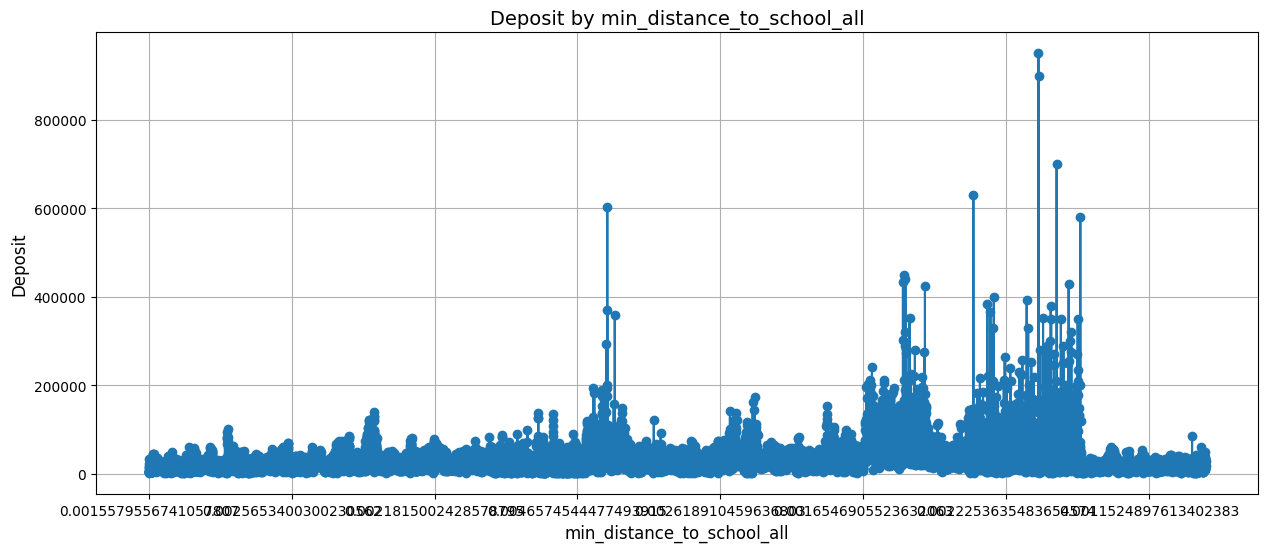

<ipython-input-22-904f0e2b5888>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(variable)['deposit'].mean().plot(marker='o')


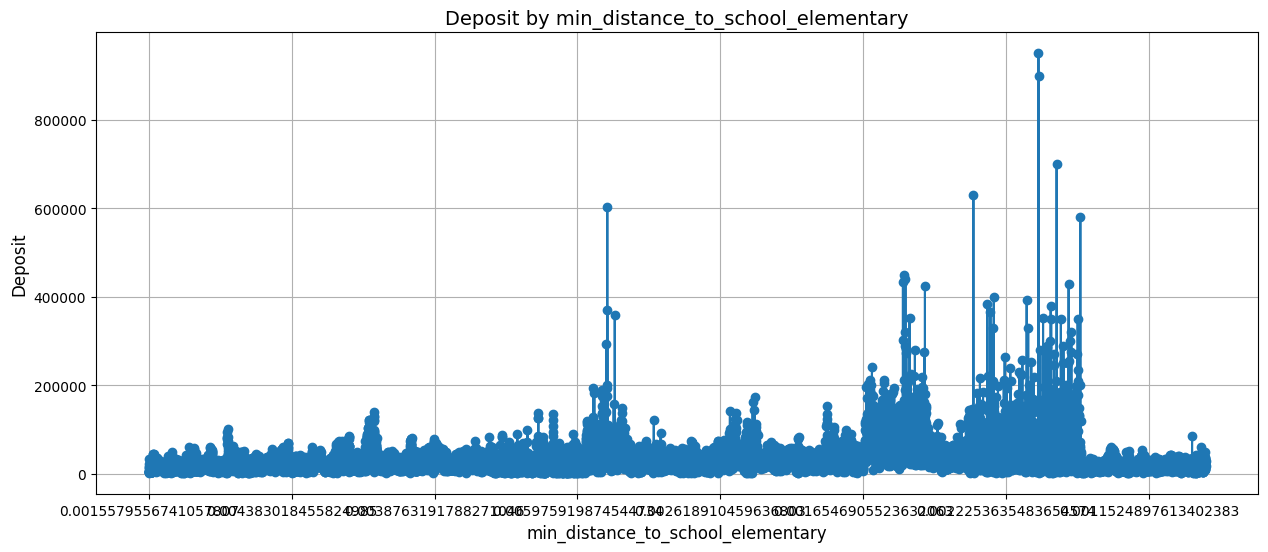

<ipython-input-22-904f0e2b5888>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(variable)['deposit'].mean().plot(marker='o')


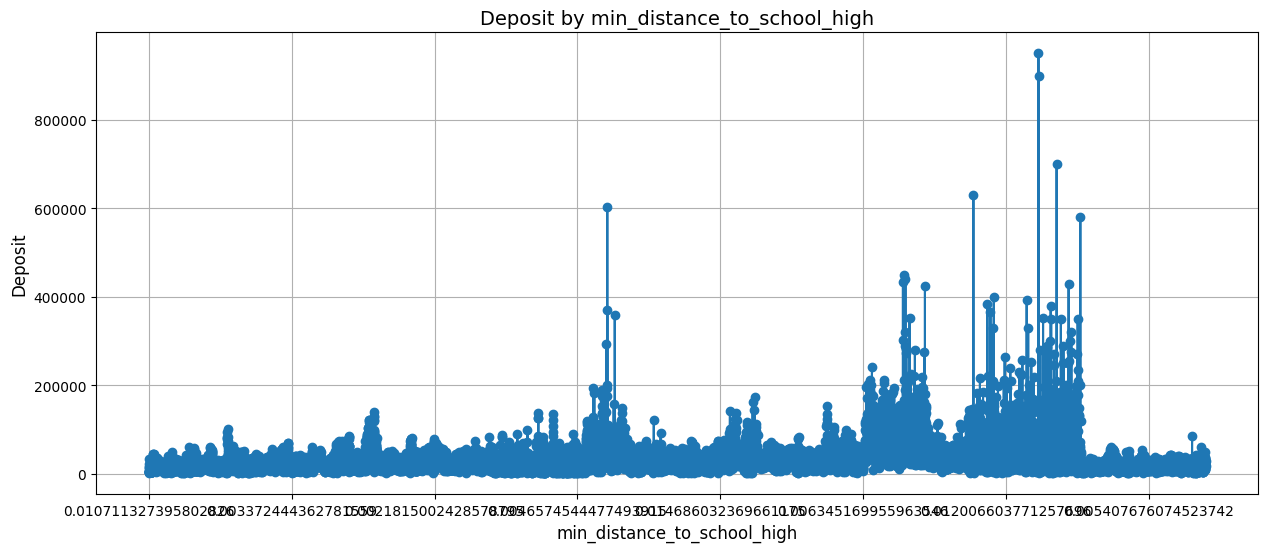

<ipython-input-22-904f0e2b5888>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(variable)['deposit'].mean().plot(marker='o')


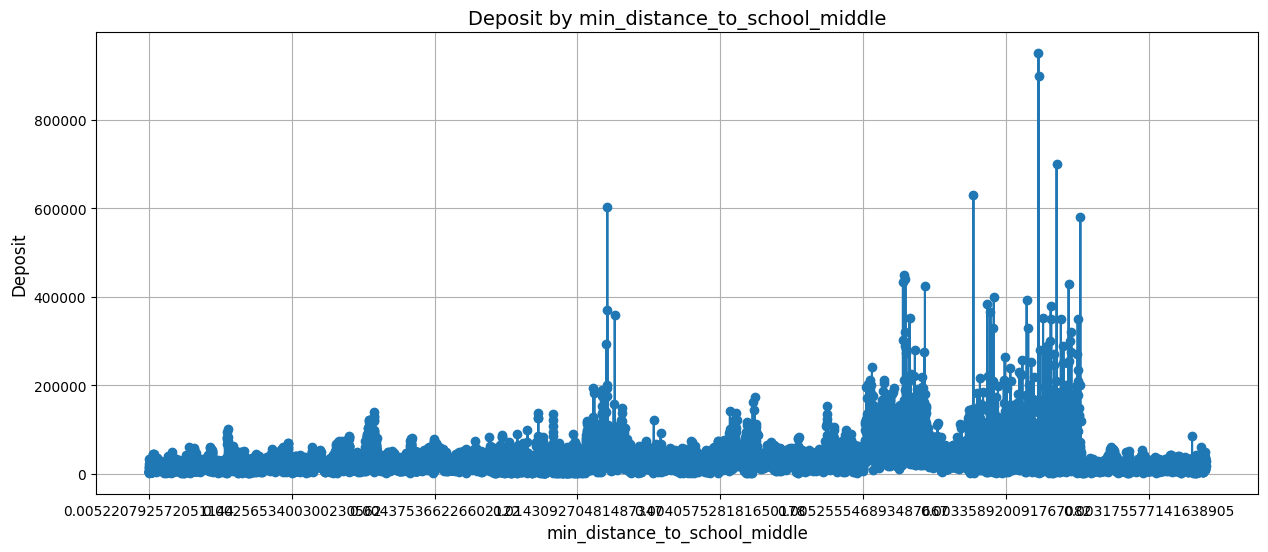

<ipython-input-22-904f0e2b5888>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(variable)['deposit'].mean().plot(marker='o')


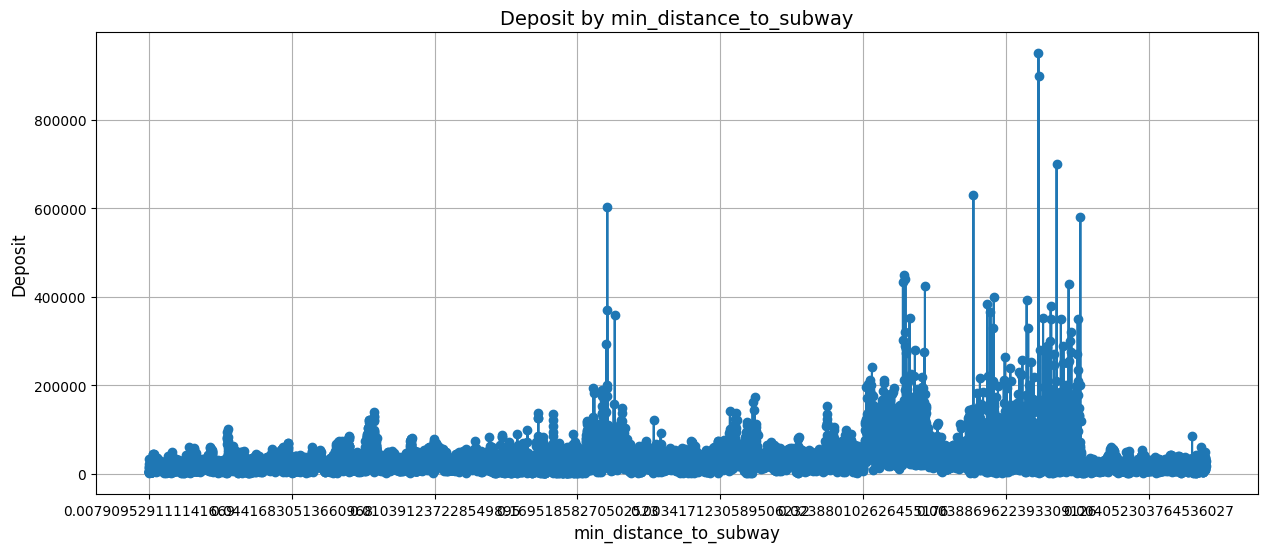

<ipython-input-22-904f0e2b5888>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(variable)['deposit'].mean().plot(marker='o')


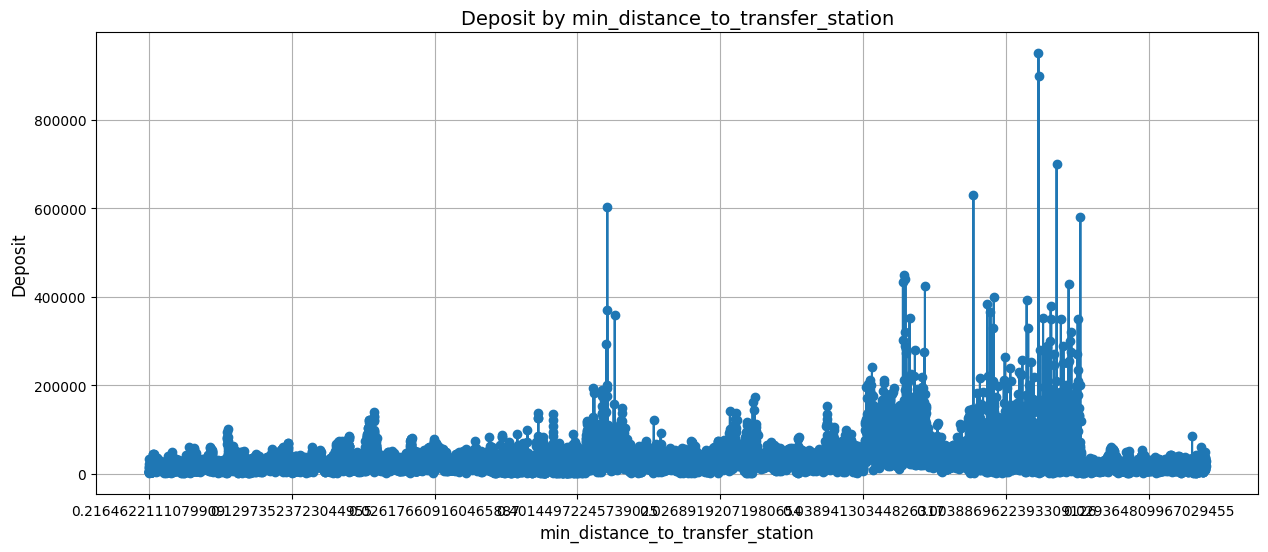

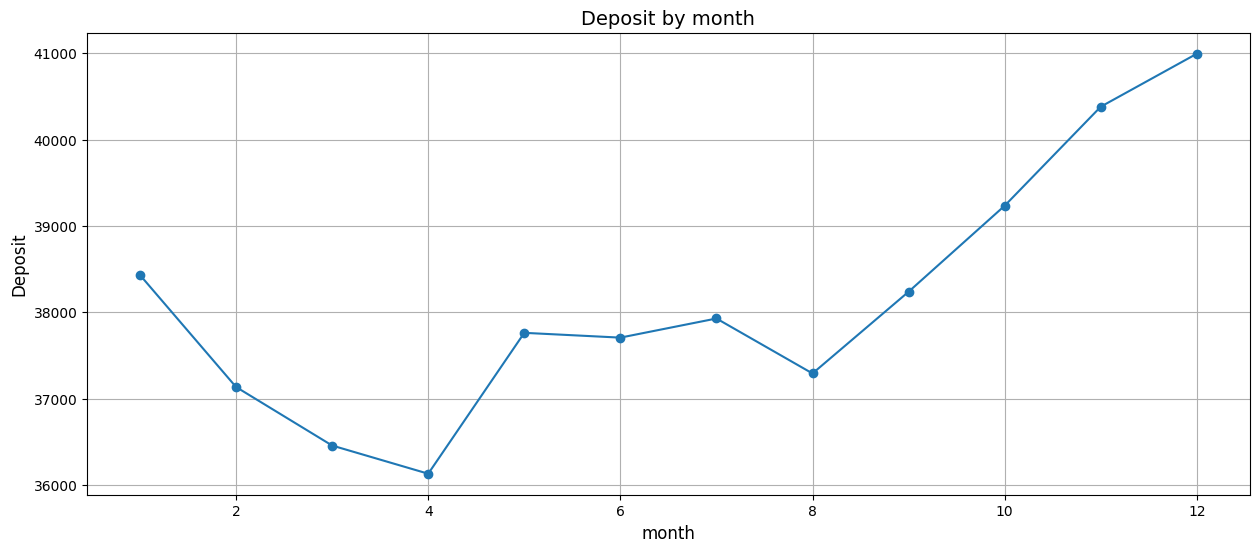

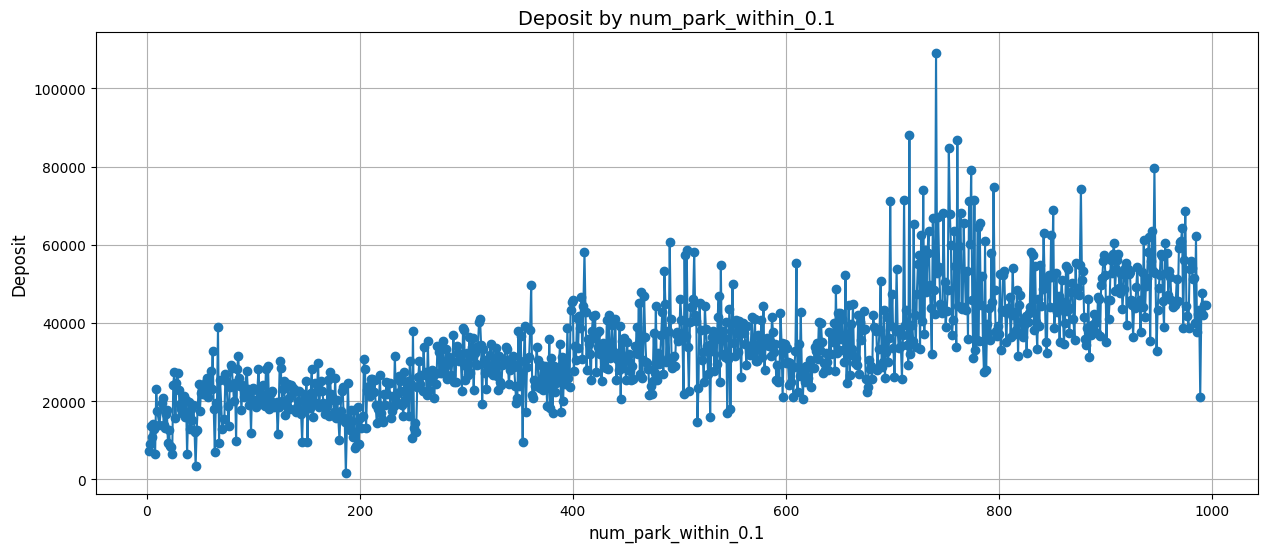

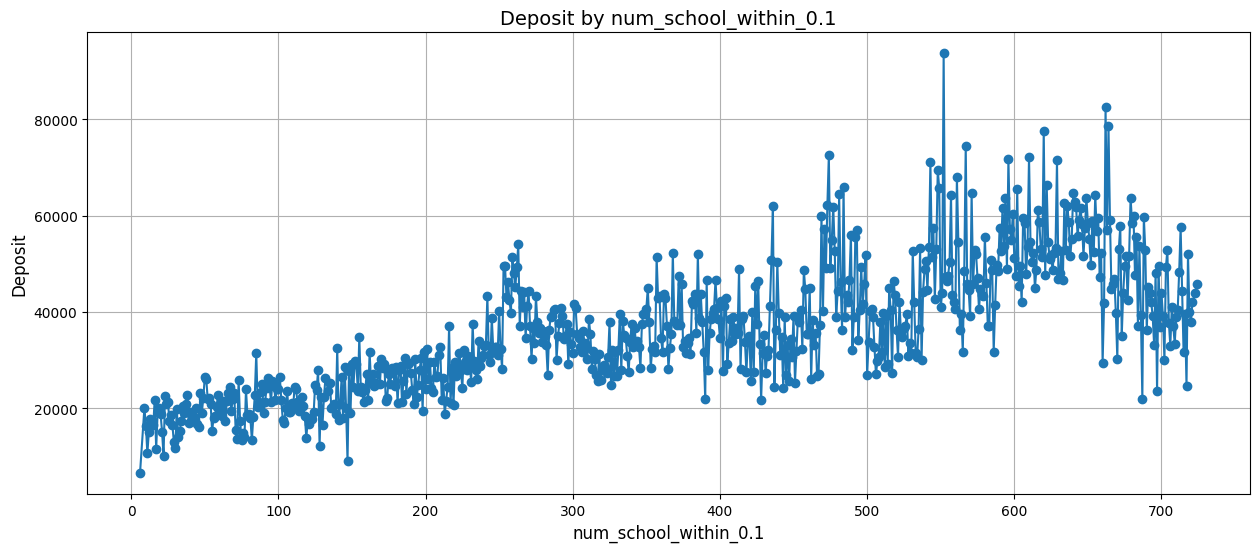

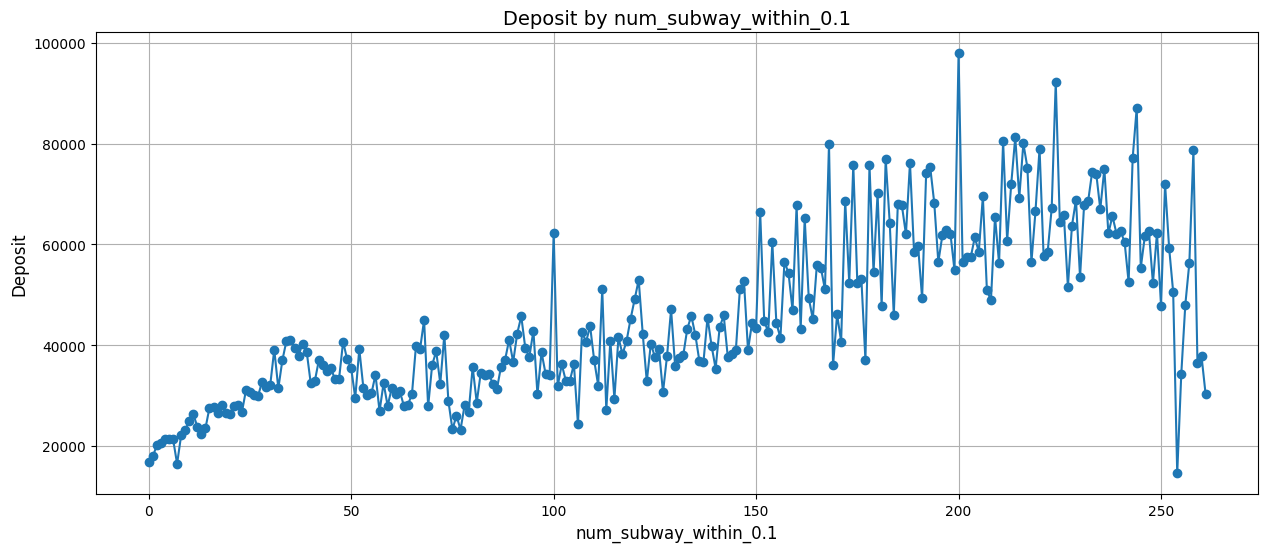

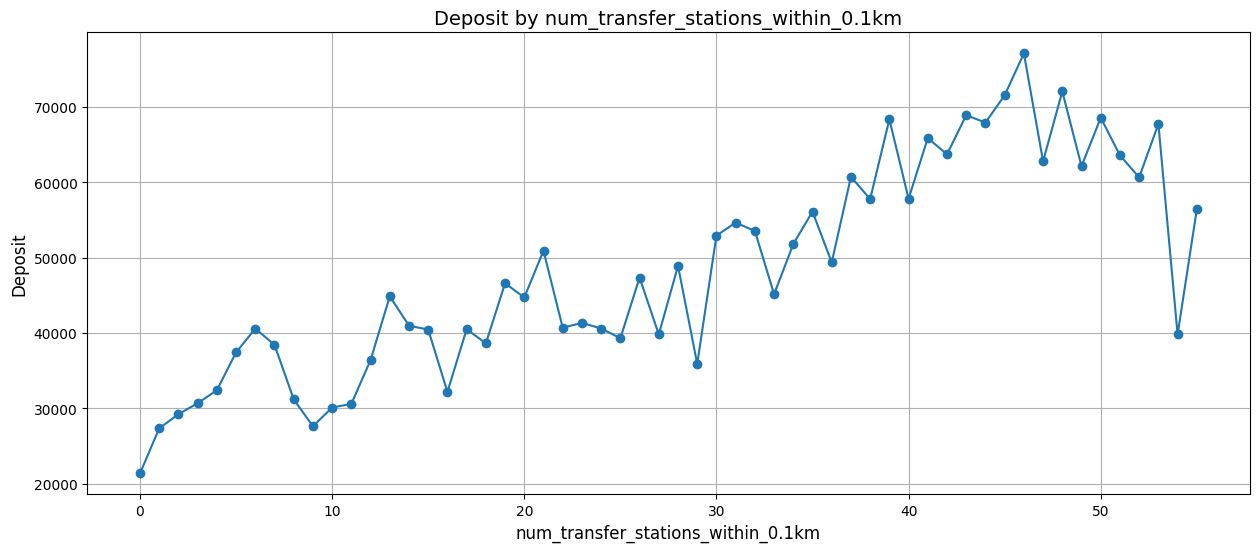

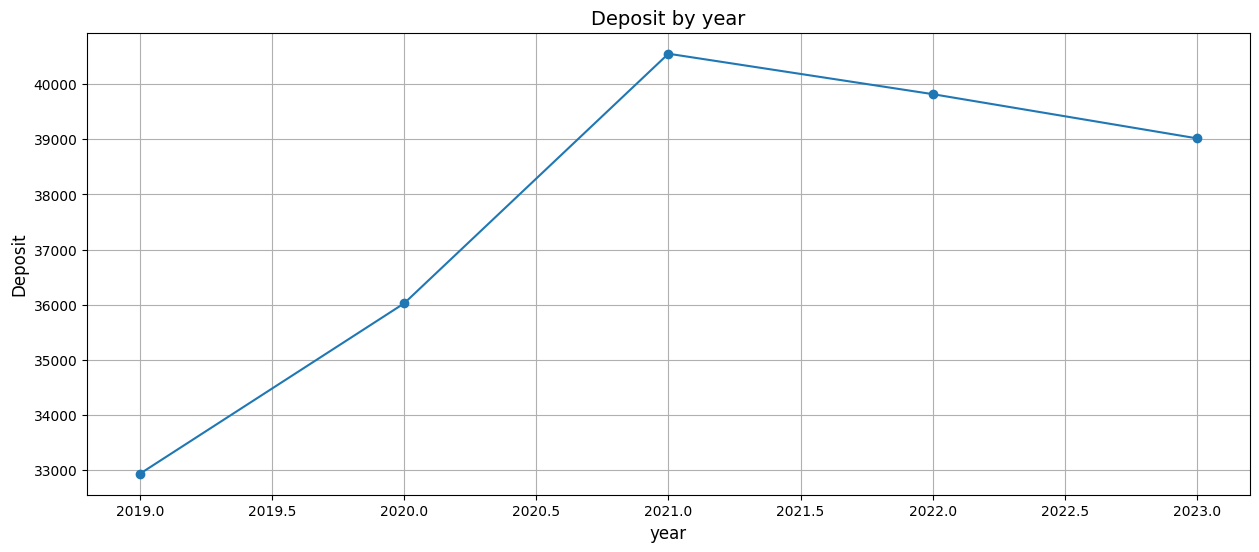

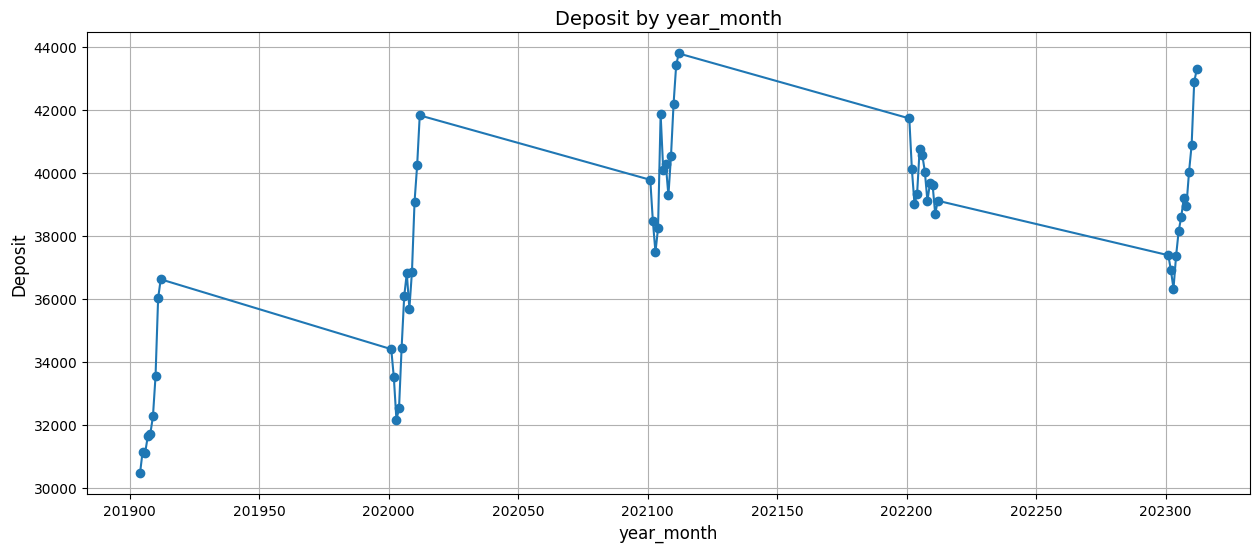

In [22]:
def plot_deposit_by_all_variables(df):
    variables = df.columns.difference(['index','deposit','deposit_per_m2','latitude','longitude','contract_year_month'])
    for variable in variables:
        plt.figure(figsize=(15, 6))
        df.groupby(variable)['deposit'].mean().plot(marker='o')
        plt.title(f'Deposit by {variable}', fontsize=14)
        plt.xlabel(variable, fontsize=12)
        plt.ylabel('Deposit', fontsize=12)
        plt.grid(True)
        plt.show()

plot_deposit_by_all_variables(train_df)

- 2021년에 전세가가 확 오른다.
- 10,11,12월에 전세가가 오른다.
- 56층 이상 정도부터 전세가가 급증한다.
- 갱신 > 신규 > 모름 순으로 전세가가 높다.
- 월말에 가까워지면 전세가가 오른다.
- 아파트의 연식이 40년 이상이 되면 잠깐 가격이 오른다.

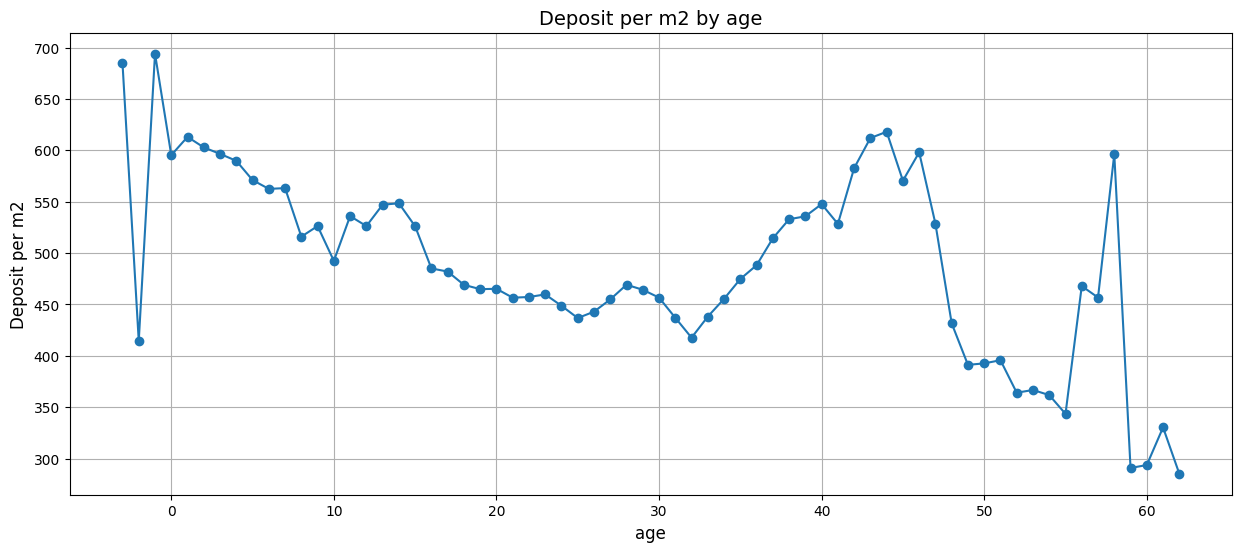

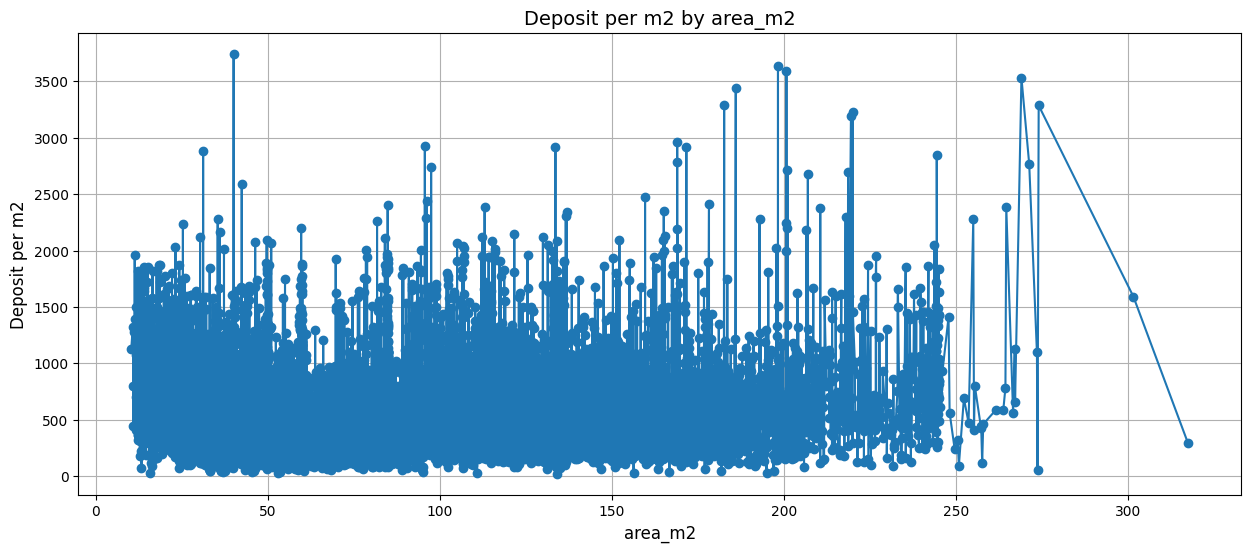

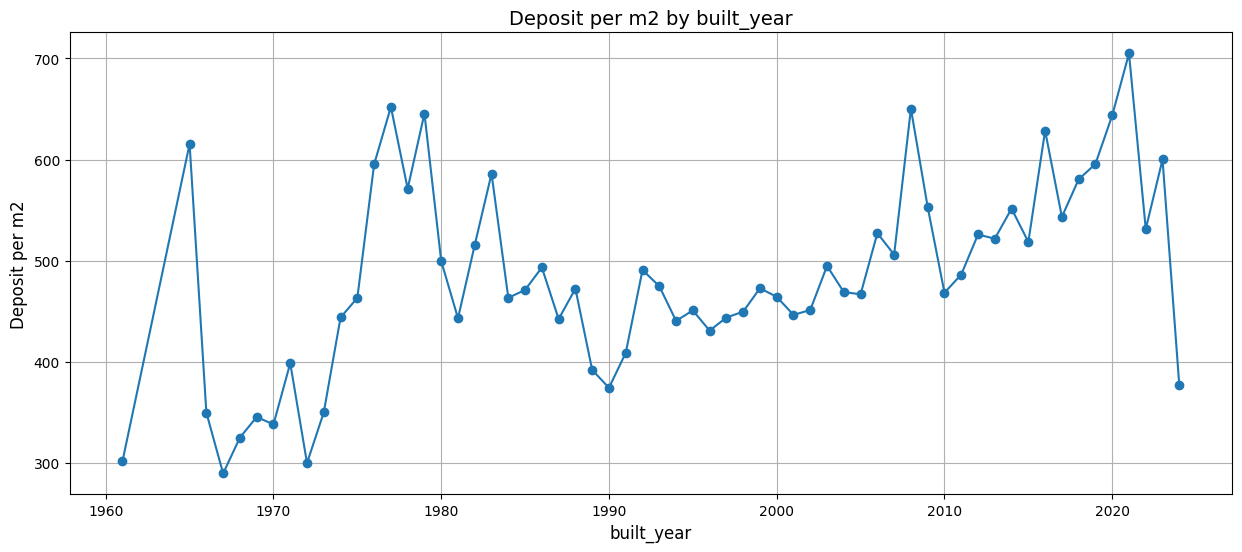

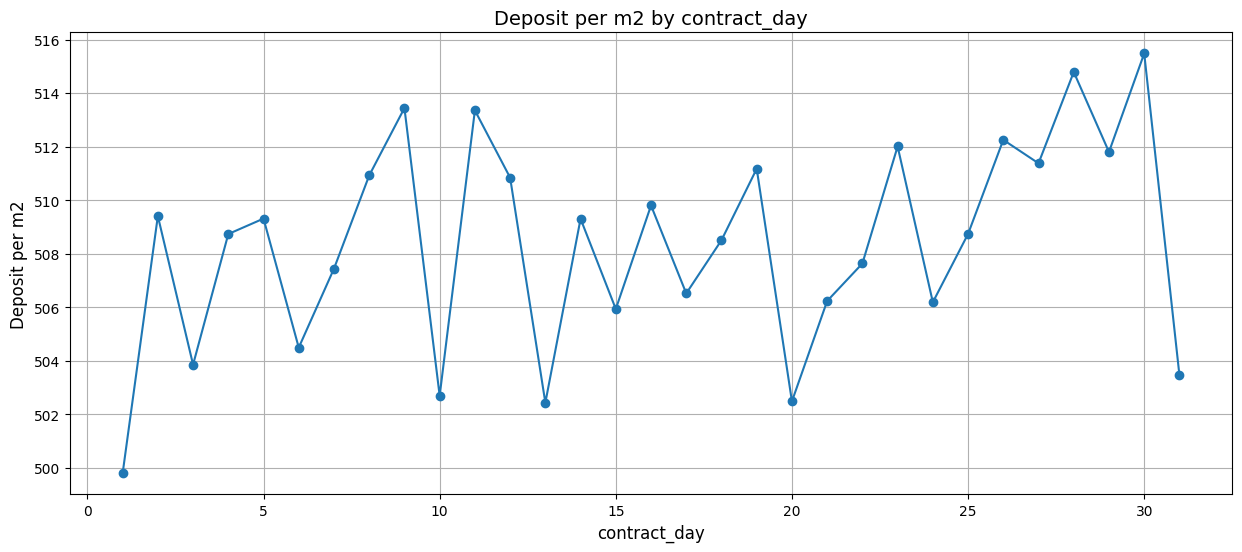

<ipython-input-23-76994e1a6cc2>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(variable)['deposit_per_m2'].mean().plot(marker='o')


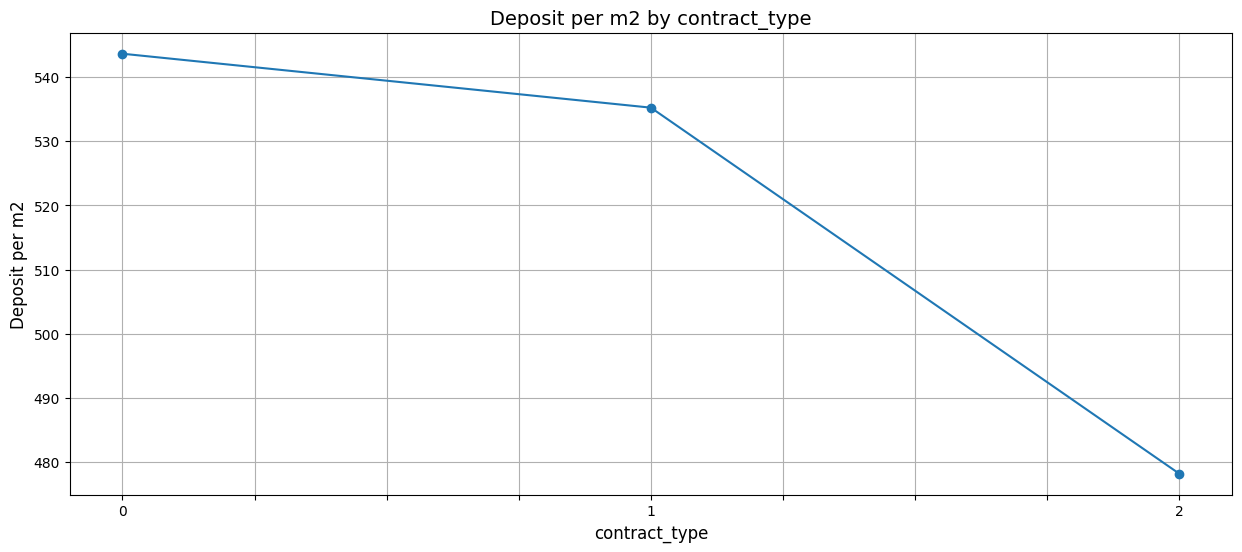

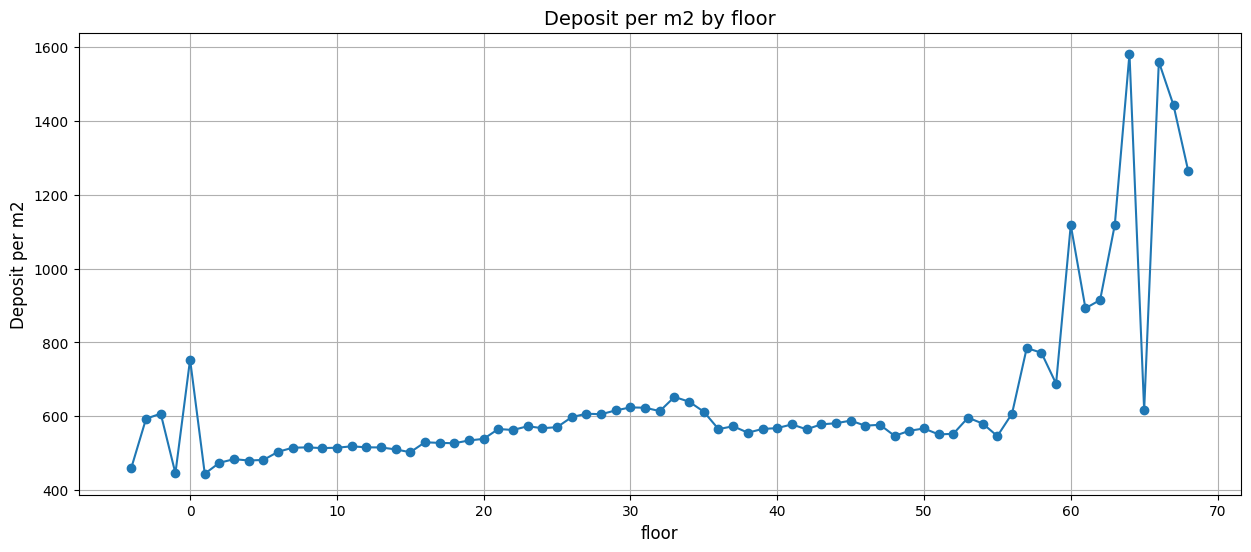

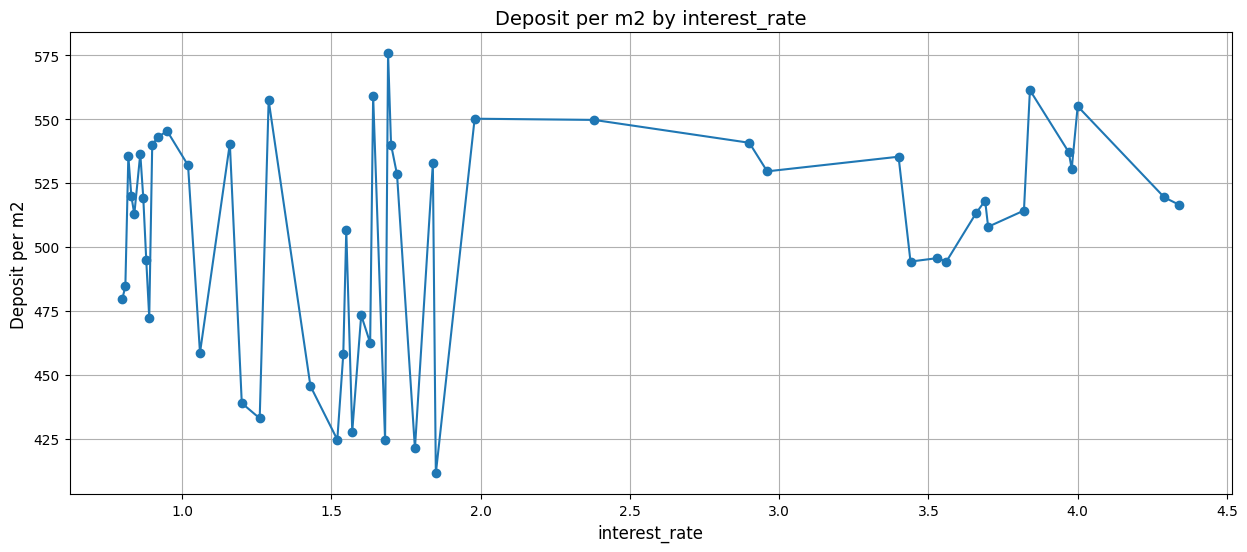

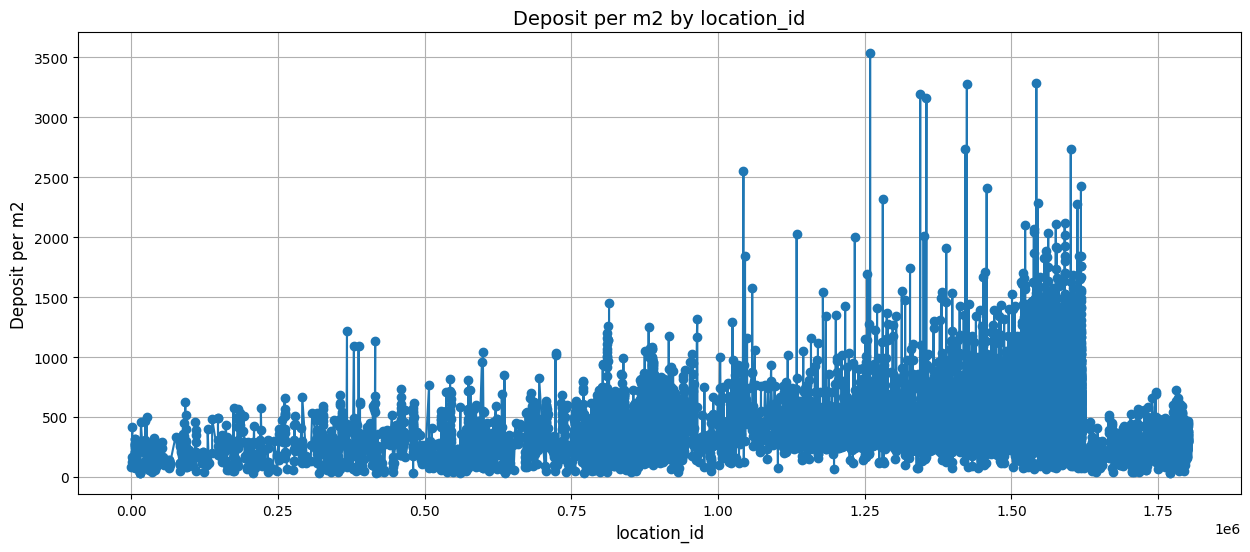

<ipython-input-23-76994e1a6cc2>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(variable)['deposit_per_m2'].mean().plot(marker='o')


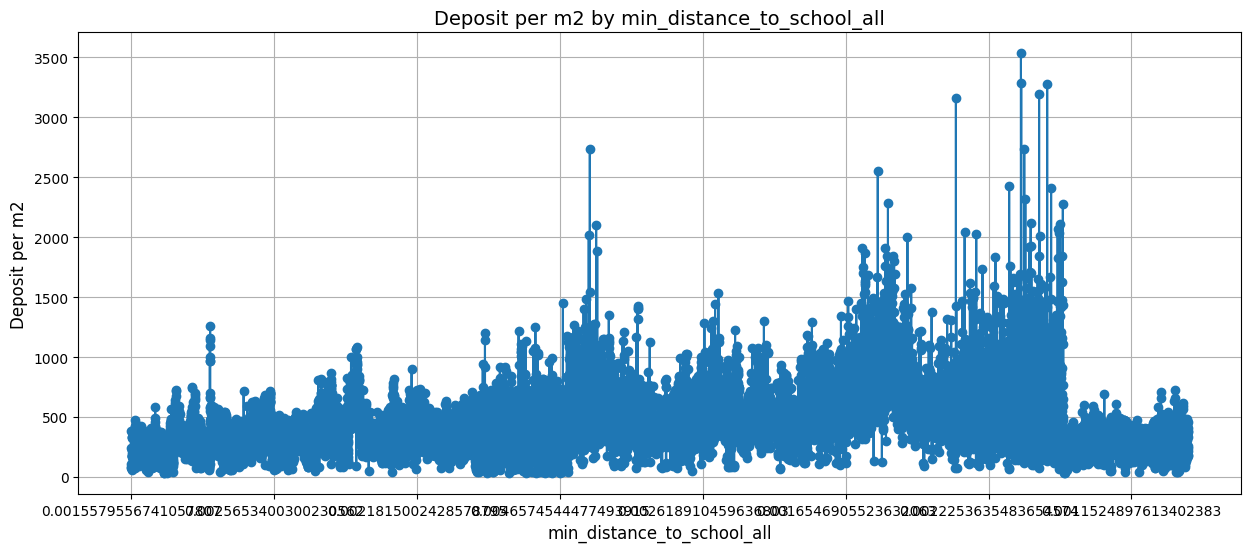

<ipython-input-23-76994e1a6cc2>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(variable)['deposit_per_m2'].mean().plot(marker='o')


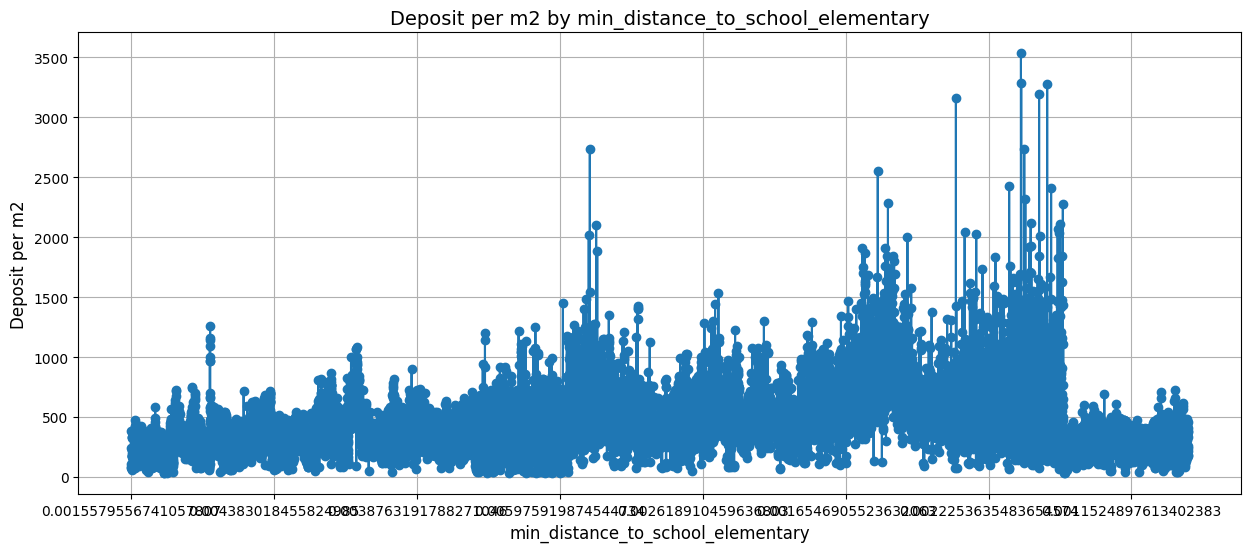

<ipython-input-23-76994e1a6cc2>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(variable)['deposit_per_m2'].mean().plot(marker='o')


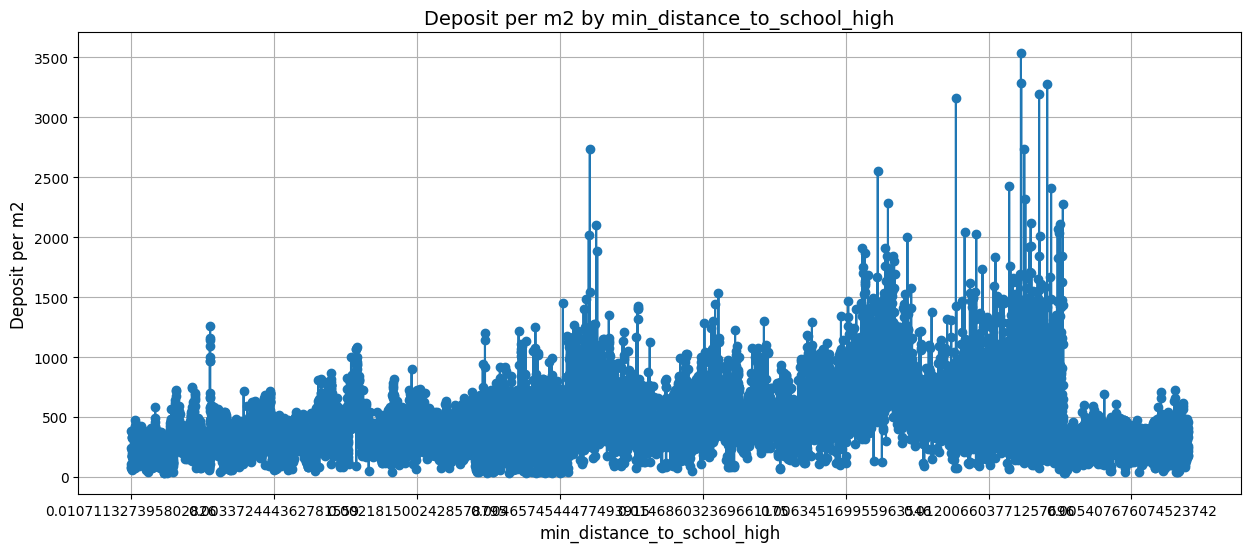

<ipython-input-23-76994e1a6cc2>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(variable)['deposit_per_m2'].mean().plot(marker='o')


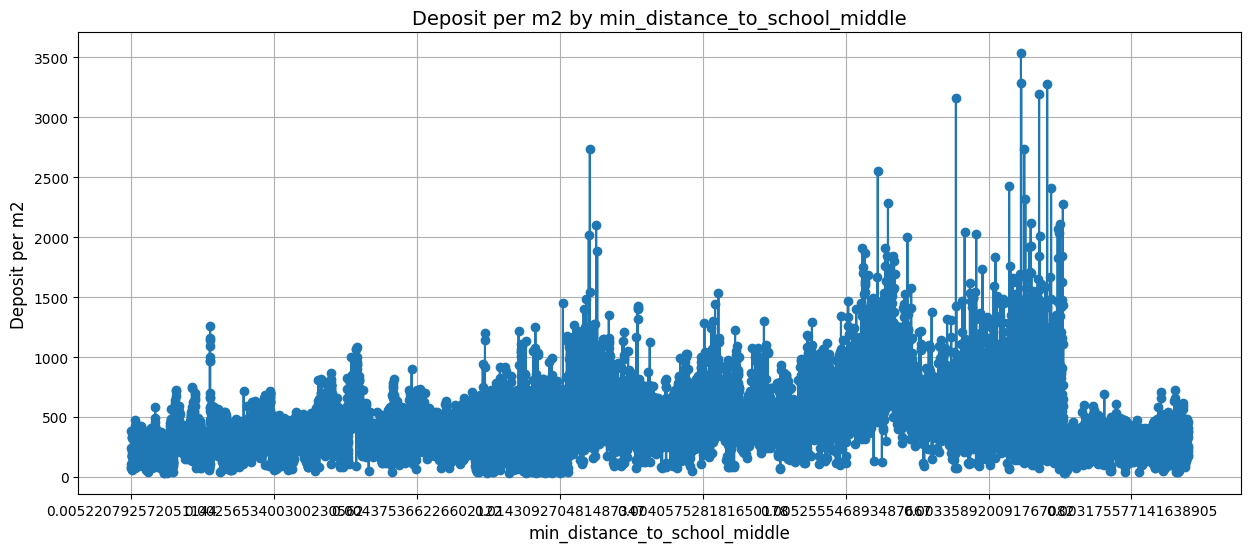

<ipython-input-23-76994e1a6cc2>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(variable)['deposit_per_m2'].mean().plot(marker='o')


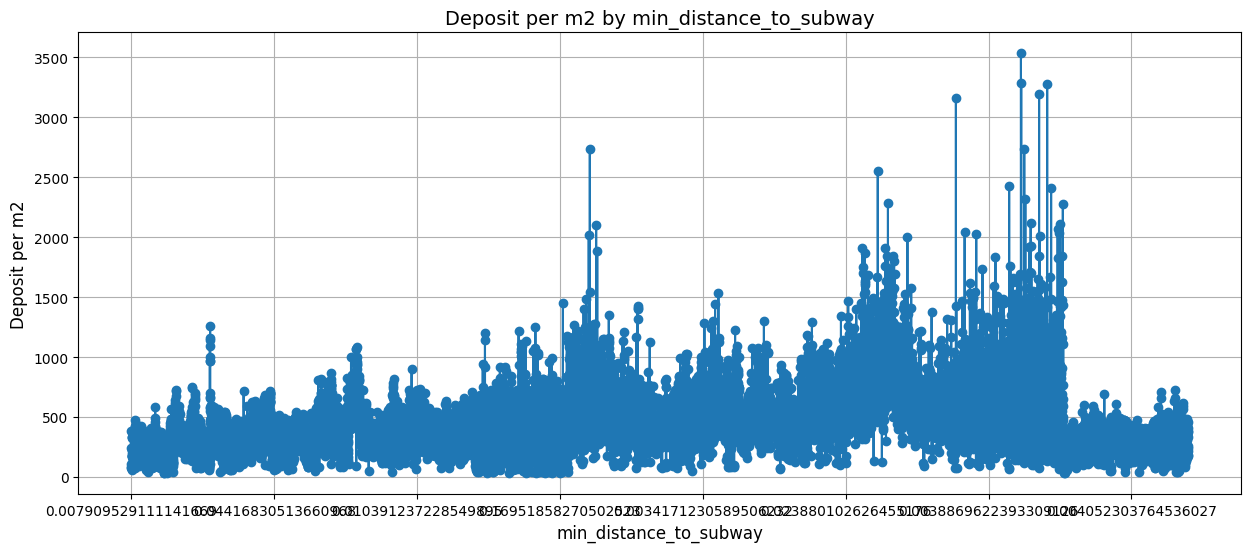

<ipython-input-23-76994e1a6cc2>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(variable)['deposit_per_m2'].mean().plot(marker='o')


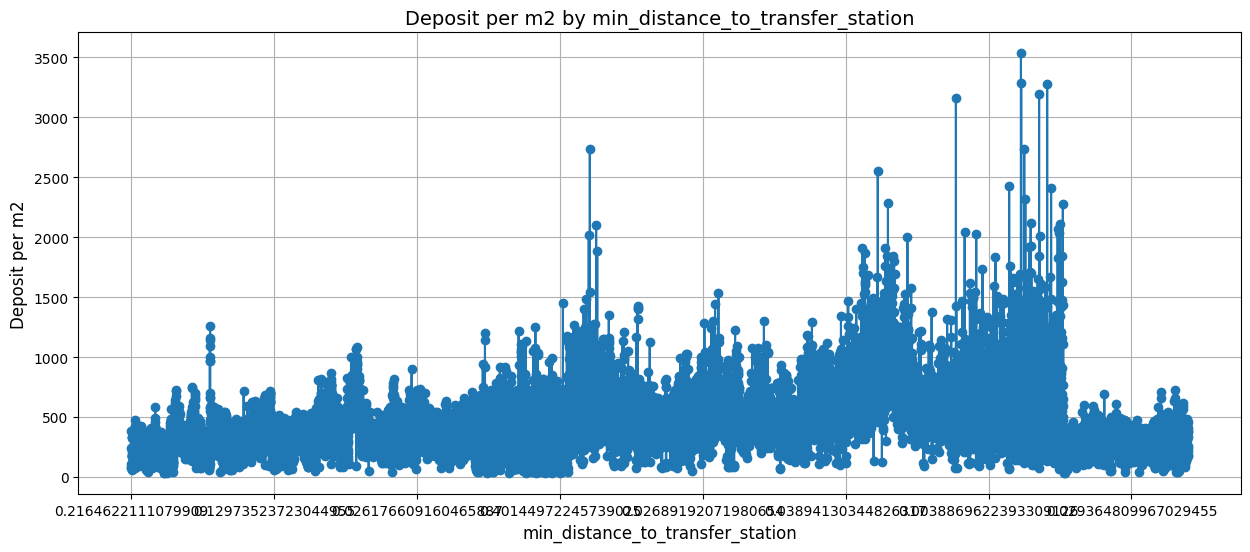

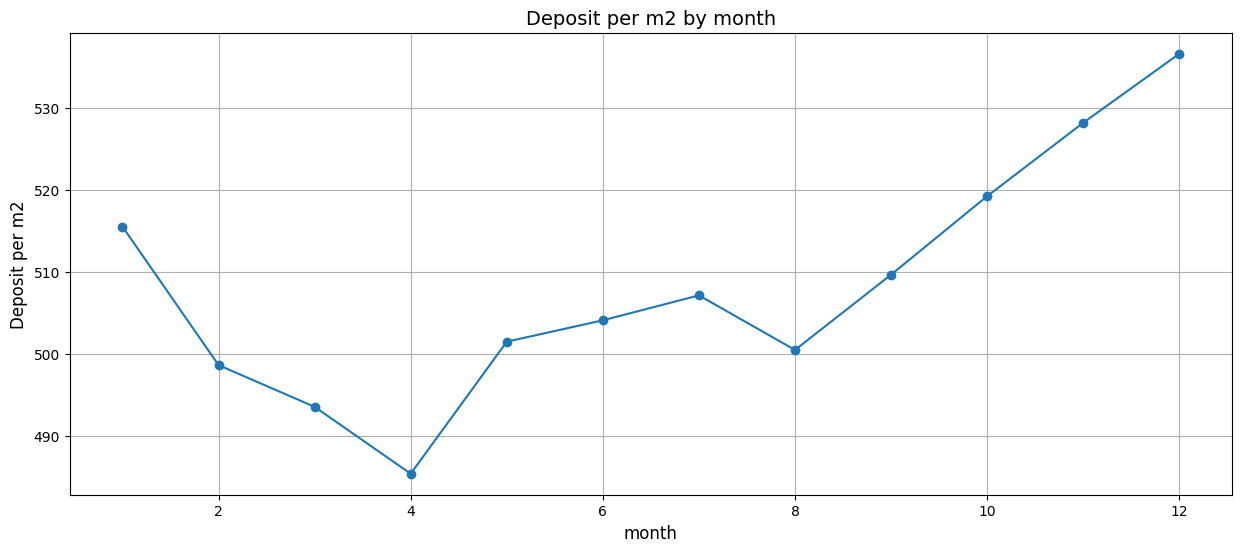

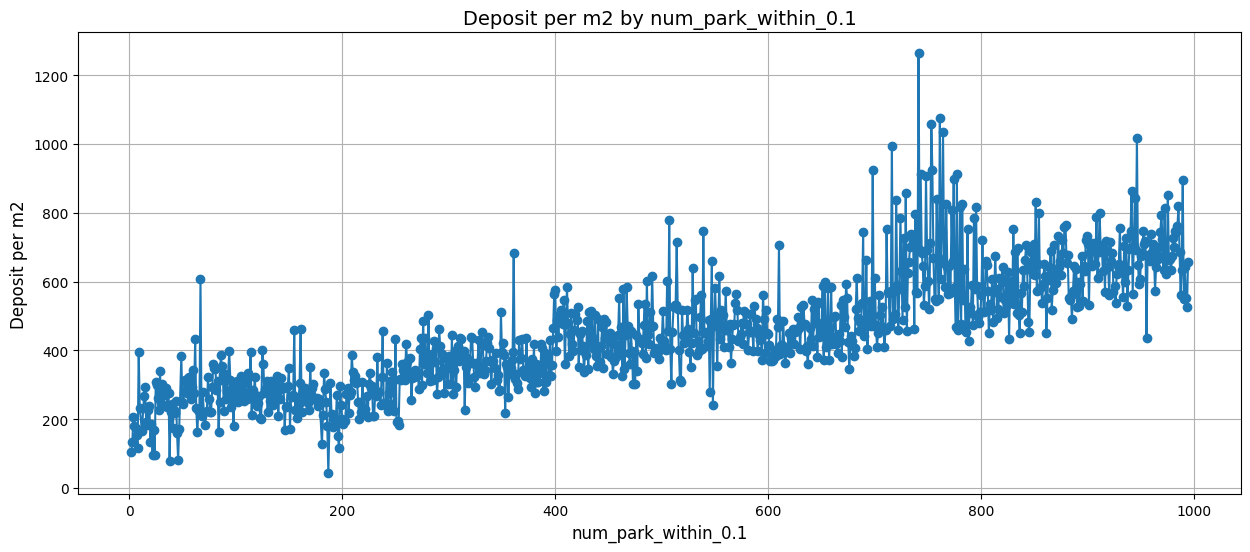

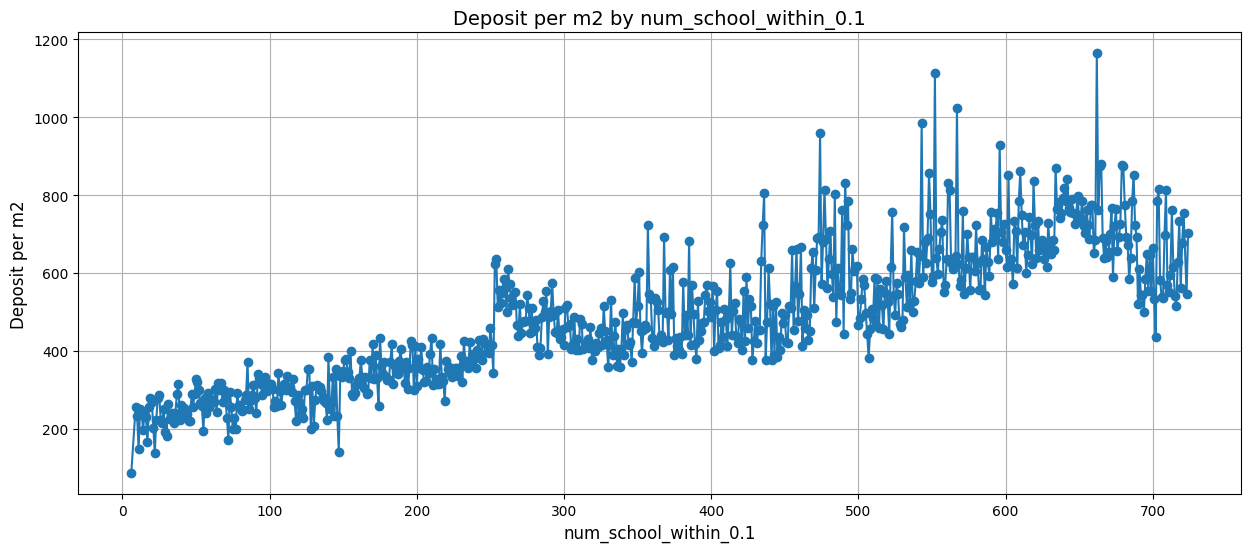

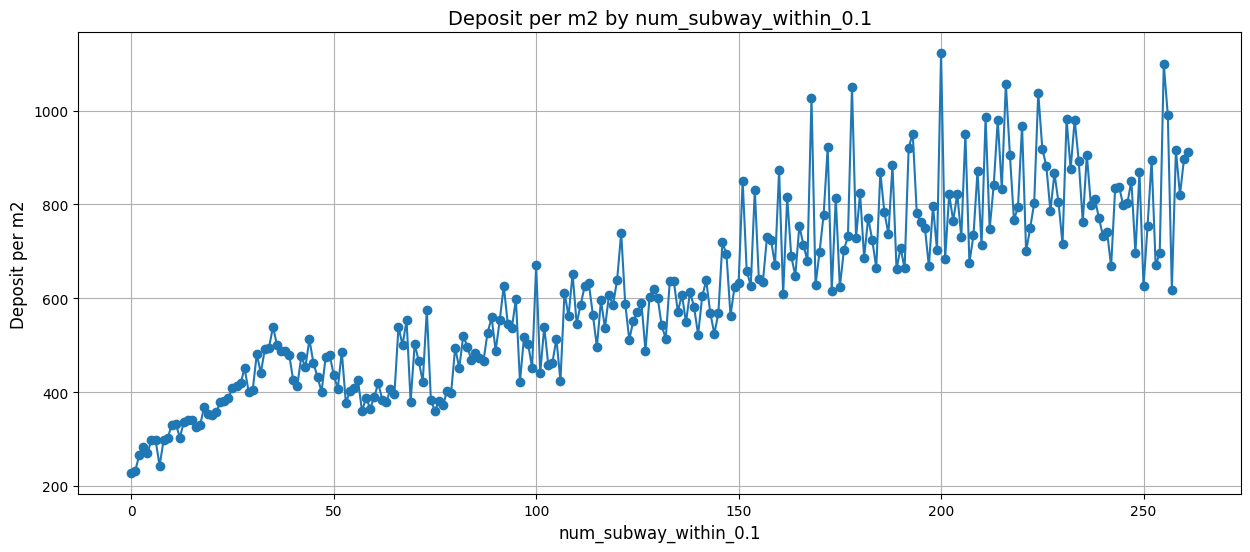

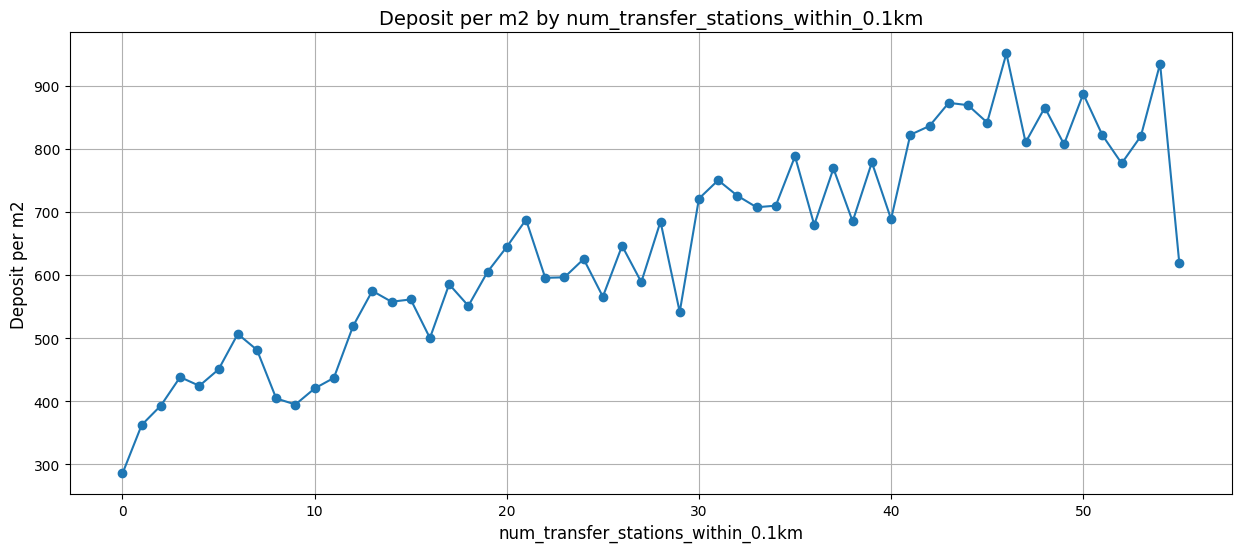

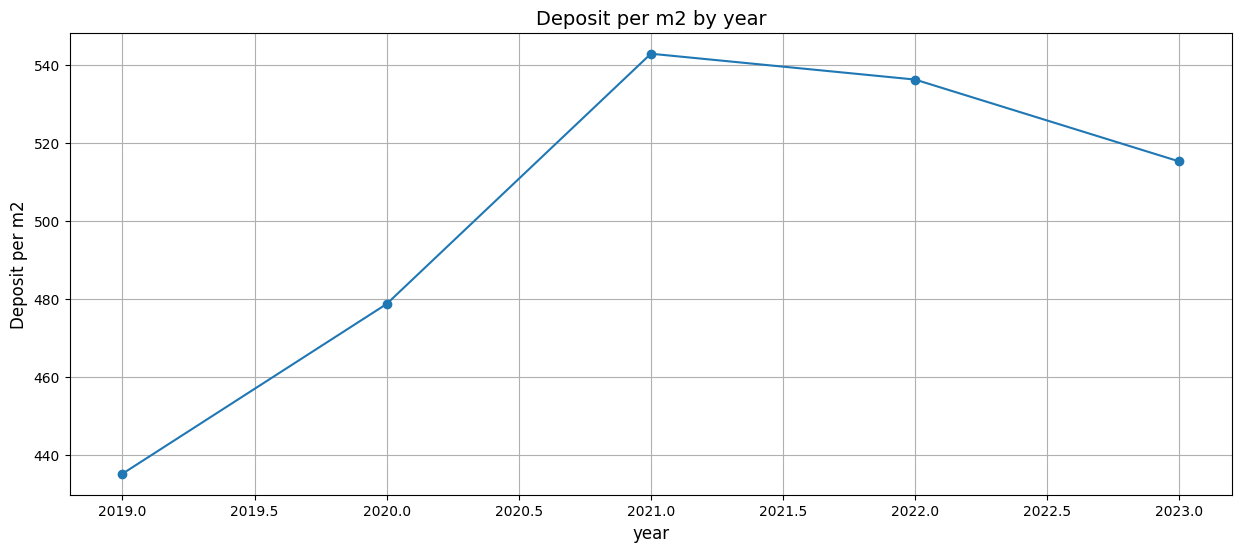

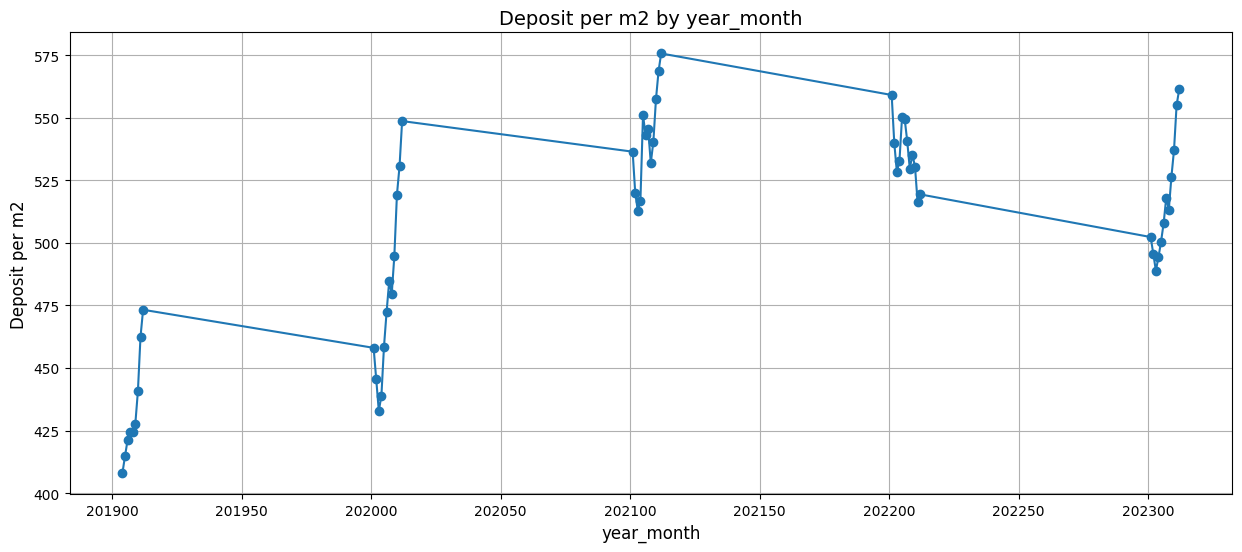

In [23]:
def plot_deposit_by_all_variables(df):
    variables = df.columns.difference(['index','deposit','latitude','longitude','contract_year_month', 'deposit_per_m2'])
    for variable in variables:
        plt.figure(figsize=(15, 6))
        df.groupby(variable)['deposit_per_m2'].mean().plot(marker='o')
        plt.title(f'Deposit per m2 by {variable}', fontsize=14)
        plt.xlabel(variable, fontsize=12)
        plt.ylabel('Deposit per m2', fontsize=12)
        plt.grid(True)
        plt.show()

plot_deposit_by_all_variables(train_df)

- 면적당 전세가를 일반 전세가와 비교했을 때 건설연도에서 70년대에서 80년대까지 일반 전세가에서는 상승했던 부분의 상승폭이 대폭 감소했다.
- 이외에는 대부분 비슷한 모습을 보였다.

## 1-5. 기초통계량

In [24]:
print(train_df.describe())

              index       area_m2  contract_year_month  contract_day  \
count  1.801228e+06  1.801228e+06         1.801228e+06  1.801228e+06   
mean   9.006135e+05  7.518833e+01         2.021331e+05  1.589943e+01   
std    5.199699e+05  2.552632e+01         1.352815e+02  8.625998e+00   
min    0.000000e+00  1.032150e+01         2.019040e+05  1.000000e+00   
25%    4.503068e+05  5.975000e+01         2.020080e+05  9.000000e+00   
50%    9.006135e+05  7.715000e+01         2.021110e+05  1.600000e+01   
75%    1.350920e+06  8.496000e+01         2.022120e+05  2.300000e+01   
max    1.801227e+06  3.173600e+02         2.023120e+05  3.100000e+01   

              floor    built_year      latitude     longitude           age  \
count  1.801228e+06  1.801228e+06  1.801228e+06  1.801228e+06  1.801228e+06   
mean   1.005197e+01  2.004199e+03  3.747721e+01  1.269662e+02  1.706597e+01   
std    6.973359e+00  1.115132e+01  1.625113e-01  1.701221e-01  1.112796e+01   
min   -4.000000e+00  1.961000e+03  

## 1-6. 상관관계

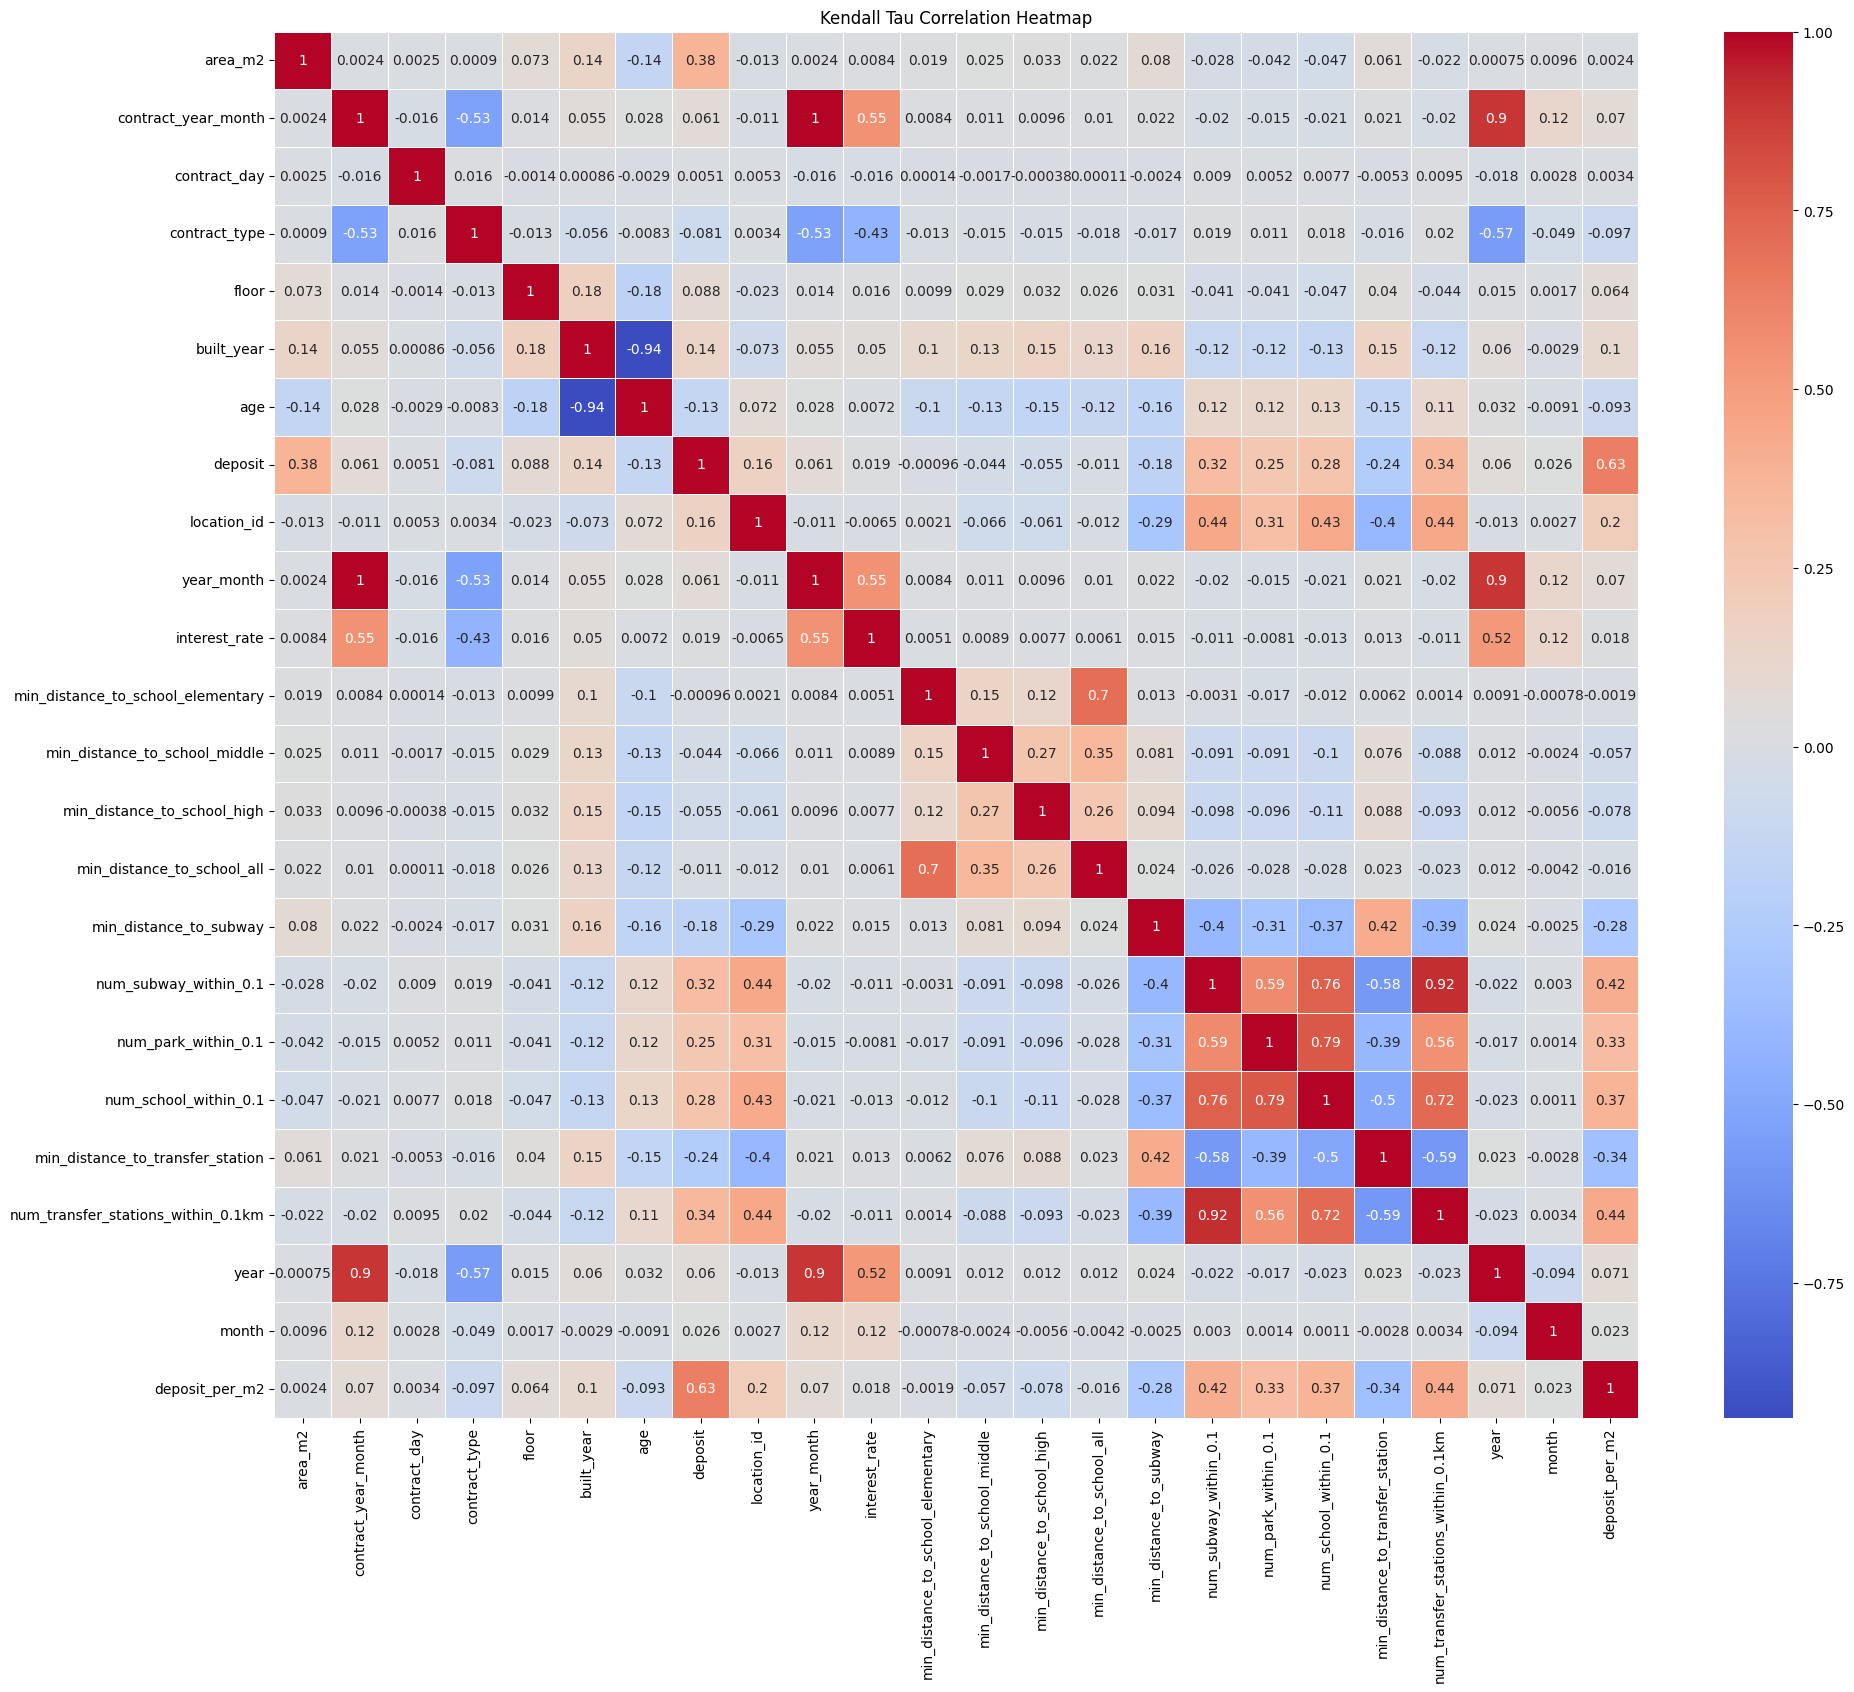

In [25]:
# Kendall Tau Correlation 계산
train_df_drop = train_df.drop(columns=['index','longitude','latitude'])
kendall_corr = train_df_drop.corr(method='kendall')

# 시각화
plt.figure(figsize=(22, 18))
sns.heatmap(kendall_corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Kendall Tau Correlation Heatmap")
plt.show()

- 전세가와 양의 관련이 높은 변수는 면적, 환승역 수, 지하철 수, 학교 수, 공원수, 아파트 자체, 건설연도이다.
- 전세가와 음의 관련이 높은 변수는 환승역과의 거리, 지하철과의 거리, 연식이다.
- 면적당 전세가와 양의 관련이 높은 변수는 환승역 수, 지하철 수, 학교수, 공원 수, 아파트 자체이다.
- 면적당 전세가와 음의 관련이 높은 변수는 환승역과의 거리, 지하철과의 거리이다.

## 1-7. 가격 상위 25% 아파트

In [26]:
# deposit 변수의 상위 75% 값을 구합니다.
threshold_75 = train_df['deposit'].quantile(0.75)

# 'deposit'이 상위 75% 이상인 데이터만 필터링합니다.
train_df_75 = train_df[train_df['deposit'] >= threshold_75]

<ipython-input-27-1fbc45d56fc9>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(total_columns))


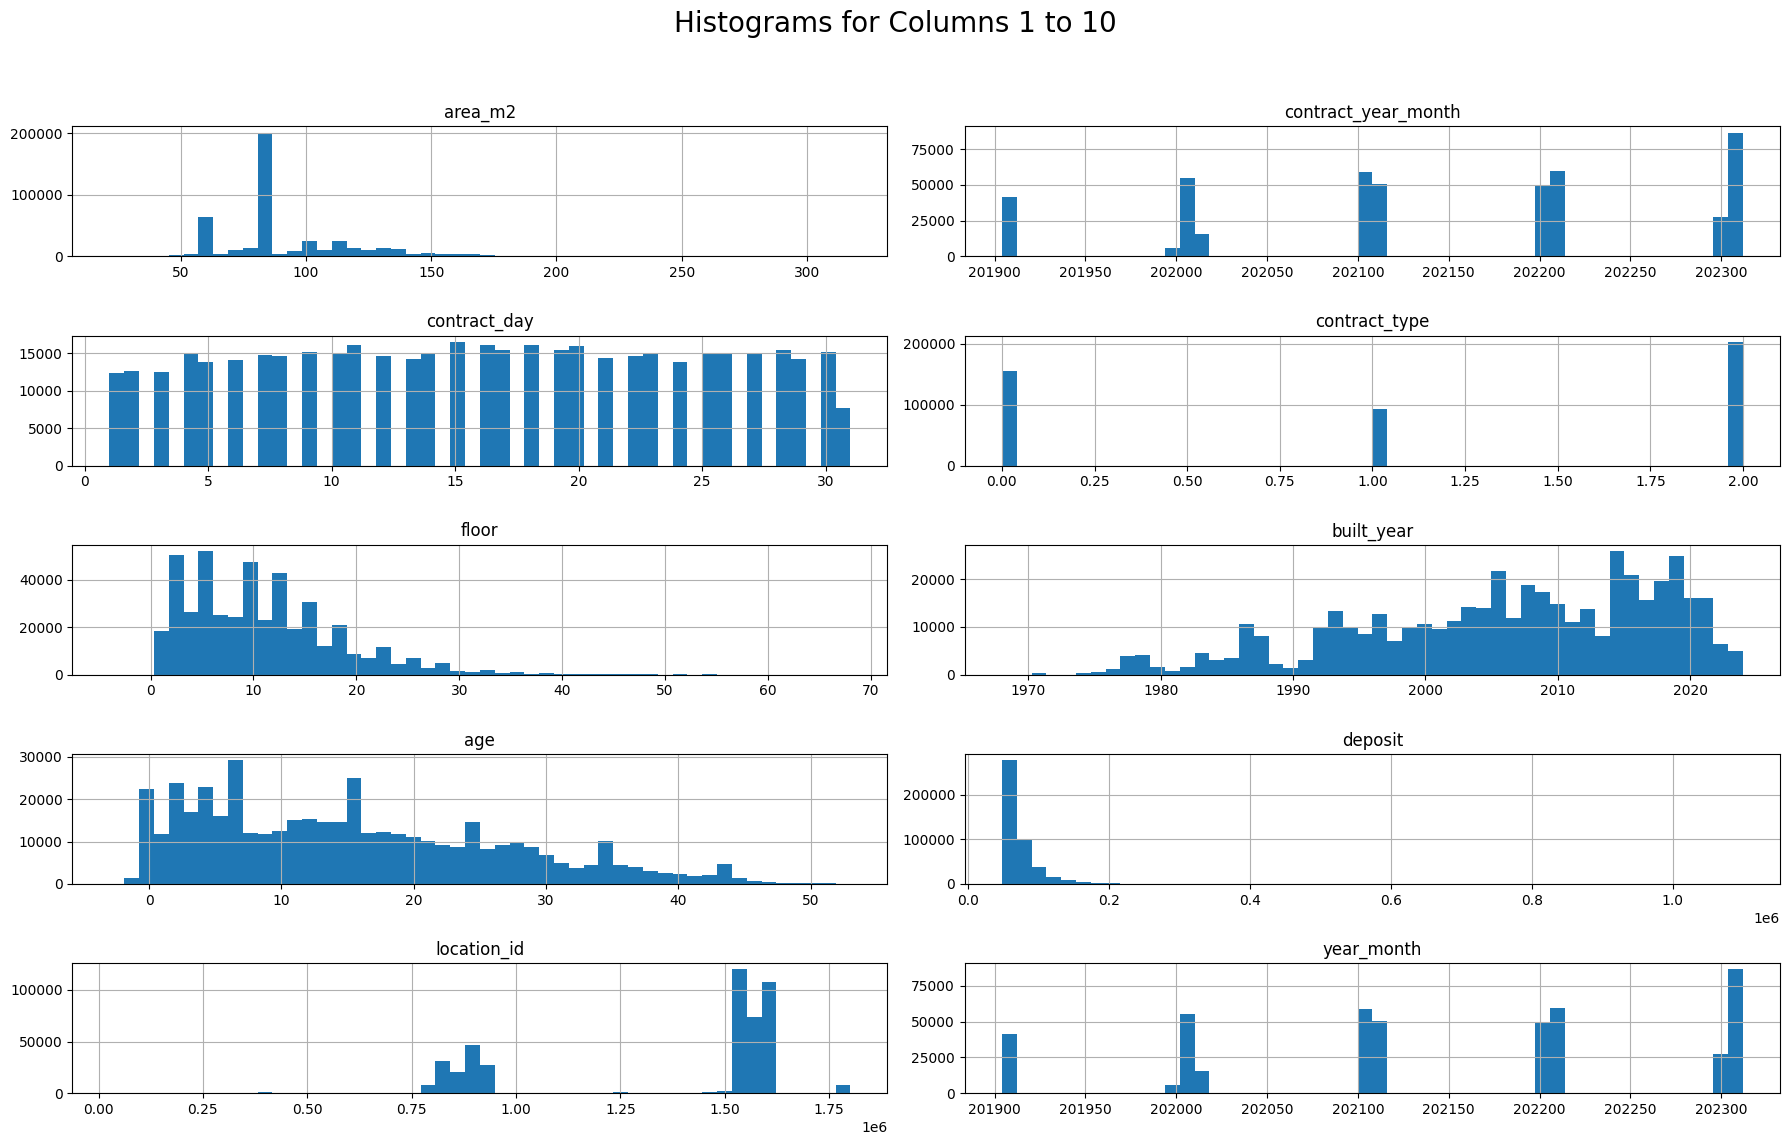

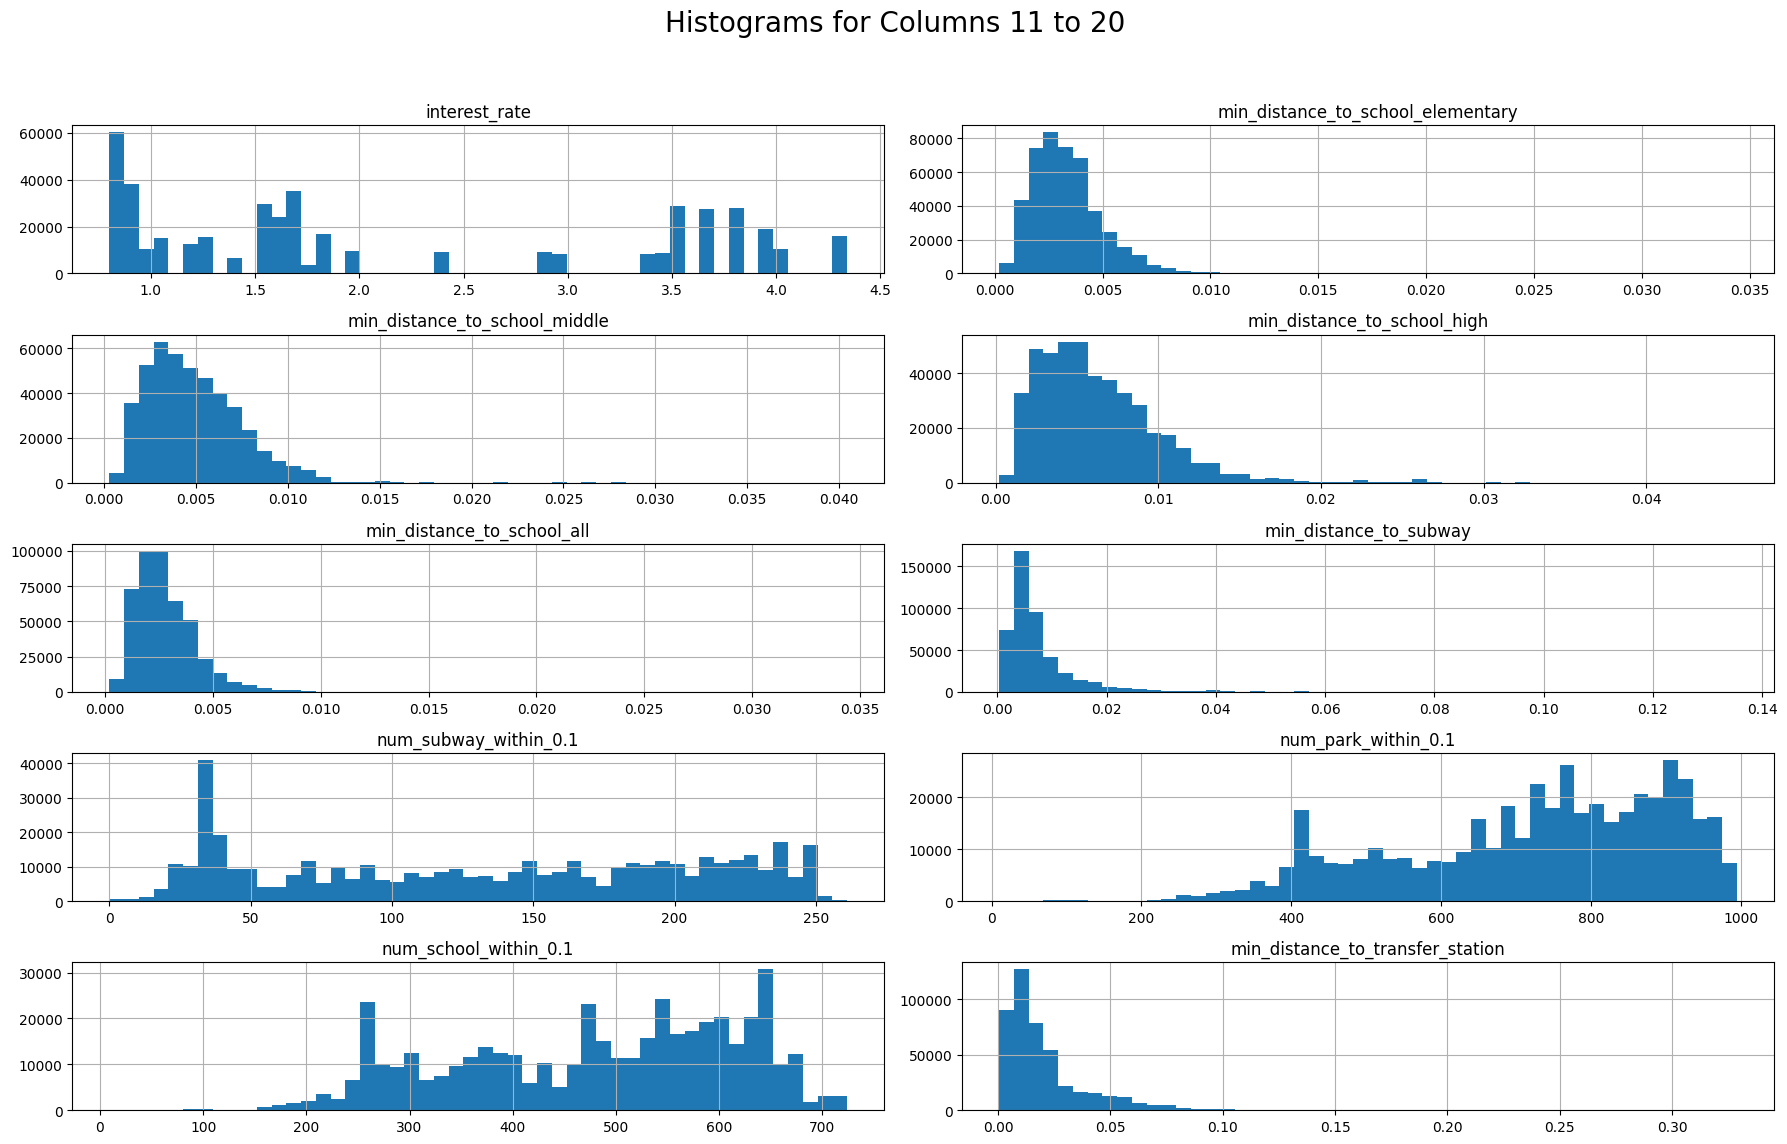

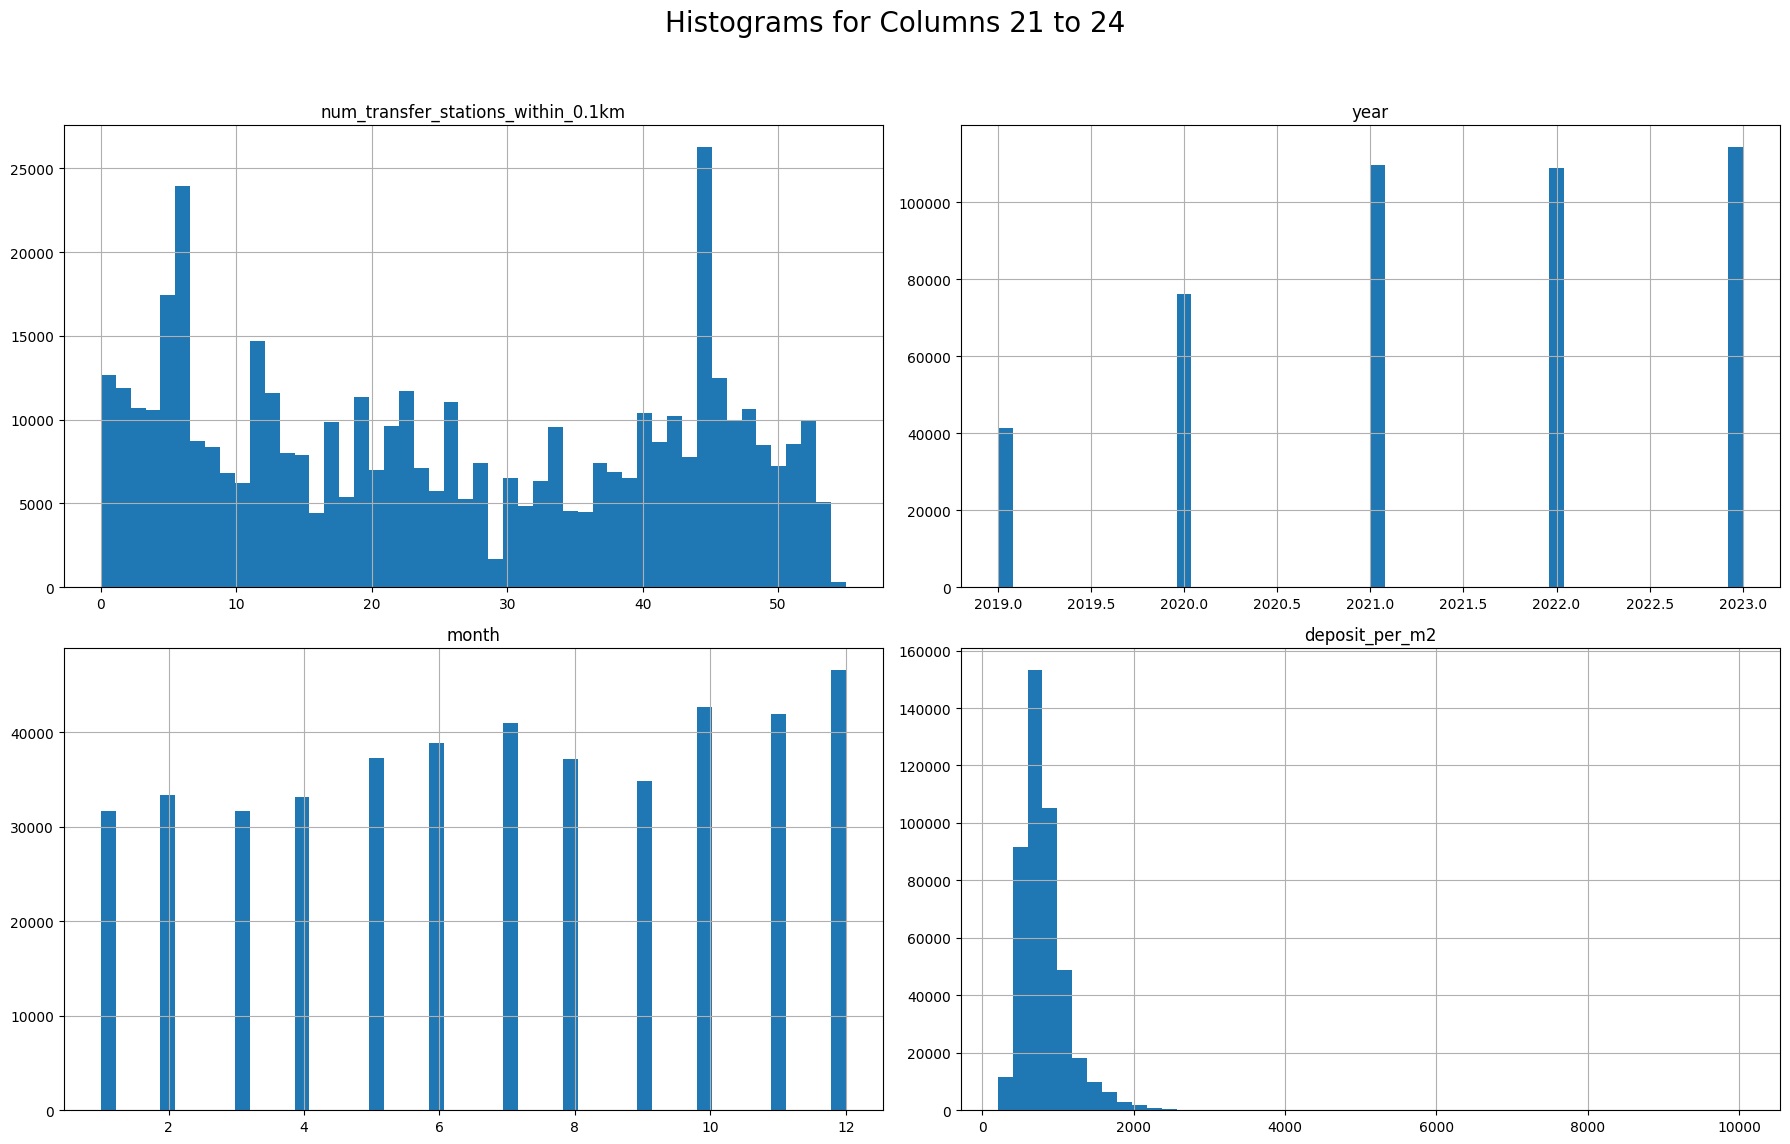

In [27]:
# 총 열 수
total_columns = train_df_75.columns.drop(['index', 'latitude','longitude'])

colors = plt.cm.get_cmap('tab20', len(total_columns))

# 10개씩 나누어 시각화
for i in range(0, len(total_columns), 10):
    # i부터 i+10까지의 열 선택
    sample_columns = total_columns[i:i + 10]

    # 선택한 열에 대해 히스토그램 생성
    fig, axes = plt.subplots(nrows=len(sample_columns)//2 + len(sample_columns)%2, ncols=2, figsize=(18, 12))
    fig.suptitle(f'Histograms for Columns {i+1} to {i+len(sample_columns)}', fontsize=20)

    for idx, col in enumerate(sample_columns):
        ax = axes.flatten()[idx]
        train_df_75[col].hist(bins=50, ax=ax)
        ax.set_title(col, fontsize=12)
        ax.tick_params(axis='x', labelsize=10)
        ax.tick_params(axis='y', labelsize=10)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

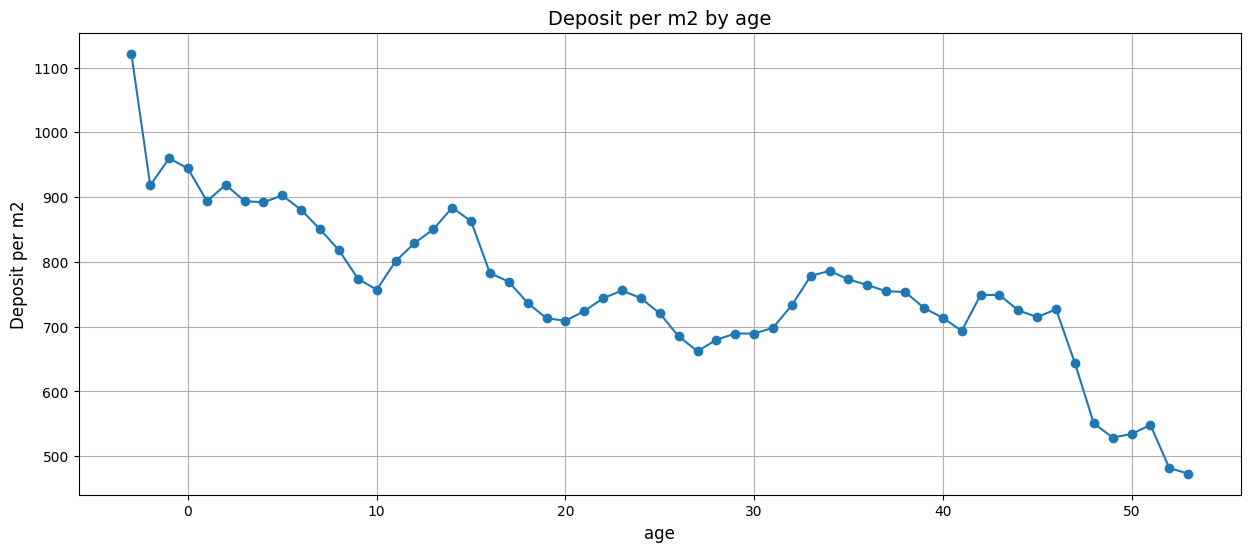

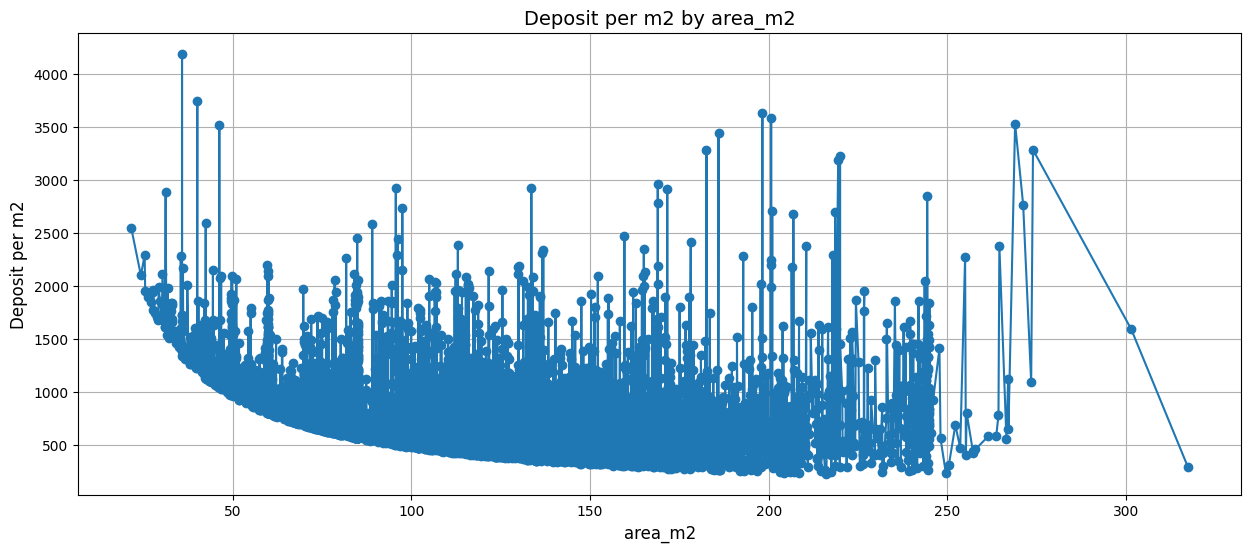

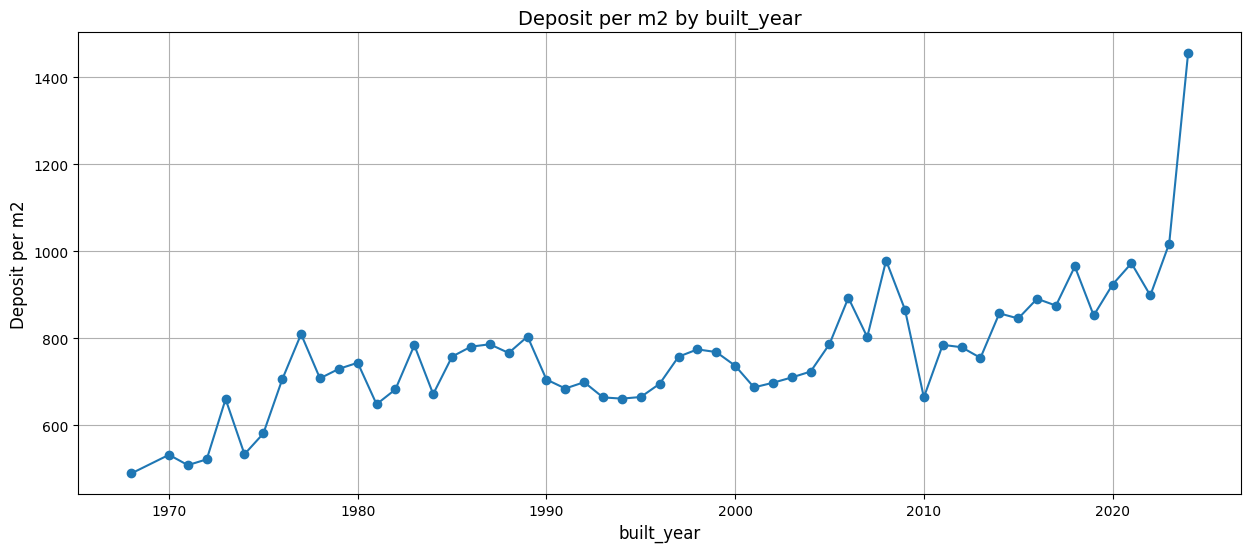

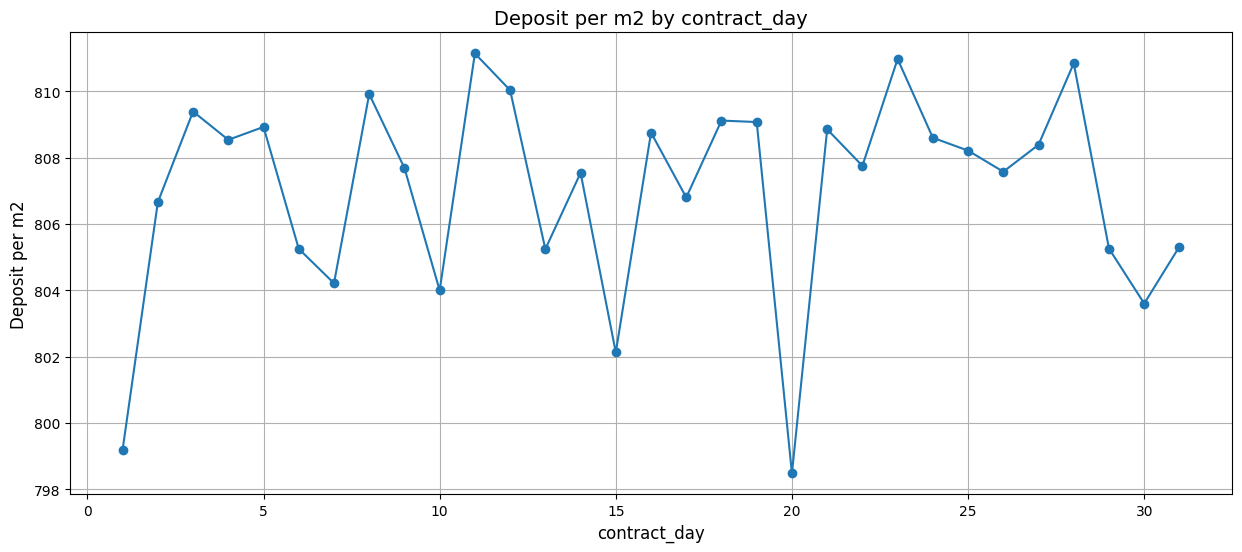

<ipython-input-23-76994e1a6cc2>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(variable)['deposit_per_m2'].mean().plot(marker='o')


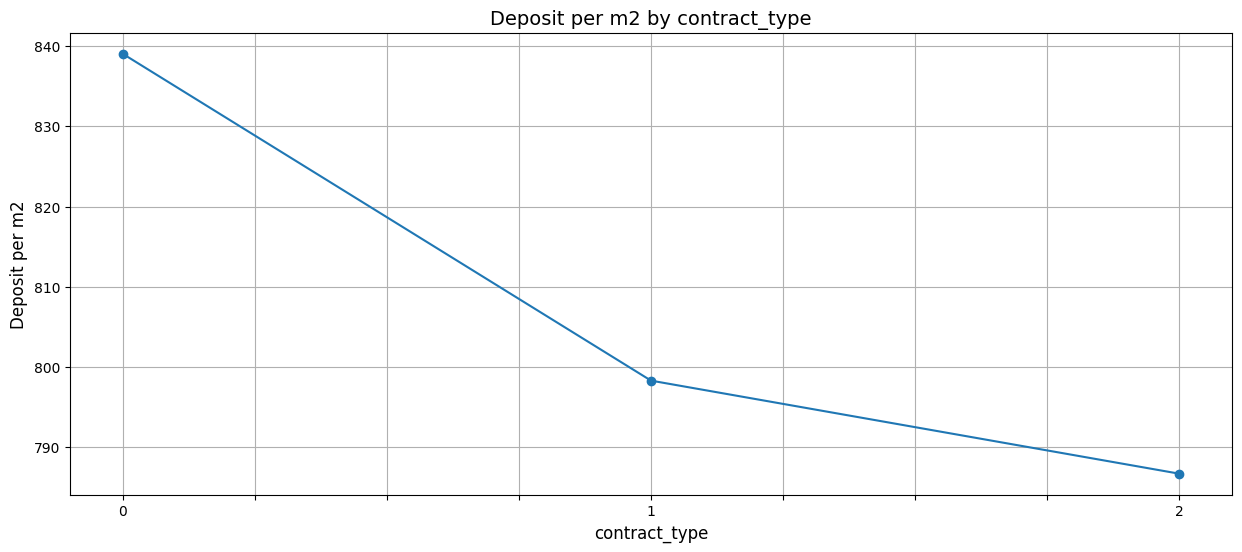

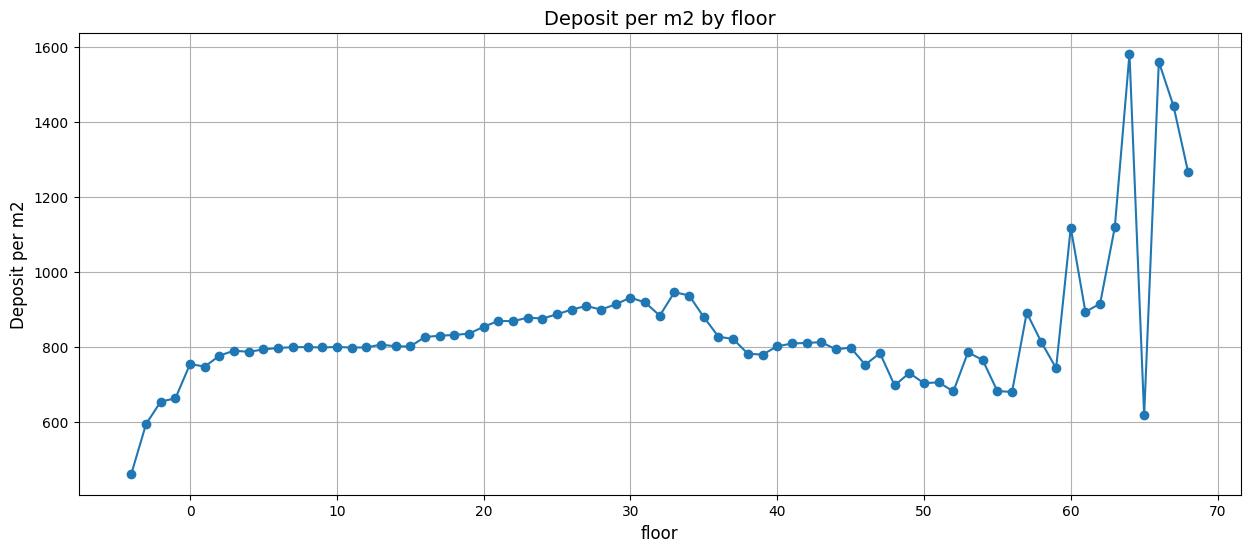

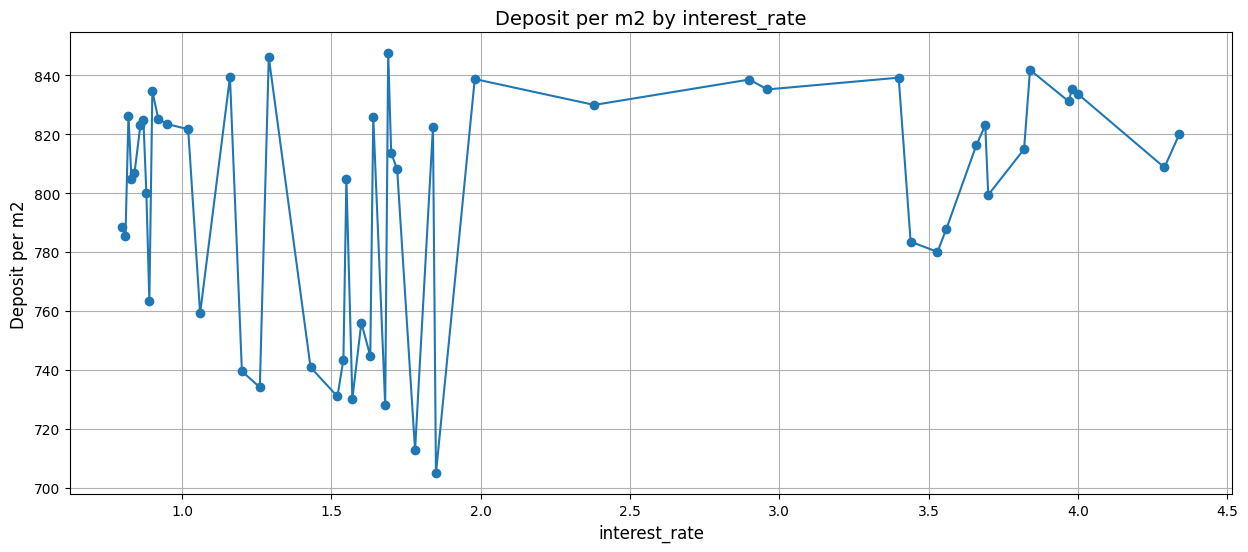

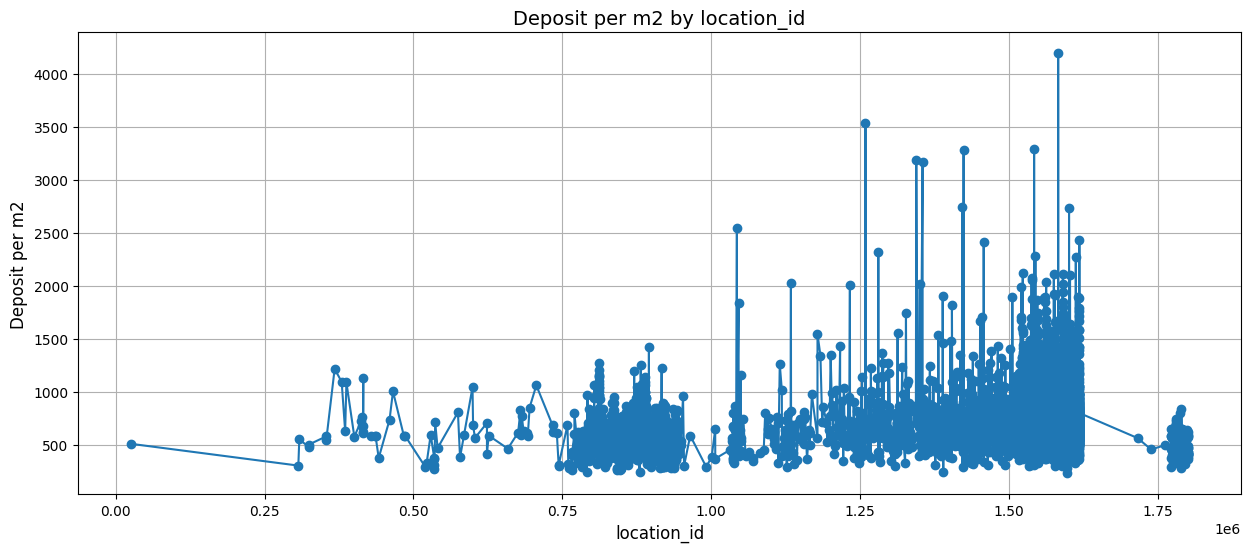

<ipython-input-23-76994e1a6cc2>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(variable)['deposit_per_m2'].mean().plot(marker='o')


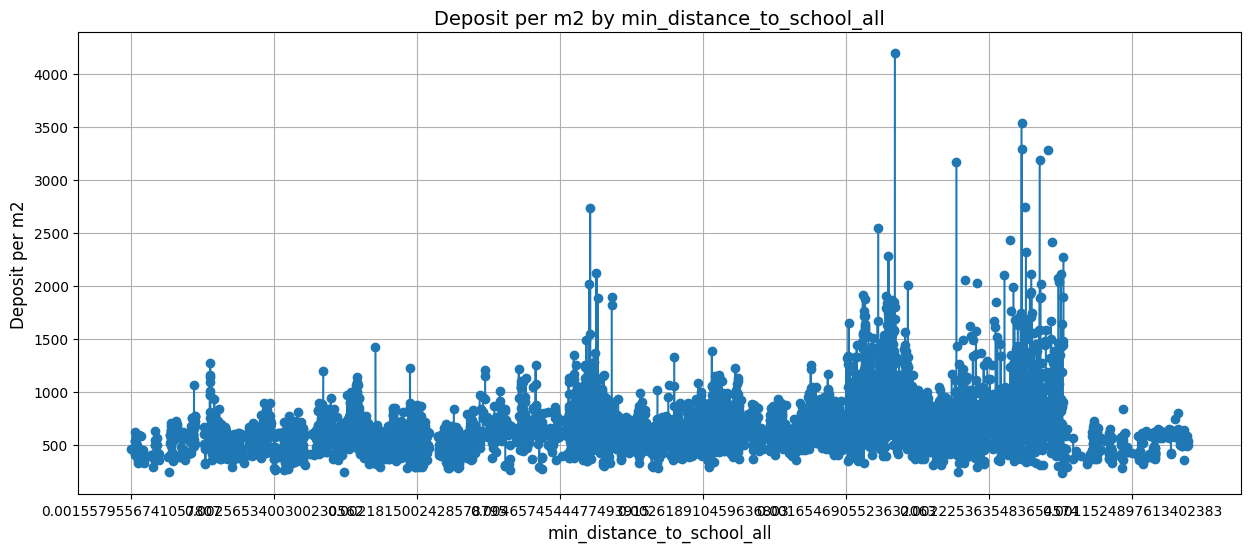

<ipython-input-23-76994e1a6cc2>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(variable)['deposit_per_m2'].mean().plot(marker='o')


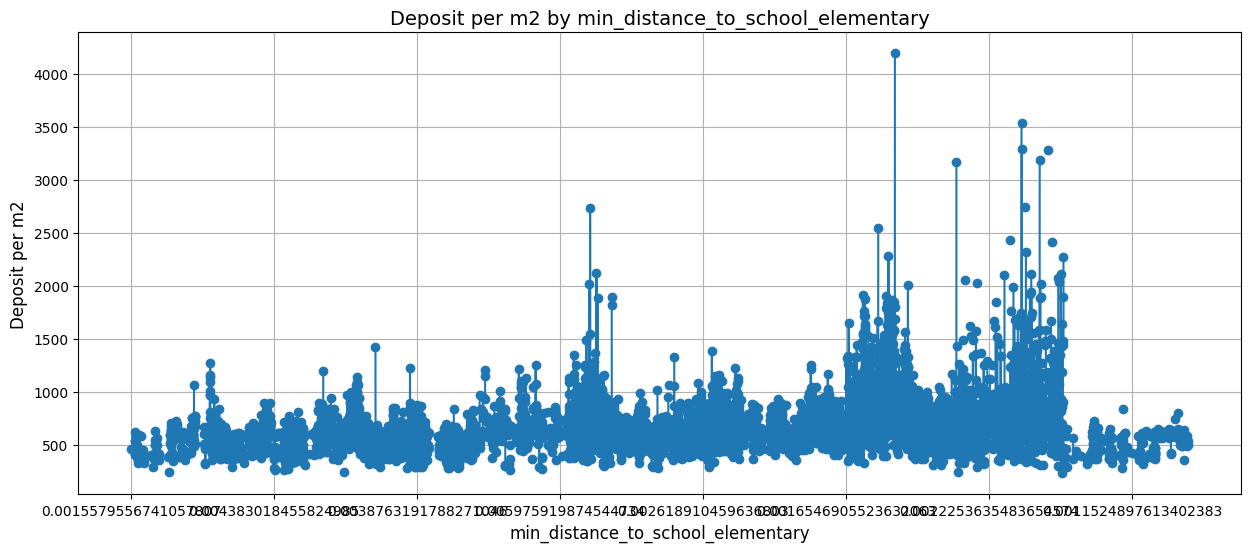

<ipython-input-23-76994e1a6cc2>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(variable)['deposit_per_m2'].mean().plot(marker='o')


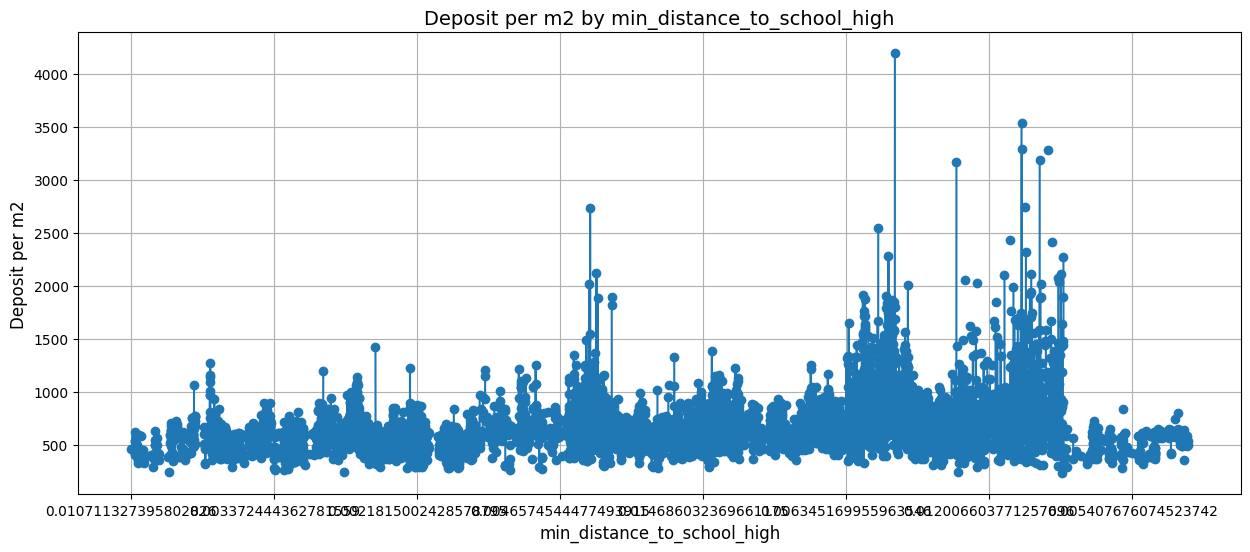

<ipython-input-23-76994e1a6cc2>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(variable)['deposit_per_m2'].mean().plot(marker='o')


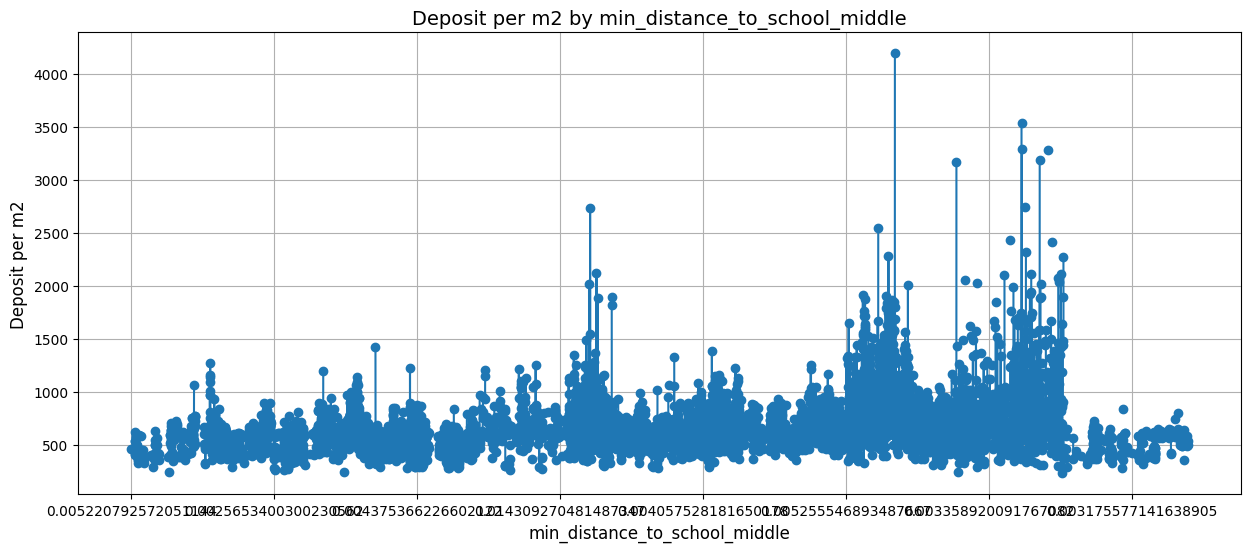

<ipython-input-23-76994e1a6cc2>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(variable)['deposit_per_m2'].mean().plot(marker='o')


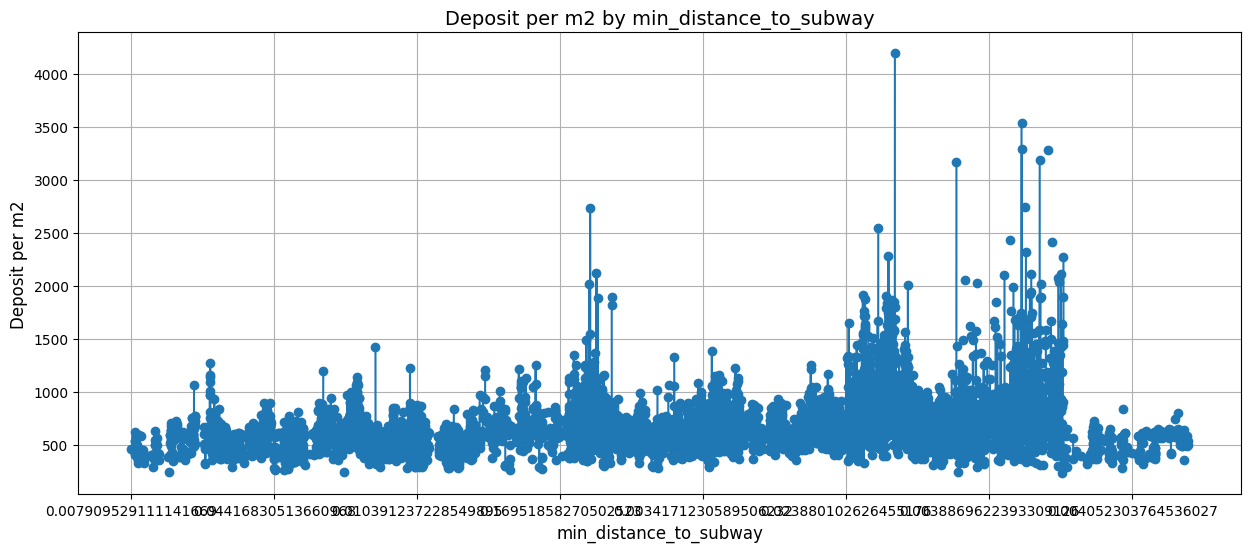

<ipython-input-23-76994e1a6cc2>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(variable)['deposit_per_m2'].mean().plot(marker='o')


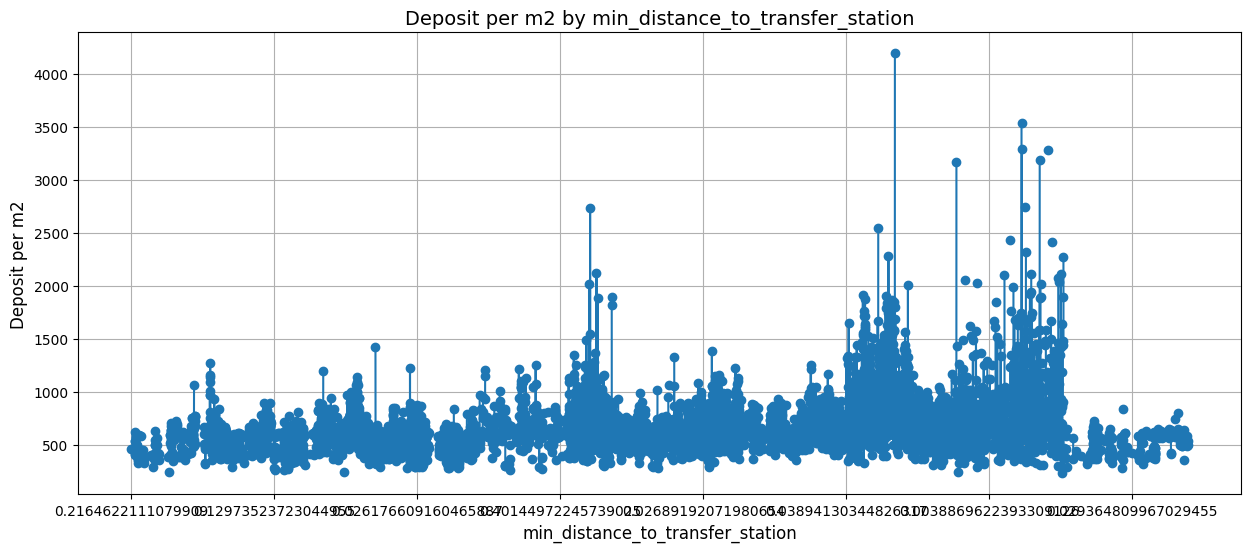

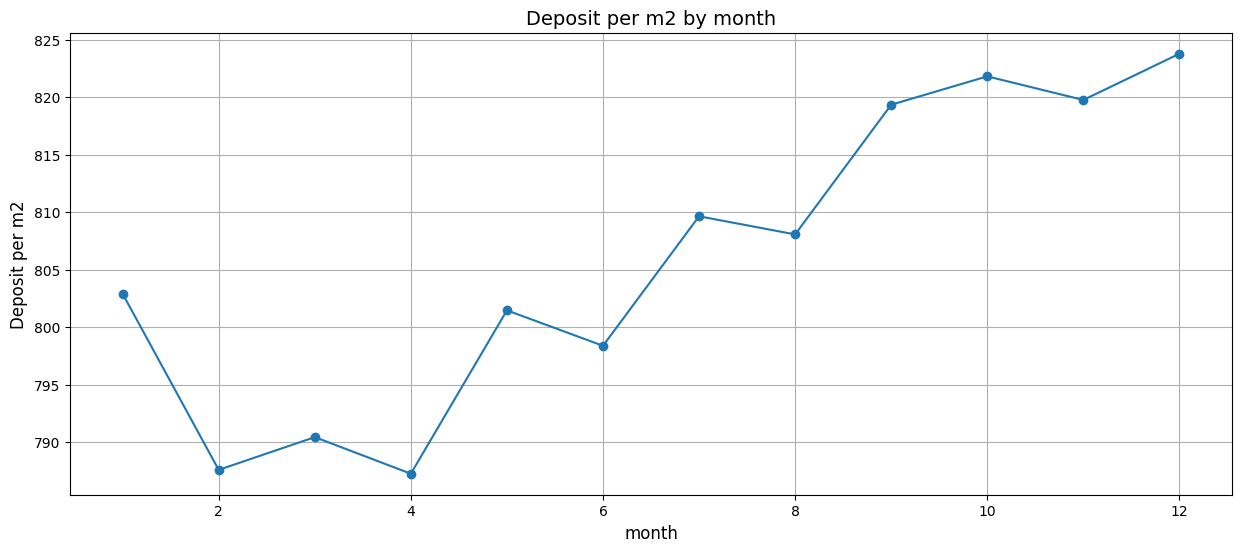

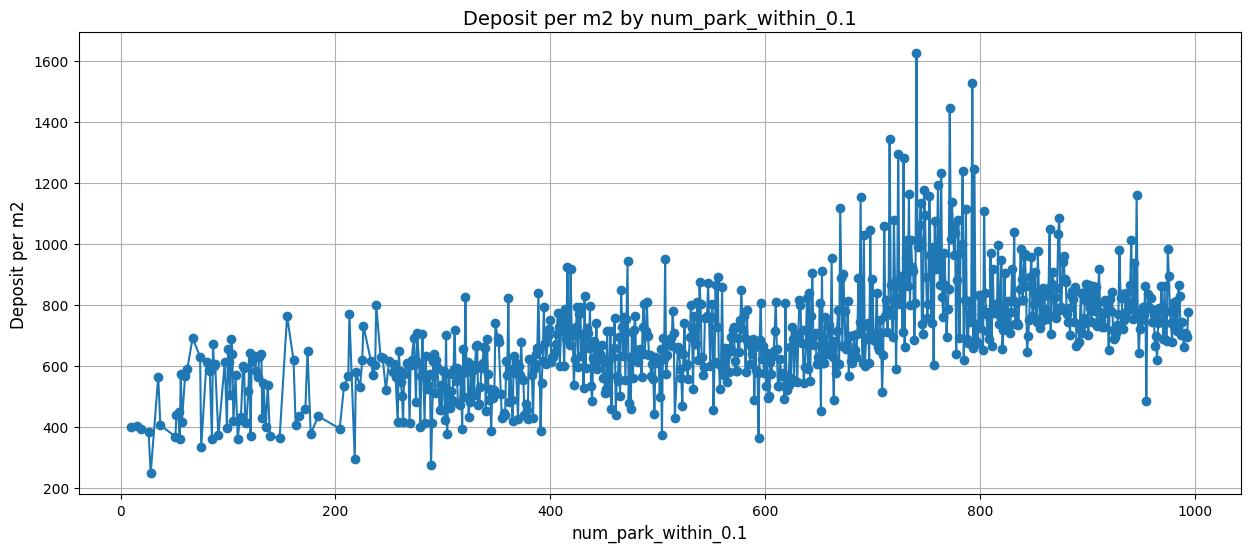

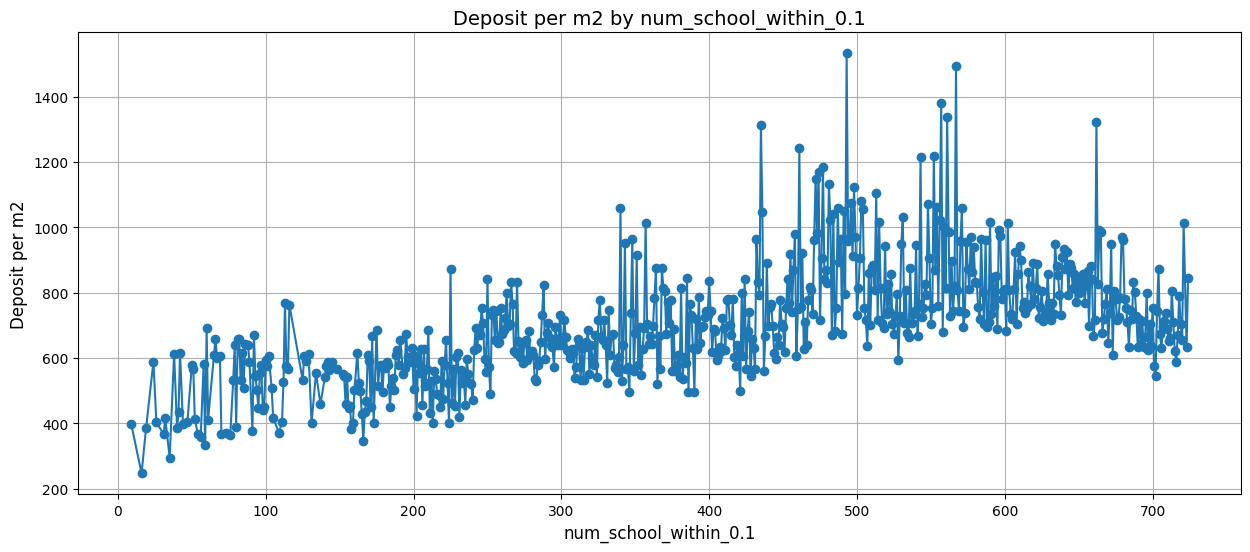

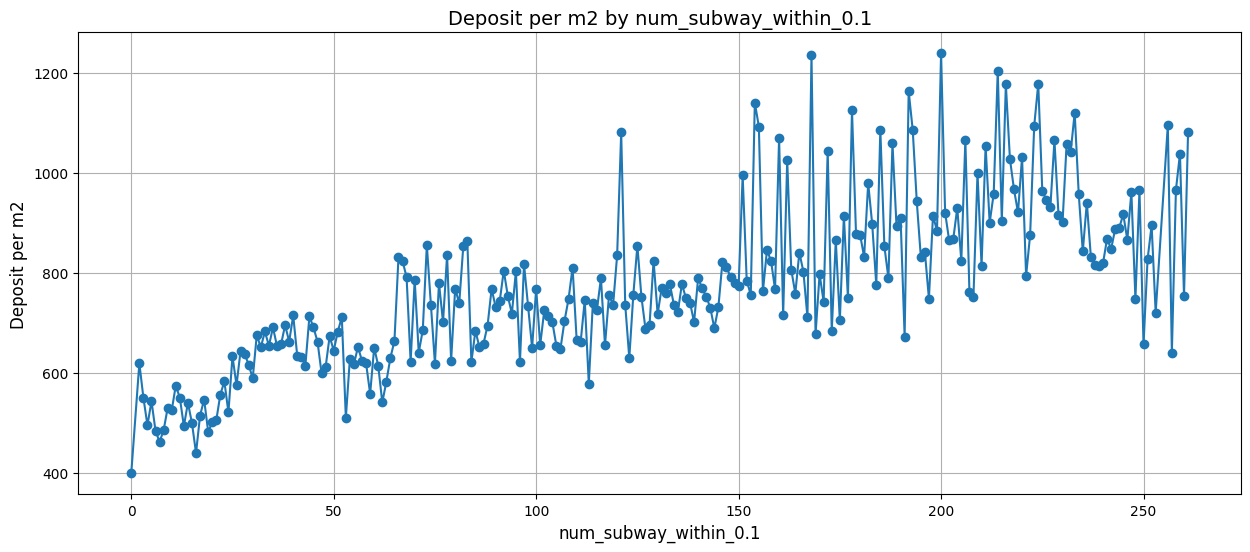

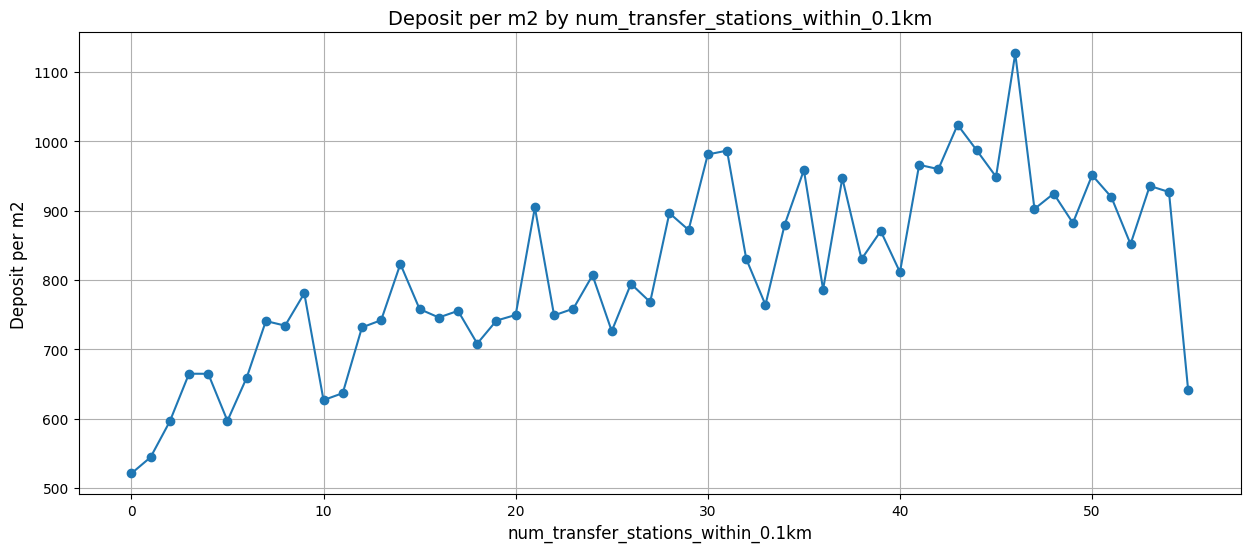

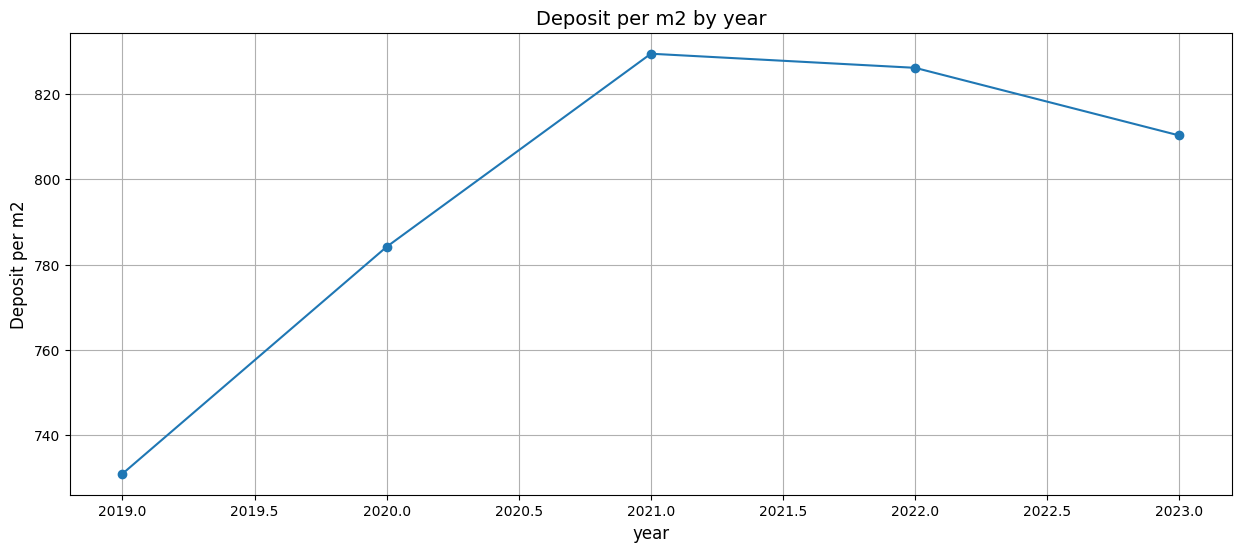

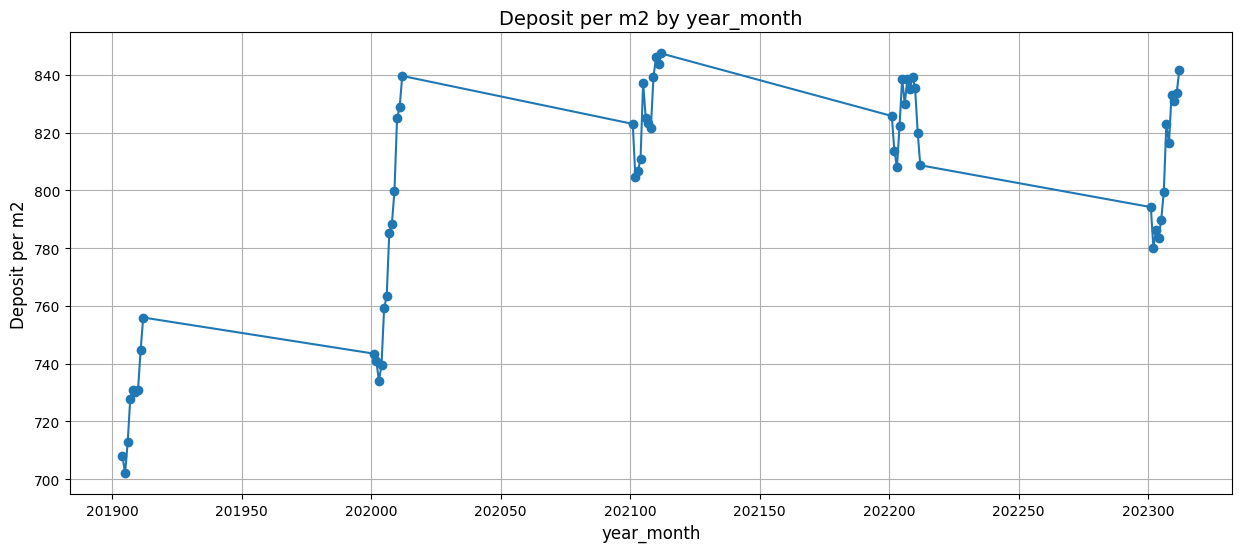

In [28]:
plot_deposit_by_all_variables(train_df_75)

- 2019년부터 21년까지 전세가의 평균이 오르다가 21년부터 23년까지 떨어진다.
- 8월부터 전세가가 증가 추세이다.
- 57층 정도부터 전세가가 급증한다.
- 월말에 가까워지면 전세가가 오른다.
- 아파트의 연식이 40년 이상이 되면 잠깐 가격이 오른다.

# 2. 학교 데이터

In [29]:
school_df.head()

schoolLevel   latitude   longitude
0  elementary  37.703889  127.540156
1  elementary  37.676874  127.600664
2  elementary  36.987340  129.399471
3  elementary  34.808753  126.456974
4  elementary  35.854580  127.003365

## 2-1. 결측치

In [30]:
print(school_df.info())
print(school_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11992 entries, 0 to 11991
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   schoolLevel  11992 non-null  object 
 1   latitude     11992 non-null  float64
 2   longitude    11992 non-null  float64
dtypes: float64(2), object(1)
memory usage: 281.2+ KB
None
schoolLevel    0
latitude       0
longitude      0
dtype: int64


## 2-2. 빈도

In [31]:
school_df['schoolLevel'].value_counts()

schoolLevel
elementary    6316
middle        3289
high          2387
Name: count, dtype: int64

## 2-3. 중복값

In [32]:
school_df_same = school_df.groupby(['latitude','longitude']).size().reset_index(name='count')
school_df_same_filtered = school_df_same[school_df_same['count'] != 1]
school_df_same_filtered_sorted = school_df_same_filtered.sort_values(by='count', ascending=False)
school_df_same_filtered_sorted

latitude   longitude  count
8642   37.473960  126.651999      8
1233   35.108185  126.873266      5
10028  37.593949  127.054891      5
10581  37.665252  127.062533      4
10168  37.610946  126.914793      4
...          ...         ...    ...
4151   35.920029  128.815991      2
4120   35.907572  128.624229      2
4113   35.903230  128.620265      2
4060   35.886199  128.421403      2
11422  38.485485  128.433401      2

[505 rows x 3 columns]

In [33]:
school_df_same_filtered_sorted['count'].value_counts()

count
2    461
3     32
4      9
5      2
8      1
Name: count, dtype: int64

- 같은 주소를 가진 초중고등학교가 4개 이상인 경우가 있다.

# 3. 지하철 데이터

In [34]:
subway_df.head()

latitude   longitude
0  37.759380  127.042292
1  37.541021  126.971300
2  37.529849  126.964561
3  37.514219  126.942454
4  37.513342  126.926382

## 3-1. 결측치

In [35]:
print(subway_df.info())
print(subway_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   700 non-null    float64
 1   longitude  700 non-null    float64
dtypes: float64(2)
memory usage: 11.1 KB
None
latitude     0
longitude    0
dtype: int64


## 3-2. 환승역 확인

In [36]:
subway_df_same = subway_df.groupby(['latitude','longitude']).size().reset_index(name='count')
subway_df_same_filtered = subway_df_same[subway_df_same['count'] != 1]
subway_df_same_filtered_sorted = subway_df_same_filtered.sort_values(by='count', ascending=False)
subway_df_same_filtered_sorted

latitude   longitude  count
389  37.562434  126.801058      4
331  37.544018  126.951592      4
387  37.561533  127.037732      4
361  37.554648  126.972559      4
431  37.580178  127.046835      4
..         ...         ...    ...
230  37.502162  127.128111      2
221  37.497175  127.027926      2
210  37.493415  127.014080      2
208  37.492970  126.895801      2
542  37.724846  127.046895      2

[99 rows x 3 columns]

In [37]:
subway_df_same_filtered_sorted['count'].value_counts()

count
2    86
3     8
4     5
Name: count, dtype: int64

- 환승역의 경우 2개의 호선이 지나는 것이 86개, 3개가 8개, 4개가 5개 있었다.

# 4. 공원 데이터

In [38]:
park_df.head()

latitude   longitude    area
0  37.509628  127.628406   856.0
1  37.508443  127.627414   847.0
2  37.493844  127.509326  1276.0
3  37.496021  127.408216  3300.0
4  37.496164  127.412326   394.0

## 4-1. 결측치

In [39]:
print(park_df.info())
print(park_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 17561 entries, 0 to 17563
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   17561 non-null  float64
 1   longitude  17561 non-null  float64
 2   area       17561 non-null  float64
dtypes: float64(3)
memory usage: 548.8 KB
None
latitude     0
longitude    0
area         0
dtype: int64


## 4-2. 이상치

In [40]:
park_df_same = park_df.groupby(['latitude','longitude']).size().reset_index(name='count')
park_df_same_filtered = park_df_same[park_df_same['count'] != 1]
park_df_same_filtered_sorted = park_df_same_filtered.sort_values(by='count', ascending=False)
park_df_same_filtered_sorted

latitude   longitude  count
9653   37.024696  126.913794     11
3496   35.336885  129.161377     11
12098  37.385549  126.953689     10
3501   35.339239  129.177498     10
5117   35.876913  127.114948      8
...          ...         ...    ...
6630   36.350919  126.608005      2
6605   36.347365  126.611368      2
6560   36.340799  126.598453      2
6403   36.302026  127.245623      2
17106  38.377102  128.465790      2

[350 rows x 3 columns]

In [41]:
park_df_same_filtered_sorted['count'].value_counts()

count
2     311
3      21
4      10
11      2
10      2
5       2
8       1
7       1
Name: count, dtype: int64

In [42]:
len(park_df[park_df['area'] == 0])

0

In [43]:
park_df.sort_values(by='area', ascending=True)

latitude   longitude         area
6399   37.159822  128.219049        1.535
6408   37.148386  128.205894        2.639
6298   37.133245  128.193063        3.411
13863  35.165276  129.111174       22.000
9576   37.227488  126.972487       30.000
...          ...         ...          ...
6925   35.758387  127.091321  5608490.000
223    37.691731  127.066034  6691885.300
14454  35.377115  129.232545  7404000.000
17119  37.692080  127.031204  8703000.000
7897   36.786642  126.451519  9320660.000

[17561 rows x 3 columns]

- 같은 주소를 공유하는 공원이 350개 존재한다.
- 공원의 넓이가 0인 공원이 3개 존재한다. (기준을 파악해 판단할 필요성이 있다.)

## 4-4. 기초통계량

In [44]:
park_df['area'].describe()

count    1.756100e+04
mean     3.104803e+04
std      2.020655e+05
min      1.535000e+00
25%      1.501300e+03
50%      2.241000e+03
75%      1.026400e+04
max      9.320660e+06
Name: area, dtype: float64

# 5. 금리 데이터

In [45]:
interest_df.head()

year_month  interest_rate
0      202405           3.56
1      202404           3.54
2      202403           3.59
3      202402           3.62
4      202401           3.66

## 5-1. 결측치

In [46]:
print(interest_df.info())
print(interest_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year_month     66 non-null     int64  
 1   interest_rate  66 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1.2 KB
None
year_month       0
interest_rate    0
dtype: int64


## 5-2. 이상치

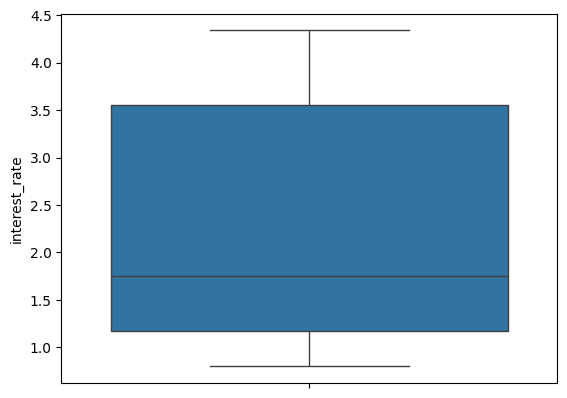

In [47]:
sns.boxplot(interest_df['interest_rate'])
plt.show()

## 5-3. 기초통계량

In [48]:
interest_df['interest_rate'].describe()

count    66.000000
mean      2.180303
std       1.172429
min       0.800000
25%       1.170000
50%       1.750000
75%       3.555000
max       4.340000
Name: interest_rate, dtype: float64

## 5-4. 시계열 분석

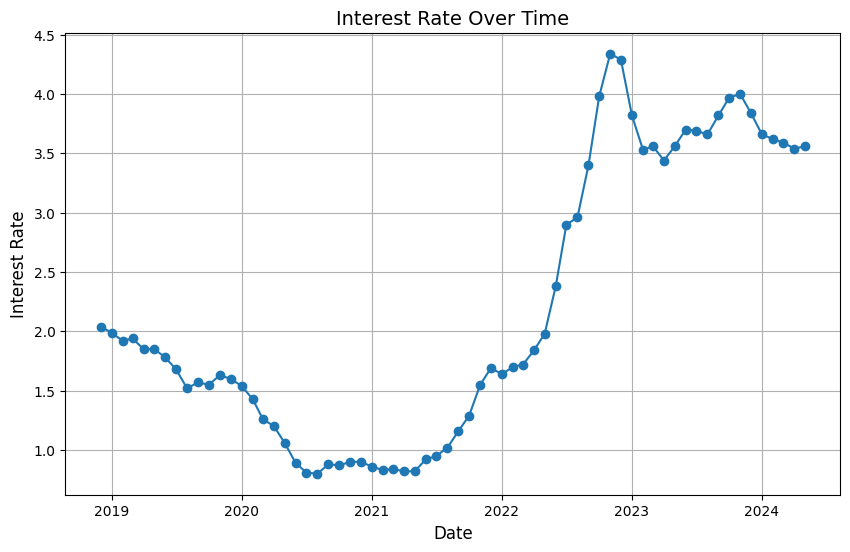

In [49]:
interest_df['year_month'] = pd.to_datetime(interest_df['year_month'], format='%Y%m')

plt.figure(figsize=(10, 6))
plt.plot(interest_df['year_month'], interest_df['interest_rate'], marker='o')
plt.title('Interest Rate Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Interest Rate', fontsize=12)
plt.grid(True)
plt.show()

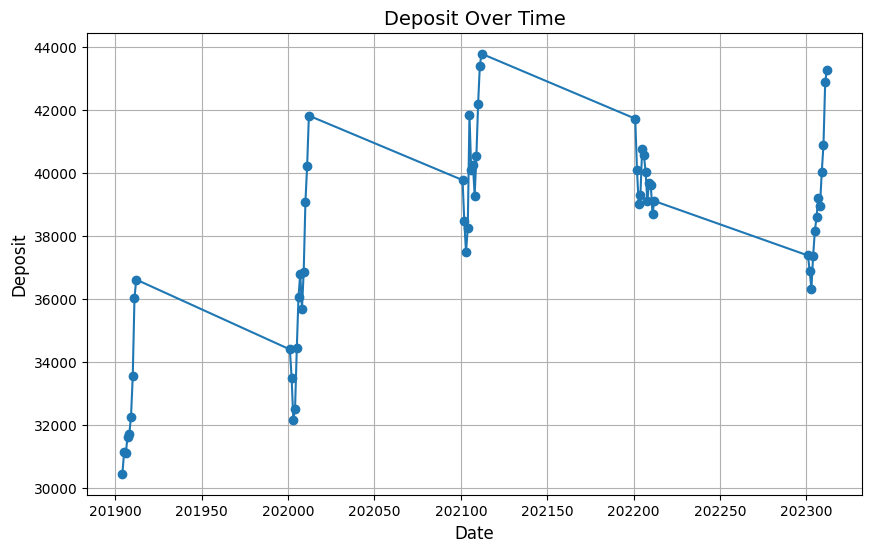

In [50]:
monthly_deposit = train_df.groupby('contract_year_month')['deposit'].mean().reset_index()

# 시계열 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(monthly_deposit['contract_year_month'], monthly_deposit['deposit'], marker='o')
plt.title('Deposit Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Deposit', fontsize=12)
plt.grid(True)
plt.show()

- 금리의 경우 2019년부터 2021년 중반까지 떨어지는 흐름을 유지하다 상승곡선을 탄 후 2022년 11월부터 살짝 떨어진 이후 계속 상승된 채로 유지중이다.